# Speech Processing - Instituto Superior Técnico
### Laboratory Assignment 2 - Spoken Language Indentification challenge

The second laboratory assignment of the course is designed to simulate a **spoken language identification** challenge. In this challenge, partipants (a.k.a students enrolled in the course) receive a train, development and evaluation (blind) data set, and a simple (and weak) baseline system for the task at hand: closed-set identification of the spoken language in a given audio file out of a set of six target langauges: Basque,  Catalan,  English,  Galician,  Portuguese and  Spanish.

The **goal** for each participant is to develop/build the best spoken language identification system. To this end, participants are encouraged to modify this baseline, incorporate any other techniques and in general explore any approach that permit  improving their results.

During the first week (Part 1), students are expected to:
- Run and understand the main components of the baseline.
- Propose and develop simple modifications to the baseline feature extraction process.
- Propose and develop simple modifications to the baseline GMM language models.
- Evaluate the models on the development partition.

During the second week (Part 2), students are expected to:
- Propose and develop other *classical* modifications to any component of the processing pipeline (openSMILE features, segment-based features, SVM classifiers, MLP/CNN classifiers, etc.)
- Run and understand the second part of Notebook that explores a pre-trained model.
- Propose and develop more recent advanced approaches, including x-vectors.
- Evaluate the models on the development partition.
- Obtain predictions for the blind test partition and prepare the submission.

The challenge distinguishes two different tracks or evaluation conditions:
- Track 1 - Participants are not allowed to use any kind of pre-trained model (such as x-vectors).
- Track 2 - Participants are allowed to use anything.


## About the data

The data consists of mono audio files sampled at 16 kHz all of them containing speech of only one of the following target languages:
```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

The dataset is organized in 4 partitions:
- `'train'`: This is the full training set, consisting of 3060 clean audio samples correponding to speech segments of TV broadcast shows. (**ATENTION**: Do not use this dataset for training your models, unless your system is very fast or if you want to build your final model. It can be slow)
- `'train100'`: This is a subset of the full training set that consists of 100 audio files per target language (**RECOMMENDATION**: Use this partition in your quick experiments, to more rapidly validate alternatives)
- `'dev'`: This is the development set. It contains audio extracted from YouTube. You will typically use this to validate the quality of your model.
- `'evl'`: This is the evaluation set. It contains audio extracted from YouTube. You don't have the groud-truth for this set. You are expected to produce it and submit it.

The data used in this challenge is a subset of the KALAKA-3 database: https://aclanthology.org/L14-1576/

The  difference is that only the clean train audio segments and the Plenty Closed evaluation condition have been considered. 

## Before starting
The following conditions are neecessary to run correctly this notebook:

*   All modules included in the requirements file need to be 
installed in the Python environment.
*   The module `pf_tools` needs to be accessible (if you are using Google Colab, you will need to copy the `pf_tools.py` every time you start a new session).

In [1]:
from pf_tools import CheckThisCell

## How can you download (and process) the data

The first thing we have to do is to set our working directory. If you are using Google Colab, you  probably want to mount Google Drive to keep persistent information, such as data, features and models:

In [2]:
#raise CheckThisCell ## <---- Remove this after completeing/checking this cell
import os 
CWD = os.getcwd() + '' # Change this variable to your working directory to store data, features and models
CWD

'/home/av/IST/slp-labs/LAB2'

The class `Kalaka` permits downloading, transforming and storing the different data partitions. Each `Kalaka` instance can be used to iterate over all the samples of the partition. It can also be used in combination with pytorch dataloader to read batches of data to train neural networks with pytorch. For instance, consider the following piece of code:


In [3]:
import numpy as np
from pf_tools import Kalaka
import librosa 

def audio_transform(filename):
    y, _ = librosa.load(filename, sr=16000, mono=True)
    return y.reshape(-1,1)
    
#trainkalaka = Kalaka(CWD, 'train100', transform_id='raw', audio_transform=audio_transform)


This will first download and uncompress the .tar.gz file containing all the necessary data of the `'train100'` partition, that is, the audio files that are stored to disk (in CWD/train100/audio/) and key file (CWD/train100/key.lst). Then, the audio transformation `'transform'` will be applied to each file and the result stored to disk CWD/train100/raw/. 

**Audio transformations** receive a filename of an audio file and returns an array of dimensions (NxD), in which N is the time dimension and D the dimension of the feature vector. In this simple case D is 1 because the transform is just returning the raw audio signal.

The `Kalaka` class permits chunking the output of the audio transformation (of size NxD) in chunks of CxD size. The chunking operation divides the orignal sample, in multiple smaller samples with a configurable chunk size and hop length. These chunks can be further transformed and stored as individual feature files. For instance:

In [4]:
trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000)

100%|██████████| 793M/793M [01:02<00:00, 13.3MB/s] 
100%|██████████| 600/600 [01:28<00:00,  6.75it/s]


This will download and uncompress the partition data, only if was not already done before. Then, as previously, the simple tranform that returns the waveform is applied to each audio file. After this, the resulting array of dimension Nx1, in which N=16000xduration_in_seconds, is split in continuous chunks of length 64000 (that is, 4 seconds) with chunk hop of 2 seconds. Each one of these chunks of 4 seconds is stored and will be accessed whenever we iterate the dataset. 

Adittionally, the optional argument `chunk_transform` pertmits defining a transformation to be applied to each chunk before storing to disk. It can be any function that receives an array of size CxD and returns an array HxW, in which H is the *new time dimension*. For instance, the following example takes the audio segments of 64000x1, computes the mean and variance every 0.1 sec (1600 samples) and returns a feature vector of size 40x2.

In [5]:
def chunk_transform(x):
    x = x.reshape(-1,1600)
    return np.concatenate((x.mean(axis=1, keepdims=True), x.std(axis=1, keepdims=True)),axis=1)

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)


100%|██████████| 600/600 [00:26<00:00, 22.77it/s]



Notice that, while the above example is probably useless as an effective feature extraction method, the proper combination of audio and chunk transformations is expected to permit quite flexible feature extraction that (hopefully) can match the needs of almost any training setting. 

Once we have instanciated a Kalaka dataset, it can be iterated to have access to each processed sample, for instance: 

In [6]:
import time
start = time.time()
for i, sample in enumerate(trainkalaka):
    data, label, basename = sample # array, int, str
    if i % 1000 == 0:
        print(i, data.shape, label, basename)

print(f'Finished reading all data in {time.time() - start}')

0 (40, 2) 6 0006ebda
1000 (40, 2) 1 11a3790f
2000 (40, 2) 4 271621da
3000 (40, 2) 5 3b9d2c2f
4000 (40, 2) 1 4d10f8f2
5000 (40, 2) 6 5fb949a1
6000 (40, 2) 6 70d28e30
7000 (40, 2) 6 7d5515f0
8000 (40, 2) 3 937623c2
9000 (40, 2) 5 a4a7491b
10000 (40, 2) 5 bc3f6e51
11000 (40, 2) 3 cd82bcca
12000 (40, 2) 1 df0b27f2
13000 (40, 2) 3 f3ba1f4d
Finished reading all data in 1.3218297958374023


Now you can use the `Kalaka` class to check the  number of files and size (in minutes) of the training set for each target language. You cankKeep these numbers to include in your system description paper:

Notice that the `Kalaka` class extends the `torch.utils.data.Dataset` and it can be used in combination with a Pytorch DataLoader to read data in batches:

In [7]:
import torch 

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)

dataloader = torch.utils.data.DataLoader(
        dataset=trainkalaka,
        batch_size=10,
        shuffle=True
)

start = time.time()
for i, batch in enumerate(dataloader):
    data, label, basename = batch
    if i % 100 == 0:
        print(data.shape, label.shape, len(basename))

print(f'Finished reading all data in {time.time() - start}')


/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
Finished reading all data in 4.175111293792725


Finally, remind that you can change anything you want. This includes the Kalaka class. Eventually, you can decide not using it at all and loading the data in some alternative way.  You can inspect the class to find the URLs for downloading the datasets. It is up to you! 

Before moving to the next stage, you probably want to delete the folders containing the dummy features that you just generated.

# PART 1 - The baseline (Track 1)
The baseline consists of MFCC feature extraction  (based on the `librosa` module) with SDC computation and VAD removal, followed by GMMs of 64 dimensions for each language (using the `sklearn` module). The rest of this notebook contains the guide and code cells (some of them partially incomplete) that permit implementing this baseline and score it on the development set. Read carefully the Markdown information, but also the comments inside the code cells (they provide useful information and hints), and also the code itself. The better you understand it, the easier will be modyfing it.

## Initialization and importing modules

In [8]:
import importlib

try:
    # importlib.import_module('opensmile')
    import opensmile
    print('OK')

except ImportError:
    # print('Package not installed')
    !pip install opensmile

OK


In [9]:
import os
from pf_tools import Kalaka
import librosa
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

import time
import random
import datetime
from pathlib import Path
import pickle
import csv 
from tqdm import tqdm
import opensmile #feature extraction
import importlib #reload packages

opensmile=importlib.reload(opensmile)

GLOBAL_SEED = 35731

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)


LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
LANG2ID = {'Basque':1, 'Catalan':2, 'English':3, 'Galician':4, 'Portuguese':5, 'Spanish':6}
ID2LANG = dict((LANG2ID[k],k) for k in LANG2ID)

## The baseline feature extraction module
The next function extracts MFCCs, but there are plenty of things that can be improved. You are free to change anything you want, including the number of formal parameters, the number of returned expressions, etc. 

In [10]:
# Read carefully this function and understand it

def feat_extract(filename, orig_sr=16000, mono=True, n_mfcc = 13, remove_c0=False, delta_order=0, 
                 apply_sdc=False, apply_vad=False, apply_cmvn=False):
    
    sr=16000
    n_mels = 40
    n_fft = 512 
    hop_length = 160
    fmin = 50
    fmax = 7800
    
    if apply_sdc and (delta_order > 0):
        raise ValueError("Applying SDC and delta > 0 is not compatible")

    
    # Load audio wav into numpy array
    y, _ = librosa.load(filename, sr=orig_sr, mono=mono)
    
    # Resample in case it's needed
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr,target_sr=sr)
    
        
    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK
    # 1 - PREPROCESSING - Typical preprocessing may include normalization of audio (mean removal), 
    #                       but also speech enhancement and others more complex
    
    # Extract MFFCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, 
                                n_mfcc=n_mfcc, n_mels=n_mels, 
                                hop_length=hop_length, 
                                fmin=fmin, fmax=fmax, htk=False).T
    
    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK

    # 2 Compute deltas --> Hint you can use librosa (order size may be a parameter?)
    if delta_order > 0:
        mfcc = compute_delta(mfcc,delta_order=delta_order)
    
    # 3 SDC --> Hint: You can build this using deltas (of extented context)  
    if apply_sdc:
        mfcc = compute_sdc(mfcc)
    
    # 4 COMPUTE VAD --> Hint: You can use any vad (theshold energy, something avaialble in the net, a biGaussian model...).
    #                         Coeff0 is highly related with Energy and sometimes it is removed
    #                   ATTENTION: Using a VAD may have a significant impact  
    if apply_vad:
        mfcc, _ = compute_vad(mfcc)
             
        
    # 5 APPLY CMVN --> ATTENTION: Using normalization may have a significant impact
    if apply_cmvn:
        mfcc = compute_cmvn(mfcc)
        

    return mfcc, y


Try to define some or all of the following steps to improve your feature extraction pipeline 

In [11]:
# Numpy arrays have methods to compute mean and variance, so this one should be really easy
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

def compute_cmvn(features):
    #return features/np.linalg.norm(features)
    return (features-np.mean(features))/np.std(features)

In [12]:
# librosa contains functions to compute deltas
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

def compute_delta(features, win=3, delta_order=2, keep_static=True):
    delta = librosa.feature.delta(
        features.T,
        width=win,order=delta_order
    ).T
    return np.hstack((features,delta))

In [13]:
# Compute deltas and then select previous and next deltas with fixed intervals to cocatentate. 
# You may need to code a bit here or dinf some function that helps with this
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

def compute_sdc(features, P=3, D=3, K=2, keep_static=True):
    delta = compute_delta(
        features.T,
        win=D, delta_order=1)[:,np.shape(features)[1]:]
    
    sdc = np.empty([np.shape(features)[0],np.shape(features)[1]*K])
    marker = np.zeros(features.shape[0], dtype='bool')
    for j in range(K):
        marker[D + j * P] = True
    for i in range(len(features)):
        sdc[i, :] = delta[marker, :].reshape(1, -1)
        marker = np.roll(marker, 1)
    return np.hstack((features,sdc))

In [14]:
# You can think of several strattegies to compute VAD, simple ones based on energy and a threshold, or maybe some more 
# ellaborated ones, like training a GMM with 2 mixtures with the Energy. 
# In addition to the features without some frames, this function may return a sequence of 0s and 1s that helps you to validate the method.
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell

# Voice Activity Detection - Zero Crossing Rate
def zero_crossing_rate(x):
    return np.sum(np.abs(np.diff(np.sign(x)))/2)/len(x)

def compute_vad(features, energy=None, y=None):
    features_aux=features[:,0:int(np.shape(features)[1]/2)]
    zcr=np.empty(np.shape(features)[1])
    for i in range(len(zcr)):
        zcr[i]=zero_crossing_rate(features[:,i])
    GM=GaussianMixture(n_components=2)
    frame_class=GM.fit_predict(zcr.reshape(-1,1))
    vad=np.empty(np.shape(features))
    for i in range(len(zcr)):
        vad[:,i]=frame_class[i]
    return np.hstack((features,vad)),frame_class

In [15]:
def opensmile_feats(signal,sr):
    smile = opensmile.Smile(
            feature_set=opensmile.FeatureSet.GeMAPSv01b ,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    opensmile_feats=smile.process_signal(signal,sr)
    return np.hstack(opensmile_feats.values)

You can test in an isolated audio file and inspect the dimensions, verify that your code is doing what is expected, inspect and visualize the data using some of the lessons learnt in LAB1. Also, don't forget to listen some of the examples!!

In [16]:
# raise CheckThisCell ## <---- Remove this after completeing/checking this cell
mfcc, _=feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=True, apply_sdc=False,apply_vad=False)
mfcc_dd, _ = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False, delta_order=2)
mfcc_d, _ = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False, delta_order=1)
mfcc, y = feat_extract(f'{CWD}/train100/audio/0006ebda.wav', apply_cmvn=False)


To run the data processing stage for the train100 partition we will simply instanciate the Kalaka class as mentioned previosly. Take a sit because it can take a bit:

In [17]:
#Transformation  Combinations attempted    BEST: mfcc_delta1
transform = {
    'mfcc_sdc_vad_chunk_300_400' : {
        'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0],
        'chunk_transform': None,
        'chunk_size': 300,
        'chunk_hop':300
    },

    'mfcc_delta1_vad' : {
        'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=True, apply_cmvn=True)[0],
        'chunk_transform': None,
        'chunk_size': 300,
        'chunk_hop':300
    },

    'mfcc_sdc' : {
        'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 13, apply_sdc=True, apply_vad=False, apply_cmvn=True)[0],
        'chunk_transform': None,
        'chunk_size': 300,
        'chunk_hop':300
    },

    'mfcc_delta1' : {
        'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0],
        'chunk_transform': None,
        'chunk_size': 300,
        'chunk_hop':300
    },

    'mfcc' : {
        'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=False)[0],
        'chunk_transform': None,
        'chunk_size': 300,
        'chunk_hop':300
    },
}

Check your current folder, many things happened!! 

Notice that if you instanciate again the Kalaka class for the 'train100' partition, the data will not be downloaded again. 
Additionally, if there is already a folder with the name `transform_id`, feature extraction will not run again. You need to delete from your filesystem the folder with the features if you want to run again the feature extraction (using the same identifier) or , alternatively, you can change the identifier. Be careful because you can easily increase the amount of data generated. If you try a feature extraction method that provides bad results, you probably don't want to keep the features in disk.

## The baseline spoken language models
The baseline model is extremely simple: we'll train an individual GMM model for each language on top of the features that we just extracted. Later, in prediction time, given a test audio sample, we'll compute the loglikelihood obtained with each GMM model and select as the identified language the one whose model gives the highest likelihood. Let's go for it!!


In [18]:
# from sklearn.model_selection import GridSearchCV # Not useful for GMM's

trainset = 'train100'
transform_id = 'mfcc'
parameters = {
    # 'transform_id': ['feat', 'mfcc'],
    'audio_transform': [
        lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0], # mfcc_cmvn
        lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=True, apply_cmvn=True)[0], # mfcc_delta1_vad_cmvn
        lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 13, apply_sdc=True, apply_vad=False, apply_cmvn=True)[0], # mfcc_sdc_cmvn
        lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=1, n_mfcc = 13, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0], # mfcc_delta1_cmvn
        lambda x : feat_extract(x, orig_sr=16000, mono=True,delta_order=0, n_mfcc = 7, apply_sdc=False, apply_vad=False, apply_cmvn=False)[0], # mfcc
    ],
    'chunk_size': [1024, 2048],
    'chunk_hop': [512, 1024],

    'n_gauss': [8, 16, 32]
}

In [19]:
import itertools

def parameter_combinations(param_grid):
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = list(itertools.product(*values))
    return [dict(zip(keys, combination)) for combination in combinations]

def concat_kalaka(trainkalaka):
    # print('concatenating Kalaka')
    train_data = []
    train_labels = []
    for data, label, basename in trainkalaka:
            train_data.append(data)
            train_labels.append(np.full(data.shape[0], label)) 

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)
    return train_data, train_labels

from sklearn.metrics import accuracy_score

def eval_gmm(gmm, kalaka):

    LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
    LANG2ID = {'Basque':1, 'Catalan':2, 'English':3, 'Galician':4, 'Portuguese':5, 'Spanish':6}
    ID2LANG = dict((LANG2ID[k],k) for k in LANG2ID)

    dev_data = {}
    for data, label, basename in kalaka:
        if basename not in dev_data:
                dev_data[basename] = {'data':[], 'label':label}

        dev_data[basename]['data'].append(data)

    ## We concatenate all the frames belonging to the same filename
    for basename in dev_data:
        dev_data[basename]['data'] = np.concatenate(dev_data[basename]['data'])
    
    # return dev_data[basename]

    results = {}
    results['ref'] =  np.empty(len(dev_data), dtype=np.int32)
    results['hyp'] =  np.empty(len(dev_data), dtype=np.int32)
    results['llhs'] = np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
    results['fileids'] = list()
    
    for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
        data = dev_data[fileid]['data']  # the features
        
        results['fileids'].append(fileid)     #fileid

        # obtain the log-likelihood score for each model and store
        results['llhs'][i,:] = np.array([gmm[lang].score(data) for lang in LANGUAGES])

        # store the reference.
        results['ref'][i] = (dev_data[fileid]['label']) #reference

        # Obtain the maximum likelihood languge estimation
        ix = np.argmax(results['llhs'][i,:])
        results['hyp'][i] = LANG2ID[LANGUAGES[ix]]
    
    return accuracy_score(results['ref'], results['hyp'])

In [20]:
combinations = parameter_combinations(parameters)

best_parameters = {
    
    # 'transform_id': None,
    'audio_transform': None,
    'chunk_size': None,
    'chunk_hop': None,
    'n_gauss': None
}
best_score = -float('inf')
best_model = 0
all_acc = []
all_traintime = []

for i, c in enumerate(combinations):
    print('\nCombination', i+1)
    parms = list(c.values())
    '''
    parms[0] = audio_transform (lambda)
    parms[1] = chunk_size
    parms[2] = chunk_hop
    parms[3] = n_gauss
    '''
    start = time.time()
    trainset = 'train100'
    trainkalaka = Kalaka(
        CWD, trainset,
        transform_id='mfcc',
        audio_transform=parms[0],
        chunk_transform=None,
        chunk_size=parms[1],
        chunk_hop=parms[2]
    )

    # print('Training model')
    train_data, train_labels = concat_kalaka(trainkalaka)

    GMM = {}
    for l, lang in enumerate(LANGUAGES):
        GMM[lang] = GaussianMixture(
            n_components = parms[3],
            covariance_type='diag',
            max_iter=15, n_init=1,
            init_params='kmeans',
            verbose=2, verbose_interval=1
        )
        GMM[lang].fit(train_data[train_labels==LANG2ID[lang]])
    all_traintime.append(time.time() - start)

    # score = GMM.score(train_data)
    acc = eval_gmm(GMM, trainkalaka)
    print(f'Accuracy Score = {acc}\n')

    all_acc.append(acc)

    if acc > best_score:
        best_score = acc
        best_model = i+1
        best_parameters = c.copy()
        best_GMM = GMM.copy()



print(f'Best Model #{best_model}')
print('Best Parameters:\n', best_parameters)
print('Best Accuracy =', best_score)


Combination 1


100%|██████████| 600/600 [01:22<00:00,  7.28it/s]


Initialization 0
  Iteration 1	 time lapse 4.54480s	 ll change inf
  Iteration 2	 time lapse 2.28912s	 ll change 0.51795
  Iteration 3	 time lapse 1.93357s	 ll change 0.01558
  Iteration 4	 time lapse 2.13857s	 ll change 0.01130
  Iteration 5	 time lapse 1.57593s	 ll change 0.00936
  Iteration 6	 time lapse 2.15250s	 ll change 0.00752
  Iteration 7	 time lapse 1.67322s	 ll change 0.00568
  Iteration 8	 time lapse 1.28867s	 ll change 0.00413
  Iteration 9	 time lapse 1.29712s	 ll change 0.00300
  Iteration 10	 time lapse 1.49950s	 ll change 0.00222
  Iteration 11	 time lapse 1.70590s	 ll change 0.00169
  Iteration 12	 time lapse 1.38176s	 ll change 0.00132
  Iteration 13	 time lapse 1.48599s	 ll change 0.00105
  Iteration 14	 time lapse 2.16363s	 ll change 0.00084
Initialization converged: True	 time lapse 27.13067s	 ll 2.56142
Initialization 0
  Iteration 1	 time lapse 4.47280s	 ll change inf
  Iteration 2	 time lapse 2.44486s	 ll change 0.65836
  Iteration 3	 time lapse 1.81469s	 ll c

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:42<00:00, 14.13it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5583333333333333


Combination 2
Initialization 0
  Iteration 1	 time lapse 8.75574s	 ll change inf
  Iteration 2	 time lapse 4.32521s	 ll change 0.49884
  Iteration 3	 time lapse 4.20883s	 ll change 0.01702
  Iteration 4	 time lapse 4.77128s	 ll change 0.01000
  Iteration 5	 time lapse 4.23566s	 ll change 0.00713
  Iteration 6	 time lapse 4.09994s	 ll change 0.00560
  Iteration 7	 time lapse 4.53438s	 ll change 0.00467
  Iteration 8	 time lapse 3.85092s	 ll change 0.00407
  Iteration 9	 time lapse 3.98507s	 ll change 0.00368
  Iteration 10	 time lapse 3.56191s	 ll change 0.00338
  Iteration 11	 time lapse 3.64996s	 ll change 0.00308
  Iteration 12	 time lapse 3.39658s	 ll change 0.00281
  Iteration 13	 time lapse 3.57445s	 ll change 0.00260
  Iteration 14	 time lapse 3.69913s	 ll change 0.00244
  Iteration 15	 time lapse 3.78512s	 ll change 0.00226
Initialization converged: False	 time lapse 64.43459s	 ll 2.69630


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 9.67677s	 ll change inf
  Iteration 2	 time lapse 4.42697s	 ll change 0.55677
  Iteration 3	 time lapse 4.29960s	 ll change 0.01921
  Iteration 4	 time lapse 4.28381s	 ll change 0.01202
  Iteration 5	 time lapse 4.26073s	 ll change 0.00867
  Iteration 6	 time lapse 4.09980s	 ll change 0.00659
  Iteration 7	 time lapse 4.31693s	 ll change 0.00516
  Iteration 8	 time lapse 4.03162s	 ll change 0.00420
  Iteration 9	 time lapse 4.16591s	 ll change 0.00358
  Iteration 10	 time lapse 3.94281s	 ll change 0.00318
  Iteration 11	 time lapse 4.00815s	 ll change 0.00285
  Iteration 12	 time lapse 3.52949s	 ll change 0.00246
  Iteration 13	 time lapse 3.90934s	 ll change 0.00204
  Iteration 14	 time lapse 3.53442s	 ll change 0.00165
  Iteration 15	 time lapse 3.71749s	 ll change 0.00136
Initialization converged: False	 time lapse 66.20451s	 ll 2.89899


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 9.27165s	 ll change inf
  Iteration 2	 time lapse 4.10826s	 ll change 0.52196
  Iteration 3	 time lapse 3.88912s	 ll change 0.02000
  Iteration 4	 time lapse 3.74384s	 ll change 0.01382
  Iteration 5	 time lapse 4.01542s	 ll change 0.01192
  Iteration 6	 time lapse 4.08371s	 ll change 0.01163
  Iteration 7	 time lapse 4.03632s	 ll change 0.01111
  Iteration 8	 time lapse 3.84956s	 ll change 0.00948
  Iteration 9	 time lapse 4.25932s	 ll change 0.00739
  Iteration 10	 time lapse 4.18422s	 ll change 0.00546
  Iteration 11	 time lapse 4.05809s	 ll change 0.00395
  Iteration 12	 time lapse 3.87152s	 ll change 0.00293
  Iteration 13	 time lapse 3.82804s	 ll change 0.00227
  Iteration 14	 time lapse 3.88371s	 ll change 0.00183
  Iteration 15	 time lapse 4.38391s	 ll change 0.00152
Initialization converged: False	 time lapse 65.46701s	 ll 1.93392


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.41980s	 ll change inf
  Iteration 2	 time lapse 3.00210s	 ll change 0.49917
  Iteration 3	 time lapse 3.19307s	 ll change 0.02069
  Iteration 4	 time lapse 3.22291s	 ll change 0.01376
  Iteration 5	 time lapse 3.32988s	 ll change 0.01046
  Iteration 6	 time lapse 3.23547s	 ll change 0.00831
  Iteration 7	 time lapse 2.69908s	 ll change 0.00673
  Iteration 8	 time lapse 4.75580s	 ll change 0.00552
  Iteration 9	 time lapse 4.68412s	 ll change 0.00457
  Iteration 10	 time lapse 1.72320s	 ll change 0.00383
  Iteration 11	 time lapse 1.07622s	 ll change 0.00327
  Iteration 12	 time lapse 0.95526s	 ll change 0.00286
  Iteration 13	 time lapse 0.97721s	 ll change 0.00254
  Iteration 14	 time lapse 0.99504s	 ll change 0.00228
  Iteration 15	 time lapse 0.99242s	 ll change 0.00206
Initialization converged: False	 time lapse 42.26168s	 ll 2.57235


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.76166s	 ll change inf
  Iteration 2	 time lapse 0.90700s	 ll change 0.61046
  Iteration 3	 time lapse 0.89572s	 ll change 0.01899
  Iteration 4	 time lapse 0.87955s	 ll change 0.01326
  Iteration 5	 time lapse 0.88149s	 ll change 0.01083
  Iteration 6	 time lapse 0.91071s	 ll change 0.00907
  Iteration 7	 time lapse 0.88859s	 ll change 0.00744
  Iteration 8	 time lapse 0.90239s	 ll change 0.00600
  Iteration 9	 time lapse 0.88460s	 ll change 0.00489
  Iteration 10	 time lapse 0.89447s	 ll change 0.00413
  Iteration 11	 time lapse 0.86837s	 ll change 0.00368
  Iteration 12	 time lapse 0.90455s	 ll change 0.00343
  Iteration 13	 time lapse 0.92614s	 ll change 0.00317
  Iteration 14	 time lapse 0.89160s	 ll change 0.00270
  Iteration 15	 time lapse 0.89937s	 ll change 0.00215
Initialization converged: False	 time lapse 15.29632s	 ll 2.02846


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.83651s	 ll change inf
  Iteration 2	 time lapse 0.97089s	 ll change 0.05195
  Iteration 3	 time lapse 0.99135s	 ll change 0.01949
  Iteration 4	 time lapse 0.94089s	 ll change 0.01222
  Iteration 5	 time lapse 0.95589s	 ll change 0.00894
  Iteration 6	 time lapse 0.93637s	 ll change 0.00697
  Iteration 7	 time lapse 0.95981s	 ll change 0.00564
  Iteration 8	 time lapse 0.98201s	 ll change 0.00470
  Iteration 9	 time lapse 0.94888s	 ll change 0.00401
  Iteration 10	 time lapse 0.94851s	 ll change 0.00345
  Iteration 11	 time lapse 0.96760s	 ll change 0.00297
  Iteration 12	 time lapse 0.98066s	 ll change 0.00253
  Iteration 13	 time lapse 0.96692s	 ll change 0.00211
  Iteration 14	 time lapse 0.95377s	 ll change 0.00172
  Iteration 15	 time lapse 0.97402s	 ll change 0.00139
Initialization converged: False	 time lapse 16.31447s	 ll 2.78863


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.81it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5966666666666667


Combination 3
Initialization 0
  Iteration 1	 time lapse 7.52510s	 ll change inf
  Iteration 2	 time lapse 4.30388s	 ll change 0.45860
  Iteration 3	 time lapse 2.68166s	 ll change 0.01902
  Iteration 4	 time lapse 4.25642s	 ll change 0.01080
  Iteration 5	 time lapse 2.90009s	 ll change 0.00758
  Iteration 6	 time lapse 3.84782s	 ll change 0.00581
  Iteration 7	 time lapse 2.35213s	 ll change 0.00453
  Iteration 8	 time lapse 3.95557s	 ll change 0.00353
  Iteration 9	 time lapse 2.77256s	 ll change 0.00279
  Iteration 10	 time lapse 3.49489s	 ll change 0.00228
  Iteration 11	 time lapse 2.65137s	 ll change 0.00192
  Iteration 12	 time lapse 3.28408s	 ll change 0.00166
  Iteration 13	 time lapse 2.48692s	 ll change 0.00149
  Iteration 14	 time lapse 3.43805s	 ll change 0.00135
  Iteration 15	 time lapse 2.70364s	 ll change 0.00126
Initialization converged: False	 time lapse 52.65468s	 ll 2.78910


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.13465s	 ll change inf
  Iteration 2	 time lapse 3.93363s	 ll change 0.41436
  Iteration 3	 time lapse 3.31153s	 ll change 0.01895
  Iteration 4	 time lapse 4.02204s	 ll change 0.01075
  Iteration 5	 time lapse 2.81741s	 ll change 0.00750
  Iteration 6	 time lapse 3.78860s	 ll change 0.00578
  Iteration 7	 time lapse 3.07059s	 ll change 0.00470
  Iteration 8	 time lapse 3.62206s	 ll change 0.00397
  Iteration 9	 time lapse 3.10687s	 ll change 0.00349
  Iteration 10	 time lapse 3.19222s	 ll change 0.00318
  Iteration 11	 time lapse 2.84684s	 ll change 0.00299
  Iteration 12	 time lapse 3.19580s	 ll change 0.00288
  Iteration 13	 time lapse 3.01272s	 ll change 0.00278
  Iteration 14	 time lapse 3.10849s	 ll change 0.00264
  Iteration 15	 time lapse 3.14429s	 ll change 0.00243
Initialization converged: False	 time lapse 52.30787s	 ll 2.97446


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.07322s	 ll change inf
  Iteration 2	 time lapse 2.60333s	 ll change 0.42307
  Iteration 3	 time lapse 2.73617s	 ll change 0.02597
  Iteration 4	 time lapse 2.64903s	 ll change 0.01885
  Iteration 5	 time lapse 2.58803s	 ll change 0.01482
  Iteration 6	 time lapse 2.48793s	 ll change 0.01114
  Iteration 7	 time lapse 2.59282s	 ll change 0.00783
  Iteration 8	 time lapse 2.56984s	 ll change 0.00554
  Iteration 9	 time lapse 2.50799s	 ll change 0.00413
  Iteration 10	 time lapse 2.44458s	 ll change 0.00326
  Iteration 11	 time lapse 2.32426s	 ll change 0.00267
  Iteration 12	 time lapse 2.54591s	 ll change 0.00225
  Iteration 13	 time lapse 2.47947s	 ll change 0.00192
  Iteration 14	 time lapse 2.32394s	 ll change 0.00165
  Iteration 15	 time lapse 2.32078s	 ll change 0.00144
Initialization converged: False	 time lapse 41.24772s	 ll 2.03839


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.30421s	 ll change inf
  Iteration 2	 time lapse 1.68137s	 ll change 0.32359
  Iteration 3	 time lapse 1.94234s	 ll change 0.01831
  Iteration 4	 time lapse 1.77138s	 ll change 0.01090
  Iteration 5	 time lapse 1.68990s	 ll change 0.00821
  Iteration 6	 time lapse 1.74533s	 ll change 0.00697
  Iteration 7	 time lapse 1.67265s	 ll change 0.00624
  Iteration 8	 time lapse 1.68334s	 ll change 0.00577
  Iteration 9	 time lapse 1.63834s	 ll change 0.00542
  Iteration 10	 time lapse 1.82211s	 ll change 0.00507
  Iteration 11	 time lapse 1.62539s	 ll change 0.00489
  Iteration 12	 time lapse 1.71269s	 ll change 0.00481
  Iteration 13	 time lapse 1.67038s	 ll change 0.00471
  Iteration 14	 time lapse 1.74520s	 ll change 0.00458
  Iteration 15	 time lapse 1.72562s	 ll change 0.00488
Initialization converged: False	 time lapse 29.43036s	 ll 2.66690


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.24163s	 ll change inf
  Iteration 2	 time lapse 1.47796s	 ll change 0.52165
  Iteration 3	 time lapse 1.43776s	 ll change 0.01945
  Iteration 4	 time lapse 1.45434s	 ll change 0.01135
  Iteration 5	 time lapse 1.43291s	 ll change 0.00796
  Iteration 6	 time lapse 1.64533s	 ll change 0.00604
  Iteration 7	 time lapse 1.44492s	 ll change 0.00476
  Iteration 8	 time lapse 1.44831s	 ll change 0.00385
  Iteration 9	 time lapse 1.43197s	 ll change 0.00320
  Iteration 10	 time lapse 1.46675s	 ll change 0.00274
  Iteration 11	 time lapse 1.44560s	 ll change 0.00239
  Iteration 12	 time lapse 1.49800s	 ll change 0.00213
  Iteration 13	 time lapse 1.45419s	 ll change 0.00193
  Iteration 14	 time lapse 1.47223s	 ll change 0.00176
  Iteration 15	 time lapse 1.44946s	 ll change 0.00164
Initialization converged: False	 time lapse 25.80148s	 ll 2.10583


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.49248s	 ll change inf
  Iteration 2	 time lapse 1.56480s	 ll change 0.05774
  Iteration 3	 time lapse 1.52053s	 ll change 0.02019
  Iteration 4	 time lapse 1.50290s	 ll change 0.01188
  Iteration 5	 time lapse 1.55342s	 ll change 0.00831
  Iteration 6	 time lapse 1.53963s	 ll change 0.00615
  Iteration 7	 time lapse 1.54736s	 ll change 0.00464
  Iteration 8	 time lapse 1.61011s	 ll change 0.00359
  Iteration 9	 time lapse 1.62627s	 ll change 0.00289
  Iteration 10	 time lapse 1.61430s	 ll change 0.00244
  Iteration 11	 time lapse 1.59050s	 ll change 0.00217
  Iteration 12	 time lapse 1.60496s	 ll change 0.00204
  Iteration 13	 time lapse 1.50953s	 ll change 0.00200
  Iteration 14	 time lapse 1.59816s	 ll change 0.00203
  Iteration 15	 time lapse 1.56390s	 ll change 0.00203
Initialization converged: False	 time lapse 27.43898s	 ll 2.87033


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:49<00:00, 12.19it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 4
Initialization 0
  Iteration 1	 time lapse 1.60912s	 ll change inf
  Iteration 2	 time lapse 0.58582s	 ll change 0.51739
  Iteration 3	 time lapse 0.57272s	 ll change 0.01511
  Iteration 4	 time lapse 0.57010s	 ll change 0.01103
  Iteration 5	 time lapse 0.57348s	 ll change 0.00942
  Iteration 6	 time lapse 0.55979s	 ll change 0.00786
  Iteration 7	 time lapse 0.58896s	 ll change 0.00610
  Iteration 8	 time lapse 0.57664s	 ll change 0.00449
  Iteration 9	 time lapse 0.60074s	 ll change 0.00327
  Iteration 10	 time lapse 0.58451s	 ll change 0.00241
  Iteration 11	 time lapse 0.56759s	 ll change 0.00182
  Iteration 12	 time lapse 0.56661s	 ll change 0.00141
  Iteration 13	 time lapse 0.56329s	 ll change 0.00111
  Iteration 14	 time lapse 0.58609s	 ll change 0.00089
Initialization converged: True	 time lapse 9.10552s	 ll 2.56129
Initialization 0
  Iteration 1	 time lapse 1.81565s	 ll change inf
  Iteration 2	 time lapse 0.62337s	 ll chan

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:18<00:00, 31.93it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5566666666666666


Combination 5
Initialization 0
  Iteration 1	 time lapse 2.80747s	 ll change inf
  Iteration 2	 time lapse 0.96528s	 ll change 0.49508
  Iteration 3	 time lapse 0.96591s	 ll change 0.01491
  Iteration 4	 time lapse 0.99692s	 ll change 0.00857
  Iteration 5	 time lapse 0.97327s	 ll change 0.00599
  Iteration 6	 time lapse 0.98939s	 ll change 0.00459
  Iteration 7	 time lapse 0.98812s	 ll change 0.00372
  Iteration 8	 time lapse 0.99226s	 ll change 0.00313
  Iteration 9	 time lapse 0.94854s	 ll change 0.00268
  Iteration 10	 time lapse 0.96569s	 ll change 0.00230
  Iteration 11	 time lapse 0.97027s	 ll change 0.00194
  Iteration 12	 time lapse 0.97309s	 ll change 0.00160
  Iteration 13	 time lapse 0.95154s	 ll change 0.00131
  Iteration 14	 time lapse 0.95270s	 ll change 0.00112
  Iteration 15	 time lapse 0.96247s	 ll change 0.00103
Initialization converged: False	 time lapse 16.40332s	 ll 2.68278


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.04355s	 ll change inf
  Iteration 2	 time lapse 1.05940s	 ll change 0.50387
  Iteration 3	 time lapse 1.06749s	 ll change 0.01894
  Iteration 4	 time lapse 1.07842s	 ll change 0.01168
  Iteration 5	 time lapse 1.10607s	 ll change 0.00841
  Iteration 6	 time lapse 1.08119s	 ll change 0.00644
  Iteration 7	 time lapse 1.08611s	 ll change 0.00507
  Iteration 8	 time lapse 1.05999s	 ll change 0.00406
  Iteration 9	 time lapse 1.04343s	 ll change 0.00328
  Iteration 10	 time lapse 1.03957s	 ll change 0.00269
  Iteration 11	 time lapse 1.04504s	 ll change 0.00224
  Iteration 12	 time lapse 1.02985s	 ll change 0.00188
  Iteration 13	 time lapse 1.04254s	 ll change 0.00160
  Iteration 14	 time lapse 1.05807s	 ll change 0.00136
  Iteration 15	 time lapse 1.02524s	 ll change 0.00115
Initialization converged: False	 time lapse 17.86609s	 ll 2.90339


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.76194s	 ll change inf
  Iteration 2	 time lapse 1.15613s	 ll change 0.50984
  Iteration 3	 time lapse 1.08215s	 ll change 0.02017
  Iteration 4	 time lapse 1.12216s	 ll change 0.01401
  Iteration 5	 time lapse 1.07008s	 ll change 0.01202
  Iteration 6	 time lapse 1.08337s	 ll change 0.01148
  Iteration 7	 time lapse 1.10284s	 ll change 0.01053
  Iteration 8	 time lapse 1.12863s	 ll change 0.00879
  Iteration 9	 time lapse 1.21474s	 ll change 0.00717
  Iteration 10	 time lapse 1.11907s	 ll change 0.00591
  Iteration 11	 time lapse 1.20442s	 ll change 0.00473
  Iteration 12	 time lapse 1.08502s	 ll change 0.00358
  Iteration 13	 time lapse 1.08565s	 ll change 0.00267
  Iteration 14	 time lapse 1.12551s	 ll change 0.00203
  Iteration 15	 time lapse 1.14041s	 ll change 0.00161
Initialization converged: False	 time lapse 18.48253s	 ll 1.93385


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.40353s	 ll change inf
  Iteration 2	 time lapse 0.99465s	 ll change 0.49270
  Iteration 3	 time lapse 0.95891s	 ll change 0.01962
  Iteration 4	 time lapse 0.97687s	 ll change 0.01376
  Iteration 5	 time lapse 0.96424s	 ll change 0.01121
  Iteration 6	 time lapse 0.98515s	 ll change 0.00941
  Iteration 7	 time lapse 0.98696s	 ll change 0.00794
  Iteration 8	 time lapse 1.00522s	 ll change 0.00667
  Iteration 9	 time lapse 1.02181s	 ll change 0.00553
  Iteration 10	 time lapse 0.99571s	 ll change 0.00450
  Iteration 11	 time lapse 0.97737s	 ll change 0.00362
  Iteration 12	 time lapse 0.99358s	 ll change 0.00293
  Iteration 13	 time lapse 0.97585s	 ll change 0.00242
  Iteration 14	 time lapse 0.95700s	 ll change 0.00205
  Iteration 15	 time lapse 0.95723s	 ll change 0.00176
Initialization converged: False	 time lapse 16.15419s	 ll 2.57426


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.03549s	 ll change inf
  Iteration 2	 time lapse 0.89659s	 ll change 0.59922
  Iteration 3	 time lapse 0.89627s	 ll change 0.02031
  Iteration 4	 time lapse 0.90220s	 ll change 0.01271
  Iteration 5	 time lapse 0.90864s	 ll change 0.00909
  Iteration 6	 time lapse 0.89099s	 ll change 0.00698
  Iteration 7	 time lapse 0.90706s	 ll change 0.00566
  Iteration 8	 time lapse 0.91711s	 ll change 0.00480
  Iteration 9	 time lapse 0.90075s	 ll change 0.00424
  Iteration 10	 time lapse 0.92848s	 ll change 0.00389
  Iteration 11	 time lapse 0.93962s	 ll change 0.00370
  Iteration 12	 time lapse 0.89380s	 ll change 0.00357
  Iteration 13	 time lapse 0.91079s	 ll change 0.00327
  Iteration 14	 time lapse 0.89207s	 ll change 0.00267
  Iteration 15	 time lapse 0.90251s	 ll change 0.00203
Initialization converged: False	 time lapse 15.72274s	 ll 2.03463


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.76853s	 ll change inf
  Iteration 2	 time lapse 0.95634s	 ll change 0.04975
  Iteration 3	 time lapse 0.95951s	 ll change 0.01930
  Iteration 4	 time lapse 0.95432s	 ll change 0.01356
  Iteration 5	 time lapse 0.92536s	 ll change 0.01117
  Iteration 6	 time lapse 0.93880s	 ll change 0.00940
  Iteration 7	 time lapse 0.95533s	 ll change 0.00768
  Iteration 8	 time lapse 0.94071s	 ll change 0.00603
  Iteration 9	 time lapse 0.92503s	 ll change 0.00462
  Iteration 10	 time lapse 0.94524s	 ll change 0.00354
  Iteration 11	 time lapse 0.99576s	 ll change 0.00279
  Iteration 12	 time lapse 1.05665s	 ll change 0.00228
  Iteration 13	 time lapse 0.93696s	 ll change 0.00193
  Iteration 14	 time lapse 0.98227s	 ll change 0.00167
  Iteration 15	 time lapse 0.93430s	 ll change 0.00147
Initialization converged: False	 time lapse 16.17546s	 ll 2.77888


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:29<00:00, 20.20it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.595


Combination 6
Initialization 0
  Iteration 1	 time lapse 5.40017s	 ll change inf
  Iteration 2	 time lapse 1.53493s	 ll change 0.43770
  Iteration 3	 time lapse 1.55044s	 ll change 0.01959
  Iteration 4	 time lapse 1.50795s	 ll change 0.01170
  Iteration 5	 time lapse 1.52716s	 ll change 0.00828
  Iteration 6	 time lapse 1.52771s	 ll change 0.00614
  Iteration 7	 time lapse 1.57366s	 ll change 0.00473
  Iteration 8	 time lapse 1.50258s	 ll change 0.00376
  Iteration 9	 time lapse 1.53768s	 ll change 0.00305
  Iteration 10	 time lapse 1.50636s	 ll change 0.00253
  Iteration 11	 time lapse 1.53512s	 ll change 0.00214
  Iteration 12	 time lapse 1.53175s	 ll change 0.00185
  Iteration 13	 time lapse 1.54067s	 ll change 0.00163
  Iteration 14	 time lapse 1.54914s	 ll change 0.00146
  Iteration 15	 time lapse 1.58287s	 ll change 0.00133
Initialization converged: False	 time lapse 26.90862s	 ll 2.79224


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.86705s	 ll change inf
  Iteration 2	 time lapse 2.21368s	 ll change 0.33039
  Iteration 3	 time lapse 1.86707s	 ll change 0.01845
  Iteration 4	 time lapse 1.93069s	 ll change 0.01061
  Iteration 5	 time lapse 1.90686s	 ll change 0.00757
  Iteration 6	 time lapse 1.91111s	 ll change 0.00591
  Iteration 7	 time lapse 1.88567s	 ll change 0.00480
  Iteration 8	 time lapse 1.90264s	 ll change 0.00400
  Iteration 9	 time lapse 1.87382s	 ll change 0.00340
  Iteration 10	 time lapse 1.91771s	 ll change 0.00295
  Iteration 11	 time lapse 1.91632s	 ll change 0.00264
  Iteration 12	 time lapse 1.89618s	 ll change 0.00243
  Iteration 13	 time lapse 1.90820s	 ll change 0.00232
  Iteration 14	 time lapse 1.88865s	 ll change 0.00227
  Iteration 15	 time lapse 1.88955s	 ll change 0.00225
Initialization converged: False	 time lapse 32.77561s	 ll 2.97797


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.80805s	 ll change inf
  Iteration 2	 time lapse 2.05715s	 ll change 0.42412
  Iteration 3	 time lapse 2.11582s	 ll change 0.02489
  Iteration 4	 time lapse 2.06572s	 ll change 0.01734
  Iteration 5	 time lapse 2.09182s	 ll change 0.01446
  Iteration 6	 time lapse 2.16763s	 ll change 0.01196
  Iteration 7	 time lapse 2.10805s	 ll change 0.00890
  Iteration 8	 time lapse 2.13774s	 ll change 0.00599
  Iteration 9	 time lapse 2.06989s	 ll change 0.00405
  Iteration 10	 time lapse 2.14122s	 ll change 0.00295
  Iteration 11	 time lapse 2.10204s	 ll change 0.00230
  Iteration 12	 time lapse 2.20397s	 ll change 0.00190
  Iteration 13	 time lapse 2.10054s	 ll change 0.00162
  Iteration 14	 time lapse 2.09557s	 ll change 0.00143
  Iteration 15	 time lapse 2.07030s	 ll change 0.00128
Initialization converged: False	 time lapse 35.33593s	 ll 2.04107


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.99356s	 ll change inf
  Iteration 2	 time lapse 1.59452s	 ll change 0.39968
  Iteration 3	 time lapse 1.54257s	 ll change 0.01924
  Iteration 4	 time lapse 1.58975s	 ll change 0.01124
  Iteration 5	 time lapse 1.58379s	 ll change 0.00813
  Iteration 6	 time lapse 1.55639s	 ll change 0.00656
  Iteration 7	 time lapse 1.54471s	 ll change 0.00571
  Iteration 8	 time lapse 1.55259s	 ll change 0.00518
  Iteration 9	 time lapse 1.60224s	 ll change 0.00476
  Iteration 10	 time lapse 1.53283s	 ll change 0.00437
  Iteration 11	 time lapse 1.55367s	 ll change 0.00412
  Iteration 12	 time lapse 1.57551s	 ll change 0.00394
  Iteration 13	 time lapse 1.65607s	 ll change 0.00369
  Iteration 14	 time lapse 1.54341s	 ll change 0.00346
  Iteration 15	 time lapse 1.56100s	 ll change 0.00337
Initialization converged: False	 time lapse 26.98306s	 ll 2.66908


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.34981s	 ll change inf
  Iteration 2	 time lapse 1.41407s	 ll change 0.53725
  Iteration 3	 time lapse 1.48735s	 ll change 0.01922
  Iteration 4	 time lapse 1.43994s	 ll change 0.01117
  Iteration 5	 time lapse 1.49747s	 ll change 0.00793
  Iteration 6	 time lapse 1.44749s	 ll change 0.00620
  Iteration 7	 time lapse 1.42691s	 ll change 0.00508
  Iteration 8	 time lapse 1.46707s	 ll change 0.00427
  Iteration 9	 time lapse 1.45941s	 ll change 0.00364
  Iteration 10	 time lapse 1.46776s	 ll change 0.00314
  Iteration 11	 time lapse 1.44782s	 ll change 0.00270
  Iteration 12	 time lapse 1.45057s	 ll change 0.00235
  Iteration 13	 time lapse 1.47713s	 ll change 0.00207
  Iteration 14	 time lapse 1.46277s	 ll change 0.00187
  Iteration 15	 time lapse 1.46130s	 ll change 0.00174
Initialization converged: False	 time lapse 25.75700s	 ll 2.11046


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.91069s	 ll change inf
  Iteration 2	 time lapse 1.60643s	 ll change 0.06053
  Iteration 3	 time lapse 1.52823s	 ll change 0.02130
  Iteration 4	 time lapse 1.55209s	 ll change 0.01239
  Iteration 5	 time lapse 1.50516s	 ll change 0.00855
  Iteration 6	 time lapse 1.54029s	 ll change 0.00631
  Iteration 7	 time lapse 1.52148s	 ll change 0.00488
  Iteration 8	 time lapse 1.55301s	 ll change 0.00397
  Iteration 9	 time lapse 1.57475s	 ll change 0.00340
  Iteration 10	 time lapse 1.54141s	 ll change 0.00303
  Iteration 11	 time lapse 1.56799s	 ll change 0.00275
  Iteration 12	 time lapse 1.51400s	 ll change 0.00252
  Iteration 13	 time lapse 1.51394s	 ll change 0.00231
  Iteration 14	 time lapse 1.50098s	 ll change 0.00212
  Iteration 15	 time lapse 1.51547s	 ll change 0.00192
Initialization converged: False	 time lapse 27.44603s	 ll 2.87075


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:49<00:00, 12.05it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.625


Combination 7
Initialization 0
  Iteration 1	 time lapse 1.35509s	 ll change inf
  Iteration 2	 time lapse 0.58254s	 ll change 0.51830
  Iteration 3	 time lapse 0.57812s	 ll change 0.01579
  Iteration 4	 time lapse 0.57925s	 ll change 0.01133
  Iteration 5	 time lapse 0.58642s	 ll change 0.00920
  Iteration 6	 time lapse 0.58013s	 ll change 0.00726
  Iteration 7	 time lapse 0.57917s	 ll change 0.00544
  Iteration 8	 time lapse 0.58882s	 ll change 0.00396
  Iteration 9	 time lapse 0.58510s	 ll change 0.00289
  Iteration 10	 time lapse 0.57681s	 ll change 0.00216
  Iteration 11	 time lapse 0.57382s	 ll change 0.00166
  Iteration 12	 time lapse 0.57007s	 ll change 0.00130
  Iteration 13	 time lapse 0.57253s	 ll change 0.00104
  Iteration 14	 time lapse 0.56742s	 ll change 0.00085
Initialization converged: True	 time lapse 8.87536s	 ll 2.56137
Initialization 0
  Iteration 1	 time lapse 1.40789s	 ll change inf
  Iteration 2	 time lapse 0.61534s	 ll change 0.65817
  

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:18<00:00, 31.77it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.56


Combination 8
Initialization 0
  Iteration 1	 time lapse 2.81255s	 ll change inf
  Iteration 2	 time lapse 0.96758s	 ll change 0.49564
  Iteration 3	 time lapse 1.00731s	 ll change 0.01570
  Iteration 4	 time lapse 0.98184s	 ll change 0.00942
  Iteration 5	 time lapse 0.97647s	 ll change 0.00694
  Iteration 6	 time lapse 0.96812s	 ll change 0.00565
  Iteration 7	 time lapse 0.93215s	 ll change 0.00488
  Iteration 8	 time lapse 0.94318s	 ll change 0.00440
  Iteration 9	 time lapse 1.04177s	 ll change 0.00405
  Iteration 10	 time lapse 0.95093s	 ll change 0.00375
  Iteration 11	 time lapse 1.01834s	 ll change 0.00340
  Iteration 12	 time lapse 0.97855s	 ll change 0.00295
  Iteration 13	 time lapse 1.00896s	 ll change 0.00242
  Iteration 14	 time lapse 0.96468s	 ll change 0.00191
  Iteration 15	 time lapse 0.99723s	 ll change 0.00151
Initialization converged: False	 time lapse 16.54976s	 ll 2.69170


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.49343s	 ll change inf
  Iteration 2	 time lapse 1.02247s	 ll change 0.50354
  Iteration 3	 time lapse 1.05092s	 ll change 0.01862
  Iteration 4	 time lapse 1.16251s	 ll change 0.01159
  Iteration 5	 time lapse 1.28649s	 ll change 0.00829
  Iteration 6	 time lapse 1.04789s	 ll change 0.00616
  Iteration 7	 time lapse 1.02056s	 ll change 0.00463
  Iteration 8	 time lapse 1.08233s	 ll change 0.00349
  Iteration 9	 time lapse 1.01902s	 ll change 0.00264
  Iteration 10	 time lapse 1.04160s	 ll change 0.00202
  Iteration 11	 time lapse 1.04590s	 ll change 0.00158
  Iteration 12	 time lapse 1.05635s	 ll change 0.00125
  Iteration 13	 time lapse 1.15721s	 ll change 0.00102
  Iteration 14	 time lapse 1.07200s	 ll change 0.00084
Initialization converged: True	 time lapse 16.55879s	 ll 2.90208
Initialization 0
  Iteration 1	 time lapse 2.70145s	 ll change inf
  Iteration 2	 time lapse 1.08868s	 ll change 0.52113
  Iteration 3	 time lapse 1.16152s	 ll c

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.02955s	 ll change inf
  Iteration 2	 time lapse 0.97004s	 ll change 0.43172
  Iteration 3	 time lapse 0.99552s	 ll change 0.02016
  Iteration 4	 time lapse 0.99793s	 ll change 0.01291
  Iteration 5	 time lapse 0.98890s	 ll change 0.00946
  Iteration 6	 time lapse 1.00837s	 ll change 0.00735
  Iteration 7	 time lapse 1.00503s	 ll change 0.00600
  Iteration 8	 time lapse 0.99123s	 ll change 0.00511
  Iteration 9	 time lapse 0.99481s	 ll change 0.00447
  Iteration 10	 time lapse 0.99676s	 ll change 0.00396
  Iteration 11	 time lapse 1.00880s	 ll change 0.00355
  Iteration 12	 time lapse 0.99655s	 ll change 0.00320
  Iteration 13	 time lapse 0.99891s	 ll change 0.00290
  Iteration 14	 time lapse 0.99403s	 ll change 0.00262
  Iteration 15	 time lapse 1.00275s	 ll change 0.00234
Initialization converged: False	 time lapse 16.97929s	 ll 2.57362


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.40533s	 ll change inf
  Iteration 2	 time lapse 0.93703s	 ll change 0.59750
  Iteration 3	 time lapse 0.93030s	 ll change 0.02051
  Iteration 4	 time lapse 0.92998s	 ll change 0.01394
  Iteration 5	 time lapse 0.95324s	 ll change 0.01056
  Iteration 6	 time lapse 0.92333s	 ll change 0.00819
  Iteration 7	 time lapse 0.93185s	 ll change 0.00645
  Iteration 8	 time lapse 0.97044s	 ll change 0.00522
  Iteration 9	 time lapse 0.97199s	 ll change 0.00439
  Iteration 10	 time lapse 0.91572s	 ll change 0.00391
  Iteration 11	 time lapse 0.93833s	 ll change 0.00369
  Iteration 12	 time lapse 0.94550s	 ll change 0.00360
  Iteration 13	 time lapse 0.91847s	 ll change 0.00334
  Iteration 14	 time lapse 0.92595s	 ll change 0.00279
  Iteration 15	 time lapse 0.94664s	 ll change 0.00224
Initialization converged: False	 time lapse 15.54444s	 ll 2.02711


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.65820s	 ll change inf
  Iteration 2	 time lapse 1.13928s	 ll change 0.05140
  Iteration 3	 time lapse 1.00495s	 ll change 0.01938
  Iteration 4	 time lapse 0.96684s	 ll change 0.01215
  Iteration 5	 time lapse 0.97497s	 ll change 0.00884
  Iteration 6	 time lapse 0.98957s	 ll change 0.00684
  Iteration 7	 time lapse 1.00560s	 ll change 0.00551
  Iteration 8	 time lapse 0.98634s	 ll change 0.00458
  Iteration 9	 time lapse 1.00360s	 ll change 0.00390
  Iteration 10	 time lapse 0.98296s	 ll change 0.00335
  Iteration 11	 time lapse 1.00951s	 ll change 0.00287
  Iteration 12	 time lapse 0.98884s	 ll change 0.00245
  Iteration 13	 time lapse 1.00042s	 ll change 0.00206
  Iteration 14	 time lapse 0.98998s	 ll change 0.00171
  Iteration 15	 time lapse 1.00516s	 ll change 0.00140
Initialization converged: False	 time lapse 16.70659s	 ll 2.78847


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:29<00:00, 20.26it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5983333333333334


Combination 9
Initialization 0
  Iteration 1	 time lapse 6.08628s	 ll change inf
  Iteration 2	 time lapse 1.60945s	 ll change 0.43709
  Iteration 3	 time lapse 1.73914s	 ll change 0.01884
  Iteration 4	 time lapse 1.56048s	 ll change 0.01121
  Iteration 5	 time lapse 1.54643s	 ll change 0.00794
  Iteration 6	 time lapse 1.58196s	 ll change 0.00593
  Iteration 7	 time lapse 1.54616s	 ll change 0.00471
  Iteration 8	 time lapse 1.58758s	 ll change 0.00395
  Iteration 9	 time lapse 1.58169s	 ll change 0.00342
  Iteration 10	 time lapse 1.54570s	 ll change 0.00296
  Iteration 11	 time lapse 1.57932s	 ll change 0.00250
  Iteration 12	 time lapse 1.54449s	 ll change 0.00208
  Iteration 13	 time lapse 1.57028s	 ll change 0.00172
  Iteration 14	 time lapse 1.58620s	 ll change 0.00143
  Iteration 15	 time lapse 1.61808s	 ll change 0.00119
Initialization converged: False	 time lapse 28.28366s	 ll 2.79150


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.53654s	 ll change inf
  Iteration 2	 time lapse 1.77017s	 ll change 0.21363
  Iteration 3	 time lapse 1.75848s	 ll change 0.01758
  Iteration 4	 time lapse 1.79339s	 ll change 0.00996
  Iteration 5	 time lapse 1.78029s	 ll change 0.00704
  Iteration 6	 time lapse 1.80425s	 ll change 0.00554
  Iteration 7	 time lapse 1.76125s	 ll change 0.00459
  Iteration 8	 time lapse 1.76317s	 ll change 0.00390
  Iteration 9	 time lapse 1.81016s	 ll change 0.00336
  Iteration 10	 time lapse 1.82451s	 ll change 0.00294
  Iteration 11	 time lapse 1.80598s	 ll change 0.00259
  Iteration 12	 time lapse 1.86393s	 ll change 0.00231
  Iteration 13	 time lapse 2.04630s	 ll change 0.00208
  Iteration 14	 time lapse 1.79221s	 ll change 0.00189
  Iteration 15	 time lapse 1.86378s	 ll change 0.00173
Initialization converged: False	 time lapse 30.97484s	 ll 2.97013


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.30441s	 ll change inf
  Iteration 2	 time lapse 2.09589s	 ll change 0.45508
  Iteration 3	 time lapse 2.00212s	 ll change 0.02710
  Iteration 4	 time lapse 1.96877s	 ll change 0.01914
  Iteration 5	 time lapse 1.95857s	 ll change 0.01472
  Iteration 6	 time lapse 2.00564s	 ll change 0.01112
  Iteration 7	 time lapse 1.90535s	 ll change 0.00818
  Iteration 8	 time lapse 1.91715s	 ll change 0.00597
  Iteration 9	 time lapse 1.91449s	 ll change 0.00444
  Iteration 10	 time lapse 1.96480s	 ll change 0.00343
  Iteration 11	 time lapse 2.24606s	 ll change 0.00276
  Iteration 12	 time lapse 1.94985s	 ll change 0.00232
  Iteration 13	 time lapse 2.07839s	 ll change 0.00201
  Iteration 14	 time lapse 1.85851s	 ll change 0.00180
  Iteration 15	 time lapse 1.98877s	 ll change 0.00166
Initialization converged: False	 time lapse 34.15890s	 ll 2.04260


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.61053s	 ll change inf
  Iteration 2	 time lapse 1.58332s	 ll change 0.37511
  Iteration 3	 time lapse 1.58079s	 ll change 0.01882
  Iteration 4	 time lapse 1.59286s	 ll change 0.01101
  Iteration 5	 time lapse 1.60922s	 ll change 0.00800
  Iteration 6	 time lapse 1.58379s	 ll change 0.00644
  Iteration 7	 time lapse 1.59207s	 ll change 0.00550
  Iteration 8	 time lapse 1.54858s	 ll change 0.00484
  Iteration 9	 time lapse 1.62944s	 ll change 0.00431
  Iteration 10	 time lapse 1.58903s	 ll change 0.00385
  Iteration 11	 time lapse 1.58692s	 ll change 0.00350
  Iteration 12	 time lapse 1.61673s	 ll change 0.00326
  Iteration 13	 time lapse 1.55421s	 ll change 0.00306
  Iteration 14	 time lapse 1.56850s	 ll change 0.00291
  Iteration 15	 time lapse 1.55263s	 ll change 0.00278
Initialization converged: False	 time lapse 27.79874s	 ll 2.65760


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.97438s	 ll change inf
  Iteration 2	 time lapse 1.45982s	 ll change 0.53671
  Iteration 3	 time lapse 1.47459s	 ll change 0.01946
  Iteration 4	 time lapse 1.45526s	 ll change 0.01182
  Iteration 5	 time lapse 1.47226s	 ll change 0.00871
  Iteration 6	 time lapse 1.44132s	 ll change 0.00701
  Iteration 7	 time lapse 1.42823s	 ll change 0.00591
  Iteration 8	 time lapse 1.55128s	 ll change 0.00512
  Iteration 9	 time lapse 1.48334s	 ll change 0.00449
  Iteration 10	 time lapse 1.50705s	 ll change 0.00395
  Iteration 11	 time lapse 1.46183s	 ll change 0.00347
  Iteration 12	 time lapse 1.49150s	 ll change 0.00308
  Iteration 13	 time lapse 1.45944s	 ll change 0.00280
  Iteration 14	 time lapse 1.49664s	 ll change 0.00261
  Iteration 15	 time lapse 1.45239s	 ll change 0.00249
Initialization converged: False	 time lapse 26.60976s	 ll 2.11693


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.78104s	 ll change inf
  Iteration 2	 time lapse 1.56798s	 ll change 0.05981
  Iteration 3	 time lapse 1.54471s	 ll change 0.02124
  Iteration 4	 time lapse 1.56422s	 ll change 0.01208
  Iteration 5	 time lapse 1.51189s	 ll change 0.00800
  Iteration 6	 time lapse 1.55433s	 ll change 0.00582
  Iteration 7	 time lapse 1.71109s	 ll change 0.00454
  Iteration 8	 time lapse 1.61892s	 ll change 0.00371
  Iteration 9	 time lapse 1.55035s	 ll change 0.00313
  Iteration 10	 time lapse 1.54714s	 ll change 0.00271
  Iteration 11	 time lapse 1.53789s	 ll change 0.00239
  Iteration 12	 time lapse 1.58473s	 ll change 0.00214
  Iteration 13	 time lapse 1.52486s	 ll change 0.00196
  Iteration 14	 time lapse 1.57733s	 ll change 0.00181
  Iteration 15	 time lapse 1.52300s	 ll change 0.00170
Initialization converged: False	 time lapse 27.69992s	 ll 2.86567


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:49<00:00, 12.02it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 10
Initialization 0
  Iteration 1	 time lapse 1.61617s	 ll change inf
  Iteration 2	 time lapse 0.57261s	 ll change 0.51887
  Iteration 3	 time lapse 0.58101s	 ll change 0.01620
  Iteration 4	 time lapse 0.59494s	 ll change 0.01144
  Iteration 5	 time lapse 0.60246s	 ll change 0.00896
  Iteration 6	 time lapse 0.58447s	 ll change 0.00682
  Iteration 7	 time lapse 0.60362s	 ll change 0.00499
  Iteration 8	 time lapse 0.59831s	 ll change 0.00360
  Iteration 9	 time lapse 0.57938s	 ll change 0.00264
  Iteration 10	 time lapse 0.59389s	 ll change 0.00198
  Iteration 11	 time lapse 0.58526s	 ll change 0.00154
  Iteration 12	 time lapse 0.58043s	 ll change 0.00122
  Iteration 13	 time lapse 0.58057s	 ll change 0.00098
Initialization converged: True	 time lapse 8.67317s	 ll 2.56071
Initialization 0
  Iteration 1	 time lapse 1.89220s	 ll change inf
  Iteration 2	 time lapse 0.64409s	 ll change 0.65146
  Iteration 3	 time lapse 0.62425s	 ll chan

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 31.49it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.555


Combination 11
Initialization 0
  Iteration 1	 time lapse 2.73938s	 ll change inf
  Iteration 2	 time lapse 1.00214s	 ll change 0.49892
  Iteration 3	 time lapse 0.97808s	 ll change 0.01702
  Iteration 4	 time lapse 0.99638s	 ll change 0.01000
  Iteration 5	 time lapse 0.98111s	 ll change 0.00716
  Iteration 6	 time lapse 0.95884s	 ll change 0.00564
  Iteration 7	 time lapse 0.94478s	 ll change 0.00472
  Iteration 8	 time lapse 0.98820s	 ll change 0.00413
  Iteration 9	 time lapse 0.98033s	 ll change 0.00375
  Iteration 10	 time lapse 1.01263s	 ll change 0.00344
  Iteration 11	 time lapse 1.16080s	 ll change 0.00315
  Iteration 12	 time lapse 0.97713s	 ll change 0.00287
  Iteration 13	 time lapse 0.97255s	 ll change 0.00263
  Iteration 14	 time lapse 0.95926s	 ll change 0.00240
  Iteration 15	 time lapse 0.96467s	 ll change 0.00210
Initialization converged: False	 time lapse 16.61639s	 ll 2.69755


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.26660s	 ll change inf
  Iteration 2	 time lapse 1.05247s	 ll change 0.56478
  Iteration 3	 time lapse 1.04013s	 ll change 0.01869
  Iteration 4	 time lapse 1.03138s	 ll change 0.01177
  Iteration 5	 time lapse 1.03466s	 ll change 0.00848
  Iteration 6	 time lapse 1.04381s	 ll change 0.00643
  Iteration 7	 time lapse 1.02713s	 ll change 0.00501
  Iteration 8	 time lapse 1.03731s	 ll change 0.00395
  Iteration 9	 time lapse 1.06739s	 ll change 0.00312
  Iteration 10	 time lapse 1.05722s	 ll change 0.00248
  Iteration 11	 time lapse 1.17103s	 ll change 0.00199
  Iteration 12	 time lapse 1.17730s	 ll change 0.00162
  Iteration 13	 time lapse 1.07041s	 ll change 0.00135
  Iteration 14	 time lapse 1.04858s	 ll change 0.00115
  Iteration 15	 time lapse 1.09802s	 ll change 0.00101
Initialization converged: False	 time lapse 18.22358s	 ll 2.89791


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.98959s	 ll change inf
  Iteration 2	 time lapse 1.12590s	 ll change 0.50969
  Iteration 3	 time lapse 1.12382s	 ll change 0.01990
  Iteration 4	 time lapse 1.12489s	 ll change 0.01369
  Iteration 5	 time lapse 1.11574s	 ll change 0.01172
  Iteration 6	 time lapse 1.13577s	 ll change 0.01143
  Iteration 7	 time lapse 1.10469s	 ll change 0.01114
  Iteration 8	 time lapse 1.16279s	 ll change 0.00964
  Iteration 9	 time lapse 1.11900s	 ll change 0.00742
  Iteration 10	 time lapse 1.10932s	 ll change 0.00534
  Iteration 11	 time lapse 1.10147s	 ll change 0.00382
  Iteration 12	 time lapse 1.09251s	 ll change 0.00284
  Iteration 13	 time lapse 1.06530s	 ll change 0.00222
  Iteration 14	 time lapse 1.07392s	 ll change 0.00180
  Iteration 15	 time lapse 1.07449s	 ll change 0.00150
Initialization converged: False	 time lapse 18.51931s	 ll 1.93322


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.59363s	 ll change inf
  Iteration 2	 time lapse 0.98315s	 ll change 0.43011
  Iteration 3	 time lapse 0.97673s	 ll change 0.01890
  Iteration 4	 time lapse 1.01360s	 ll change 0.01198
  Iteration 5	 time lapse 0.98386s	 ll change 0.00894
  Iteration 6	 time lapse 1.00953s	 ll change 0.00717
  Iteration 7	 time lapse 1.01313s	 ll change 0.00602
  Iteration 8	 time lapse 1.14103s	 ll change 0.00524
  Iteration 9	 time lapse 0.99056s	 ll change 0.00466
  Iteration 10	 time lapse 1.00555s	 ll change 0.00421
  Iteration 11	 time lapse 1.00520s	 ll change 0.00385
  Iteration 12	 time lapse 0.97810s	 ll change 0.00353
  Iteration 13	 time lapse 0.98827s	 ll change 0.00319
  Iteration 14	 time lapse 1.01694s	 ll change 0.00284
  Iteration 15	 time lapse 1.01530s	 ll change 0.00248
Initialization converged: False	 time lapse 16.71470s	 ll 2.56865


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.36560s	 ll change inf
  Iteration 2	 time lapse 0.91425s	 ll change 0.60175
  Iteration 3	 time lapse 0.91426s	 ll change 0.02067
  Iteration 4	 time lapse 0.90686s	 ll change 0.01309
  Iteration 5	 time lapse 0.91295s	 ll change 0.00933
  Iteration 6	 time lapse 0.94416s	 ll change 0.00700
  Iteration 7	 time lapse 0.90930s	 ll change 0.00547
  Iteration 8	 time lapse 0.94431s	 ll change 0.00446
  Iteration 9	 time lapse 0.91990s	 ll change 0.00384
  Iteration 10	 time lapse 0.89909s	 ll change 0.00350
  Iteration 11	 time lapse 0.92479s	 ll change 0.00335
  Iteration 12	 time lapse 0.90167s	 ll change 0.00330
  Iteration 13	 time lapse 0.91424s	 ll change 0.00324
  Iteration 14	 time lapse 0.92104s	 ll change 0.00302
  Iteration 15	 time lapse 0.91325s	 ll change 0.00257
Initialization converged: False	 time lapse 15.20603s	 ll 2.02808


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.15955s	 ll change inf
  Iteration 2	 time lapse 0.94840s	 ll change 0.05158
  Iteration 3	 time lapse 0.94272s	 ll change 0.01944
  Iteration 4	 time lapse 0.98071s	 ll change 0.01222
  Iteration 5	 time lapse 0.94123s	 ll change 0.00890
  Iteration 6	 time lapse 1.11018s	 ll change 0.00686
  Iteration 7	 time lapse 1.01413s	 ll change 0.00550
  Iteration 8	 time lapse 0.96192s	 ll change 0.00456
  Iteration 9	 time lapse 0.98205s	 ll change 0.00389
  Iteration 10	 time lapse 0.97146s	 ll change 0.00337
  Iteration 11	 time lapse 0.93042s	 ll change 0.00293
  Iteration 12	 time lapse 0.93195s	 ll change 0.00252
  Iteration 13	 time lapse 0.97464s	 ll change 0.00214
  Iteration 14	 time lapse 0.96996s	 ll change 0.00178
  Iteration 15	 time lapse 0.96187s	 ll change 0.00145
Initialization converged: False	 time lapse 16.78158s	 ll 2.78793


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.54it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5883333333333334


Combination 12
Initialization 0
  Iteration 1	 time lapse 6.75513s	 ll change inf
  Iteration 2	 time lapse 1.65782s	 ll change 0.43828
  Iteration 3	 time lapse 1.63075s	 ll change 0.01949
  Iteration 4	 time lapse 1.58336s	 ll change 0.01123
  Iteration 5	 time lapse 1.58091s	 ll change 0.00771
  Iteration 6	 time lapse 1.59125s	 ll change 0.00587
  Iteration 7	 time lapse 1.58357s	 ll change 0.00469
  Iteration 8	 time lapse 1.58530s	 ll change 0.00376
  Iteration 9	 time lapse 1.60364s	 ll change 0.00299
  Iteration 10	 time lapse 1.62253s	 ll change 0.00238
  Iteration 11	 time lapse 1.63442s	 ll change 0.00193
  Iteration 12	 time lapse 1.60322s	 ll change 0.00161
  Iteration 13	 time lapse 1.66269s	 ll change 0.00138
  Iteration 14	 time lapse 1.58225s	 ll change 0.00121
  Iteration 15	 time lapse 1.57458s	 ll change 0.00109
Initialization converged: False	 time lapse 29.25183s	 ll 2.79114


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.11156s	 ll change inf
  Iteration 2	 time lapse 1.76156s	 ll change 0.21718
  Iteration 3	 time lapse 1.82893s	 ll change 0.01952
  Iteration 4	 time lapse 1.86231s	 ll change 0.01125
  Iteration 5	 time lapse 1.71771s	 ll change 0.00789
  Iteration 6	 time lapse 1.87833s	 ll change 0.00603
  Iteration 7	 time lapse 1.69610s	 ll change 0.00485
  Iteration 8	 time lapse 1.91549s	 ll change 0.00406
  Iteration 9	 time lapse 1.78048s	 ll change 0.00350
  Iteration 10	 time lapse 1.74369s	 ll change 0.00308
  Iteration 11	 time lapse 1.76708s	 ll change 0.00275
  Iteration 12	 time lapse 1.77842s	 ll change 0.00247
  Iteration 13	 time lapse 1.79402s	 ll change 0.00221
  Iteration 14	 time lapse 1.74450s	 ll change 0.00198
  Iteration 15	 time lapse 1.84082s	 ll change 0.00177
Initialization converged: False	 time lapse 30.22111s	 ll 2.98086


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.85160s	 ll change inf
  Iteration 2	 time lapse 1.85286s	 ll change 0.42590
  Iteration 3	 time lapse 1.88985s	 ll change 0.02729
  Iteration 4	 time lapse 2.00602s	 ll change 0.01963
  Iteration 5	 time lapse 1.96302s	 ll change 0.01464
  Iteration 6	 time lapse 1.92603s	 ll change 0.00971
  Iteration 7	 time lapse 1.87736s	 ll change 0.00630
  Iteration 8	 time lapse 1.86656s	 ll change 0.00445
  Iteration 9	 time lapse 1.90400s	 ll change 0.00344
  Iteration 10	 time lapse 1.82438s	 ll change 0.00280
  Iteration 11	 time lapse 1.83773s	 ll change 0.00237
  Iteration 12	 time lapse 1.83146s	 ll change 0.00205
  Iteration 13	 time lapse 1.90747s	 ll change 0.00181
  Iteration 14	 time lapse 1.84918s	 ll change 0.00161
  Iteration 15	 time lapse 1.83111s	 ll change 0.00143
Initialization converged: False	 time lapse 32.21904s	 ll 2.04310


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.93770s	 ll change inf
  Iteration 2	 time lapse 1.58396s	 ll change 0.37371
  Iteration 3	 time lapse 1.63251s	 ll change 0.01830
  Iteration 4	 time lapse 1.56132s	 ll change 0.01096
  Iteration 5	 time lapse 1.57602s	 ll change 0.00812
  Iteration 6	 time lapse 1.55233s	 ll change 0.00662
  Iteration 7	 time lapse 1.56818s	 ll change 0.00575
  Iteration 8	 time lapse 1.60672s	 ll change 0.00525
  Iteration 9	 time lapse 1.57078s	 ll change 0.00494
  Iteration 10	 time lapse 1.54693s	 ll change 0.00466
  Iteration 11	 time lapse 1.53859s	 ll change 0.00435
  Iteration 12	 time lapse 1.55435s	 ll change 0.00407
  Iteration 13	 time lapse 1.54415s	 ll change 0.00380
  Iteration 14	 time lapse 1.57801s	 ll change 0.00355
  Iteration 15	 time lapse 1.62402s	 ll change 0.00332
Initialization converged: False	 time lapse 27.97571s	 ll 2.65811


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.14354s	 ll change inf
  Iteration 2	 time lapse 1.43485s	 ll change 0.53831
  Iteration 3	 time lapse 1.46390s	 ll change 0.02075
  Iteration 4	 time lapse 1.43404s	 ll change 0.01316
  Iteration 5	 time lapse 1.48815s	 ll change 0.00989
  Iteration 6	 time lapse 1.44328s	 ll change 0.00771
  Iteration 7	 time lapse 1.52323s	 ll change 0.00605
  Iteration 8	 time lapse 1.45427s	 ll change 0.00483
  Iteration 9	 time lapse 1.47469s	 ll change 0.00397
  Iteration 10	 time lapse 1.46132s	 ll change 0.00336
  Iteration 11	 time lapse 1.45824s	 ll change 0.00291
  Iteration 12	 time lapse 1.45664s	 ll change 0.00254
  Iteration 13	 time lapse 1.45508s	 ll change 0.00224
  Iteration 14	 time lapse 1.52965s	 ll change 0.00199
  Iteration 15	 time lapse 1.46711s	 ll change 0.00178
Initialization converged: False	 time lapse 24.68810s	 ll 2.11494


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.49893s	 ll change inf
  Iteration 2	 time lapse 1.56454s	 ll change 0.05932
  Iteration 3	 time lapse 1.51040s	 ll change 0.01971
  Iteration 4	 time lapse 1.56020s	 ll change 0.01126
  Iteration 5	 time lapse 1.59385s	 ll change 0.00809
  Iteration 6	 time lapse 1.52178s	 ll change 0.00654
  Iteration 7	 time lapse 1.61156s	 ll change 0.00559
  Iteration 8	 time lapse 1.49957s	 ll change 0.00488
  Iteration 9	 time lapse 1.57675s	 ll change 0.00430
  Iteration 10	 time lapse 1.51060s	 ll change 0.00381
  Iteration 11	 time lapse 1.63371s	 ll change 0.00341
  Iteration 12	 time lapse 1.52158s	 ll change 0.00308
  Iteration 13	 time lapse 1.55508s	 ll change 0.00277
  Iteration 14	 time lapse 1.56187s	 ll change 0.00245
  Iteration 15	 time lapse 1.53164s	 ll change 0.00212
Initialization converged: False	 time lapse 27.25249s	 ll 2.86736


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:51<00:00, 11.64it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6166666666666667


Combination 13
Initialization 0
  Iteration 1	 time lapse 1.57974s	 ll change inf
  Iteration 2	 time lapse 0.56995s	 ll change 0.51675
  Iteration 3	 time lapse 0.58353s	 ll change 0.01455
  Iteration 4	 time lapse 0.60270s	 ll change 0.01057
  Iteration 5	 time lapse 0.59757s	 ll change 0.00921
  Iteration 6	 time lapse 0.58820s	 ll change 0.00798
  Iteration 7	 time lapse 0.58193s	 ll change 0.00643
  Iteration 8	 time lapse 0.59806s	 ll change 0.00487
  Iteration 9	 time lapse 0.57824s	 ll change 0.00359
  Iteration 10	 time lapse 0.57413s	 ll change 0.00266
  Iteration 11	 time lapse 0.60843s	 ll change 0.00202
  Iteration 12	 time lapse 0.57915s	 ll change 0.00158
  Iteration 13	 time lapse 0.60306s	 ll change 0.00125
  Iteration 14	 time lapse 0.57910s	 ll change 0.00100
  Iteration 15	 time lapse 0.57423s	 ll change 0.00081
Initialization converged: True	 time lapse 9.79808s	 ll 2.56160
Initialization 0
  Iteration 1	 time lapse 1.77784s	 l

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 31.12it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.555


Combination 14
Initialization 0
  Iteration 1	 time lapse 3.70851s	 ll change inf
  Iteration 2	 time lapse 1.00219s	 ll change 0.49605
  Iteration 3	 time lapse 1.01074s	 ll change 0.01580
  Iteration 4	 time lapse 0.99553s	 ll change 0.00950
  Iteration 5	 time lapse 0.99630s	 ll change 0.00702
  Iteration 6	 time lapse 0.99326s	 ll change 0.00567
  Iteration 7	 time lapse 0.99287s	 ll change 0.00481
  Iteration 8	 time lapse 0.99428s	 ll change 0.00419
  Iteration 9	 time lapse 0.99643s	 ll change 0.00371
  Iteration 10	 time lapse 1.01216s	 ll change 0.00332
  Iteration 11	 time lapse 0.97964s	 ll change 0.00293
  Iteration 12	 time lapse 0.99925s	 ll change 0.00252
  Iteration 13	 time lapse 1.00485s	 ll change 0.00207
  Iteration 14	 time lapse 0.99748s	 ll change 0.00164
  Iteration 15	 time lapse 0.99295s	 ll change 0.00130
Initialization converged: False	 time lapse 17.67655s	 ll 2.68961


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.94491s	 ll change inf
  Iteration 2	 time lapse 1.07124s	 ll change 0.55687
  Iteration 3	 time lapse 1.05829s	 ll change 0.01903
  Iteration 4	 time lapse 1.04549s	 ll change 0.01194
  Iteration 5	 time lapse 1.07748s	 ll change 0.00873
  Iteration 6	 time lapse 1.05556s	 ll change 0.00676
  Iteration 7	 time lapse 1.04631s	 ll change 0.00540
  Iteration 8	 time lapse 1.05853s	 ll change 0.00446
  Iteration 9	 time lapse 1.26874s	 ll change 0.00382
  Iteration 10	 time lapse 1.11416s	 ll change 0.00338
  Iteration 11	 time lapse 1.06201s	 ll change 0.00301
  Iteration 12	 time lapse 1.05892s	 ll change 0.00261
  Iteration 13	 time lapse 1.07527s	 ll change 0.00219
  Iteration 14	 time lapse 1.09243s	 ll change 0.00181
  Iteration 15	 time lapse 1.07753s	 ll change 0.00152
Initialization converged: False	 time lapse 18.10726s	 ll 2.89245


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.75927s	 ll change inf
  Iteration 2	 time lapse 1.06066s	 ll change 0.50953
  Iteration 3	 time lapse 1.12316s	 ll change 0.01916
  Iteration 4	 time lapse 1.06383s	 ll change 0.01234
  Iteration 5	 time lapse 1.17975s	 ll change 0.00959
  Iteration 6	 time lapse 1.05862s	 ll change 0.00849
  Iteration 7	 time lapse 1.04985s	 ll change 0.00812
  Iteration 8	 time lapse 1.04379s	 ll change 0.00766
  Iteration 9	 time lapse 1.11634s	 ll change 0.00655
  Iteration 10	 time lapse 1.10851s	 ll change 0.00506
  Iteration 11	 time lapse 1.07747s	 ll change 0.00384
  Iteration 12	 time lapse 1.10071s	 ll change 0.00306
  Iteration 13	 time lapse 1.10144s	 ll change 0.00257
  Iteration 14	 time lapse 1.06418s	 ll change 0.00226
  Iteration 15	 time lapse 1.11297s	 ll change 0.00205
Initialization converged: False	 time lapse 18.02095s	 ll 1.92513


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.31512s	 ll change inf
  Iteration 2	 time lapse 1.00739s	 ll change 0.43167
  Iteration 3	 time lapse 0.99914s	 ll change 0.02044
  Iteration 4	 time lapse 0.99805s	 ll change 0.01331
  Iteration 5	 time lapse 0.99300s	 ll change 0.00988
  Iteration 6	 time lapse 0.98900s	 ll change 0.00770
  Iteration 7	 time lapse 0.98866s	 ll change 0.00624
  Iteration 8	 time lapse 0.96221s	 ll change 0.00523
  Iteration 9	 time lapse 0.98504s	 ll change 0.00448
  Iteration 10	 time lapse 0.97062s	 ll change 0.00389
  Iteration 11	 time lapse 0.97527s	 ll change 0.00342
  Iteration 12	 time lapse 0.97429s	 ll change 0.00304
  Iteration 13	 time lapse 0.96933s	 ll change 0.00273
  Iteration 14	 time lapse 0.97271s	 ll change 0.00245
  Iteration 15	 time lapse 0.96740s	 ll change 0.00217
Initialization converged: False	 time lapse 17.06733s	 ll 2.57446


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.71713s	 ll change inf
  Iteration 2	 time lapse 0.89590s	 ll change 0.63242
  Iteration 3	 time lapse 0.94002s	 ll change 0.01941
  Iteration 4	 time lapse 0.89719s	 ll change 0.01229
  Iteration 5	 time lapse 0.90299s	 ll change 0.00881
  Iteration 6	 time lapse 0.91013s	 ll change 0.00660
  Iteration 7	 time lapse 0.89005s	 ll change 0.00507
  Iteration 8	 time lapse 0.90198s	 ll change 0.00400
  Iteration 9	 time lapse 0.93409s	 ll change 0.00324
  Iteration 10	 time lapse 0.93661s	 ll change 0.00271
  Iteration 11	 time lapse 0.89884s	 ll change 0.00234
  Iteration 12	 time lapse 0.93325s	 ll change 0.00208
  Iteration 13	 time lapse 0.89824s	 ll change 0.00189
  Iteration 14	 time lapse 0.90434s	 ll change 0.00174
  Iteration 15	 time lapse 0.91169s	 ll change 0.00163
Initialization converged: False	 time lapse 15.47279s	 ll 2.01853


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.66645s	 ll change inf
  Iteration 2	 time lapse 0.93852s	 ll change 0.05009
  Iteration 3	 time lapse 0.98873s	 ll change 0.01829
  Iteration 4	 time lapse 0.97776s	 ll change 0.01156
  Iteration 5	 time lapse 1.16798s	 ll change 0.00886
  Iteration 6	 time lapse 1.49356s	 ll change 0.00741
  Iteration 7	 time lapse 1.52118s	 ll change 0.00644
  Iteration 8	 time lapse 1.63116s	 ll change 0.00566
  Iteration 9	 time lapse 1.48194s	 ll change 0.00493
  Iteration 10	 time lapse 1.53662s	 ll change 0.00420
  Iteration 11	 time lapse 1.50631s	 ll change 0.00352
  Iteration 12	 time lapse 1.55432s	 ll change 0.00293
  Iteration 13	 time lapse 1.53664s	 ll change 0.00241
  Iteration 14	 time lapse 1.58252s	 ll change 0.00196
  Iteration 15	 time lapse 1.51748s	 ll change 0.00160
Initialization converged: False	 time lapse 22.10167s	 ll 2.77852


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:34<00:00, 17.20it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5966666666666667


Combination 15
Initialization 0
  Iteration 1	 time lapse 6.55752s	 ll change inf
  Iteration 2	 time lapse 1.60133s	 ll change 0.43854
  Iteration 3	 time lapse 1.55596s	 ll change 0.01967
  Iteration 4	 time lapse 1.56316s	 ll change 0.01124
  Iteration 5	 time lapse 1.55905s	 ll change 0.00787
  Iteration 6	 time lapse 1.56226s	 ll change 0.00611
  Iteration 7	 time lapse 1.55848s	 ll change 0.00496
  Iteration 8	 time lapse 1.57452s	 ll change 0.00406
  Iteration 9	 time lapse 1.56683s	 ll change 0.00331
  Iteration 10	 time lapse 1.63564s	 ll change 0.00271
  Iteration 11	 time lapse 1.48004s	 ll change 0.00225
  Iteration 12	 time lapse 1.52849s	 ll change 0.00189
  Iteration 13	 time lapse 1.53124s	 ll change 0.00161
  Iteration 14	 time lapse 1.50555s	 ll change 0.00139
  Iteration 15	 time lapse 1.50459s	 ll change 0.00121
Initialization converged: False	 time lapse 28.28481s	 ll 2.79575


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.06721s	 ll change inf
  Iteration 2	 time lapse 1.77239s	 ll change 0.40589
  Iteration 3	 time lapse 1.72924s	 ll change 0.01806
  Iteration 4	 time lapse 1.76529s	 ll change 0.01020
  Iteration 5	 time lapse 1.78479s	 ll change 0.00717
  Iteration 6	 time lapse 1.72214s	 ll change 0.00563
  Iteration 7	 time lapse 1.81143s	 ll change 0.00469
  Iteration 8	 time lapse 1.79976s	 ll change 0.00406
  Iteration 9	 time lapse 1.68449s	 ll change 0.00361
  Iteration 10	 time lapse 1.73386s	 ll change 0.00330
  Iteration 11	 time lapse 1.67825s	 ll change 0.00310
  Iteration 12	 time lapse 1.81314s	 ll change 0.00297
  Iteration 13	 time lapse 1.66228s	 ll change 0.00286
  Iteration 14	 time lapse 1.79473s	 ll change 0.00273
  Iteration 15	 time lapse 1.66914s	 ll change 0.00253
Initialization converged: False	 time lapse 29.48825s	 ll 2.97822


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.52209s	 ll change inf
  Iteration 2	 time lapse 1.74681s	 ll change 0.42307
  Iteration 3	 time lapse 1.91114s	 ll change 0.02411
  Iteration 4	 time lapse 1.81106s	 ll change 0.01673
  Iteration 5	 time lapse 1.86251s	 ll change 0.01352
  Iteration 6	 time lapse 1.72757s	 ll change 0.01039
  Iteration 7	 time lapse 1.90206s	 ll change 0.00737
  Iteration 8	 time lapse 1.88060s	 ll change 0.00528
  Iteration 9	 time lapse 2.91784s	 ll change 0.00399
  Iteration 10	 time lapse 3.59358s	 ll change 0.00315
  Iteration 11	 time lapse 4.73211s	 ll change 0.00258
  Iteration 12	 time lapse 6.57675s	 ll change 0.00215
  Iteration 13	 time lapse 6.75500s	 ll change 0.00184
  Iteration 14	 time lapse 6.23931s	 ll change 0.00159
  Iteration 15	 time lapse 6.00359s	 ll change 0.00141
Initialization converged: False	 time lapse 56.18301s	 ll 2.03334


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 19.22052s	 ll change inf
  Iteration 2	 time lapse 4.87408s	 ll change 0.37417
  Iteration 3	 time lapse 5.42022s	 ll change 0.01828
  Iteration 4	 time lapse 5.27912s	 ll change 0.01078
  Iteration 5	 time lapse 5.44064s	 ll change 0.00798
  Iteration 6	 time lapse 5.37336s	 ll change 0.00659
  Iteration 7	 time lapse 5.14748s	 ll change 0.00581
  Iteration 8	 time lapse 5.27850s	 ll change 0.00534
  Iteration 9	 time lapse 5.02158s	 ll change 0.00498
  Iteration 10	 time lapse 5.79507s	 ll change 0.00458
  Iteration 11	 time lapse 5.22869s	 ll change 0.00415
  Iteration 12	 time lapse 5.58361s	 ll change 0.00377
  Iteration 13	 time lapse 4.93512s	 ll change 0.00342
  Iteration 14	 time lapse 5.13048s	 ll change 0.00310
  Iteration 15	 time lapse 5.15848s	 ll change 0.00280
Initialization converged: False	 time lapse 92.88746s	 ll 2.66428


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 12.63565s	 ll change inf
  Iteration 2	 time lapse 4.72200s	 ll change 0.55464
  Iteration 3	 time lapse 4.88527s	 ll change 0.01890
  Iteration 4	 time lapse 5.10057s	 ll change 0.01141
  Iteration 5	 time lapse 4.78546s	 ll change 0.00843
  Iteration 6	 time lapse 5.01978s	 ll change 0.00681
  Iteration 7	 time lapse 5.15220s	 ll change 0.00577
  Iteration 8	 time lapse 5.01196s	 ll change 0.00500
  Iteration 9	 time lapse 5.06182s	 ll change 0.00437
  Iteration 10	 time lapse 5.14441s	 ll change 0.00384
  Iteration 11	 time lapse 4.64889s	 ll change 0.00335
  Iteration 12	 time lapse 5.08599s	 ll change 0.00289
  Iteration 13	 time lapse 4.89598s	 ll change 0.00245
  Iteration 14	 time lapse 4.95123s	 ll change 0.00206
  Iteration 15	 time lapse 4.94490s	 ll change 0.00173
Initialization converged: False	 time lapse 82.04666s	 ll 2.11294


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 13.69601s	 ll change inf
  Iteration 2	 time lapse 5.03966s	 ll change 0.05839
  Iteration 3	 time lapse 4.96409s	 ll change 0.02064
  Iteration 4	 time lapse 5.13070s	 ll change 0.01233
  Iteration 5	 time lapse 5.28159s	 ll change 0.00879
  Iteration 6	 time lapse 5.13197s	 ll change 0.00667
  Iteration 7	 time lapse 4.90393s	 ll change 0.00518
  Iteration 8	 time lapse 4.91711s	 ll change 0.00411
  Iteration 9	 time lapse 5.28193s	 ll change 0.00338
  Iteration 10	 time lapse 5.06410s	 ll change 0.00288
  Iteration 11	 time lapse 5.37049s	 ll change 0.00252
  Iteration 12	 time lapse 4.79617s	 ll change 0.00224
  Iteration 13	 time lapse 4.86977s	 ll change 0.00201
  Iteration 14	 time lapse 5.07065s	 ll change 0.00180
  Iteration 15	 time lapse 5.04535s	 ll change 0.00160
Initialization converged: False	 time lapse 84.56388s	 ll 2.87388


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [01:38<00:00,  6.10it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.63


Combination 16
Initialization 0
  Iteration 1	 time lapse 1.79813s	 ll change inf
  Iteration 2	 time lapse 0.56490s	 ll change 0.51894
  Iteration 3	 time lapse 0.58029s	 ll change 0.01624
  Iteration 4	 time lapse 0.55895s	 ll change 0.01144
  Iteration 5	 time lapse 0.56907s	 ll change 0.00892
  Iteration 6	 time lapse 0.57157s	 ll change 0.00676
  Iteration 7	 time lapse 0.56107s	 ll change 0.00493
  Iteration 8	 time lapse 0.58716s	 ll change 0.00356
  Iteration 9	 time lapse 0.59259s	 ll change 0.00261
  Iteration 10	 time lapse 0.57612s	 ll change 0.00196
  Iteration 11	 time lapse 0.59397s	 ll change 0.00152
  Iteration 12	 time lapse 0.60053s	 ll change 0.00121
  Iteration 13	 time lapse 0.58554s	 ll change 0.00098
Initialization converged: True	 time lapse 8.73997s	 ll 2.56073
Initialization 0
  Iteration 1	 time lapse 1.95654s	 ll change inf
  Iteration 2	 time lapse 0.62535s	 ll change 0.65147
  Iteration 3	 time lapse 0.62720s	 ll change 0.01700
  I

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 31.47it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5533333333333333


Combination 17
Initialization 0
  Iteration 1	 time lapse 2.49091s	 ll change inf
  Iteration 2	 time lapse 0.96300s	 ll change 0.50024
  Iteration 3	 time lapse 0.98406s	 ll change 0.01682
  Iteration 4	 time lapse 0.99336s	 ll change 0.00959
  Iteration 5	 time lapse 0.97769s	 ll change 0.00669
  Iteration 6	 time lapse 1.01164s	 ll change 0.00518
  Iteration 7	 time lapse 1.02631s	 ll change 0.00430
  Iteration 8	 time lapse 0.98147s	 ll change 0.00379
  Iteration 9	 time lapse 0.96768s	 ll change 0.00345
  Iteration 10	 time lapse 0.97759s	 ll change 0.00312
  Iteration 11	 time lapse 0.97749s	 ll change 0.00286
  Iteration 12	 time lapse 0.96109s	 ll change 0.00273
  Iteration 13	 time lapse 0.94869s	 ll change 0.00267
  Iteration 14	 time lapse 0.94995s	 ll change 0.00259
  Iteration 15	 time lapse 0.96790s	 ll change 0.00238
Initialization converged: False	 time lapse 16.17921s	 ll 2.69391


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.09096s	 ll change inf
  Iteration 2	 time lapse 1.05213s	 ll change 0.53965
  Iteration 3	 time lapse 1.14524s	 ll change 0.01913
  Iteration 4	 time lapse 1.14976s	 ll change 0.01172
  Iteration 5	 time lapse 1.07672s	 ll change 0.00826
  Iteration 6	 time lapse 1.05559s	 ll change 0.00616
  Iteration 7	 time lapse 1.07222s	 ll change 0.00474
  Iteration 8	 time lapse 1.16456s	 ll change 0.00375
  Iteration 9	 time lapse 1.07000s	 ll change 0.00306
  Iteration 10	 time lapse 1.11501s	 ll change 0.00260
  Iteration 11	 time lapse 1.07047s	 ll change 0.00232
  Iteration 12	 time lapse 1.06912s	 ll change 0.00221
  Iteration 13	 time lapse 1.04701s	 ll change 0.00219
  Iteration 14	 time lapse 1.09747s	 ll change 0.00211
  Iteration 15	 time lapse 1.05047s	 ll change 0.00186
Initialization converged: False	 time lapse 18.32711s	 ll 2.90397


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.65020s	 ll change inf
  Iteration 2	 time lapse 1.06981s	 ll change 0.50948
  Iteration 3	 time lapse 1.13758s	 ll change 0.01995
  Iteration 4	 time lapse 1.10001s	 ll change 0.01398
  Iteration 5	 time lapse 1.08665s	 ll change 0.01232
  Iteration 6	 time lapse 1.11107s	 ll change 0.01218
  Iteration 7	 time lapse 1.10312s	 ll change 0.01154
  Iteration 8	 time lapse 1.10951s	 ll change 0.00947
  Iteration 9	 time lapse 1.20037s	 ll change 0.00693
  Iteration 10	 time lapse 1.09669s	 ll change 0.00489
  Iteration 11	 time lapse 1.05992s	 ll change 0.00355
  Iteration 12	 time lapse 1.08635s	 ll change 0.00271
  Iteration 13	 time lapse 1.07985s	 ll change 0.00217
  Iteration 14	 time lapse 1.07925s	 ll change 0.00179
  Iteration 15	 time lapse 1.17938s	 ll change 0.00151
Initialization converged: False	 time lapse 19.15017s	 ll 1.93368


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.75757s	 ll change inf
  Iteration 2	 time lapse 0.95965s	 ll change 0.44301
  Iteration 3	 time lapse 0.97547s	 ll change 0.02046
  Iteration 4	 time lapse 1.05753s	 ll change 0.01350
  Iteration 5	 time lapse 0.97240s	 ll change 0.01008
  Iteration 6	 time lapse 0.99027s	 ll change 0.00778
  Iteration 7	 time lapse 0.98407s	 ll change 0.00613
  Iteration 8	 time lapse 0.99851s	 ll change 0.00493
  Iteration 9	 time lapse 0.98091s	 ll change 0.00407
  Iteration 10	 time lapse 0.99093s	 ll change 0.00346
  Iteration 11	 time lapse 1.00853s	 ll change 0.00306
  Iteration 12	 time lapse 1.09224s	 ll change 0.00279
  Iteration 13	 time lapse 0.96567s	 ll change 0.00259
  Iteration 14	 time lapse 0.98186s	 ll change 0.00242
  Iteration 15	 time lapse 0.97807s	 ll change 0.00225
Initialization converged: False	 time lapse 17.69409s	 ll 2.57110


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.90779s	 ll change inf
  Iteration 2	 time lapse 2.43660s	 ll change 0.60005
  Iteration 3	 time lapse 1.66598s	 ll change 0.02073
  Iteration 4	 time lapse 1.37926s	 ll change 0.01291
  Iteration 5	 time lapse 1.44650s	 ll change 0.00914
  Iteration 6	 time lapse 1.55469s	 ll change 0.00692
  Iteration 7	 time lapse 1.41188s	 ll change 0.00550
  Iteration 8	 time lapse 1.42782s	 ll change 0.00456
  Iteration 9	 time lapse 1.65979s	 ll change 0.00394
  Iteration 10	 time lapse 1.91663s	 ll change 0.00355
  Iteration 11	 time lapse 1.71713s	 ll change 0.00336
  Iteration 12	 time lapse 2.92484s	 ll change 0.00324
  Iteration 13	 time lapse 3.04267s	 ll change 0.00296
  Iteration 14	 time lapse 2.94553s	 ll change 0.00240
  Iteration 15	 time lapse 2.77026s	 ll change 0.00181
Initialization converged: False	 time lapse 31.20775s	 ll 2.03517


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.84505s	 ll change inf
  Iteration 2	 time lapse 3.24111s	 ll change 0.05165
  Iteration 3	 time lapse 2.94698s	 ll change 0.01951
  Iteration 4	 time lapse 3.30265s	 ll change 0.01230
  Iteration 5	 time lapse 3.22140s	 ll change 0.00898
  Iteration 6	 time lapse 3.13520s	 ll change 0.00693
  Iteration 7	 time lapse 3.23265s	 ll change 0.00557
  Iteration 8	 time lapse 3.68197s	 ll change 0.00463
  Iteration 9	 time lapse 2.93520s	 ll change 0.00394
  Iteration 10	 time lapse 3.16501s	 ll change 0.00341
  Iteration 11	 time lapse 2.84971s	 ll change 0.00295
  Iteration 12	 time lapse 3.21289s	 ll change 0.00254
  Iteration 13	 time lapse 2.96135s	 ll change 0.00214
  Iteration 14	 time lapse 3.20766s	 ll change 0.00178
  Iteration 15	 time lapse 2.88037s	 ll change 0.00145
Initialization converged: False	 time lapse 51.81958s	 ll 2.78782


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [01:23<00:00,  7.17it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5983333333333334


Combination 18
Initialization 0
  Iteration 1	 time lapse 14.68151s	 ll change inf
  Iteration 2	 time lapse 5.49916s	 ll change 0.43711
  Iteration 3	 time lapse 4.99492s	 ll change 0.01858
  Iteration 4	 time lapse 5.01541s	 ll change 0.01038
  Iteration 5	 time lapse 4.99914s	 ll change 0.00720
  Iteration 6	 time lapse 5.32898s	 ll change 0.00561
  Iteration 7	 time lapse 5.11786s	 ll change 0.00465
  Iteration 8	 time lapse 5.36695s	 ll change 0.00394
  Iteration 9	 time lapse 5.09767s	 ll change 0.00332
  Iteration 10	 time lapse 5.00407s	 ll change 0.00279
  Iteration 11	 time lapse 4.73250s	 ll change 0.00234
  Iteration 12	 time lapse 5.32259s	 ll change 0.00199
  Iteration 13	 time lapse 4.51767s	 ll change 0.00172
  Iteration 14	 time lapse 5.02536s	 ll change 0.00152
  Iteration 15	 time lapse 5.06456s	 ll change 0.00136
Initialization converged: False	 time lapse 85.76864s	 ll 2.79173


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 14.15654s	 ll change inf
  Iteration 2	 time lapse 5.30451s	 ll change 0.44775
  Iteration 3	 time lapse 5.69668s	 ll change 0.01797
  Iteration 4	 time lapse 5.63833s	 ll change 0.01011
  Iteration 5	 time lapse 5.64031s	 ll change 0.00714
  Iteration 6	 time lapse 5.73773s	 ll change 0.00560
  Iteration 7	 time lapse 5.82807s	 ll change 0.00461
  Iteration 8	 time lapse 5.72624s	 ll change 0.00391
  Iteration 9	 time lapse 5.30051s	 ll change 0.00337
  Iteration 10	 time lapse 6.31346s	 ll change 0.00298
  Iteration 11	 time lapse 5.71628s	 ll change 0.00273
  Iteration 12	 time lapse 5.76606s	 ll change 0.00260
  Iteration 13	 time lapse 5.83520s	 ll change 0.00256
  Iteration 14	 time lapse 5.41459s	 ll change 0.00252
  Iteration 15	 time lapse 5.63353s	 ll change 0.00241
Initialization converged: False	 time lapse 93.70817s	 ll 2.97607


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 14.21727s	 ll change inf
  Iteration 2	 time lapse 1.87888s	 ll change 0.45423
  Iteration 3	 time lapse 1.80631s	 ll change 0.02609
  Iteration 4	 time lapse 1.74206s	 ll change 0.01850
  Iteration 5	 time lapse 1.82890s	 ll change 0.01522
  Iteration 6	 time lapse 1.76880s	 ll change 0.01166
  Iteration 7	 time lapse 1.77819s	 ll change 0.00801
  Iteration 8	 time lapse 1.79285s	 ll change 0.00555
  Iteration 9	 time lapse 1.85171s	 ll change 0.00413
  Iteration 10	 time lapse 1.80540s	 ll change 0.00325
  Iteration 11	 time lapse 1.77612s	 ll change 0.00265
  Iteration 12	 time lapse 1.76298s	 ll change 0.00220
  Iteration 13	 time lapse 1.71879s	 ll change 0.00185
  Iteration 14	 time lapse 1.76651s	 ll change 0.00156
  Iteration 15	 time lapse 1.75120s	 ll change 0.00132
Initialization converged: False	 time lapse 39.24641s	 ll 2.04257


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.12130s	 ll change inf
  Iteration 2	 time lapse 1.61354s	 ll change 0.37499
  Iteration 3	 time lapse 1.59037s	 ll change 0.01945
  Iteration 4	 time lapse 1.57432s	 ll change 0.01206
  Iteration 5	 time lapse 1.58544s	 ll change 0.00929
  Iteration 6	 time lapse 1.55626s	 ll change 0.00778
  Iteration 7	 time lapse 1.62796s	 ll change 0.00672
  Iteration 8	 time lapse 1.65857s	 ll change 0.00592
  Iteration 9	 time lapse 1.58358s	 ll change 0.00534
  Iteration 10	 time lapse 1.58967s	 ll change 0.00491
  Iteration 11	 time lapse 1.65065s	 ll change 0.00456
  Iteration 12	 time lapse 1.57714s	 ll change 0.00420
  Iteration 13	 time lapse 1.61635s	 ll change 0.00379
  Iteration 14	 time lapse 1.59511s	 ll change 0.00336
  Iteration 15	 time lapse 1.58356s	 ll change 0.00297
Initialization converged: False	 time lapse 29.52392s	 ll 2.66475


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.92023s	 ll change inf
  Iteration 2	 time lapse 1.47479s	 ll change 0.53841
  Iteration 3	 time lapse 1.43254s	 ll change 0.01936
  Iteration 4	 time lapse 1.45093s	 ll change 0.01182
  Iteration 5	 time lapse 1.48654s	 ll change 0.00889
  Iteration 6	 time lapse 1.50162s	 ll change 0.00731
  Iteration 7	 time lapse 1.49388s	 ll change 0.00626
  Iteration 8	 time lapse 1.42285s	 ll change 0.00546
  Iteration 9	 time lapse 1.47229s	 ll change 0.00477
  Iteration 10	 time lapse 1.41792s	 ll change 0.00415
  Iteration 11	 time lapse 1.43211s	 ll change 0.00360
  Iteration 12	 time lapse 1.43750s	 ll change 0.00310
  Iteration 13	 time lapse 1.49028s	 ll change 0.00266
  Iteration 14	 time lapse 1.42388s	 ll change 0.00232
  Iteration 15	 time lapse 1.45764s	 ll change 0.00207
Initialization converged: False	 time lapse 25.31513s	 ll 2.11450


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.99771s	 ll change inf
  Iteration 2	 time lapse 1.53091s	 ll change 0.05801
  Iteration 3	 time lapse 1.52744s	 ll change 0.02001
  Iteration 4	 time lapse 1.50932s	 ll change 0.01181
  Iteration 5	 time lapse 1.52693s	 ll change 0.00857
  Iteration 6	 time lapse 1.54737s	 ll change 0.00683
  Iteration 7	 time lapse 1.55421s	 ll change 0.00565
  Iteration 8	 time lapse 1.54277s	 ll change 0.00475
  Iteration 9	 time lapse 1.54751s	 ll change 0.00405
  Iteration 10	 time lapse 1.52162s	 ll change 0.00349
  Iteration 11	 time lapse 1.52647s	 ll change 0.00302
  Iteration 12	 time lapse 1.58745s	 ll change 0.00260
  Iteration 13	 time lapse 1.53084s	 ll change 0.00225
  Iteration 14	 time lapse 1.53353s	 ll change 0.00194
  Iteration 15	 time lapse 1.52286s	 ll change 0.00169
Initialization converged: False	 time lapse 26.50740s	 ll 2.86766


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:50<00:00, 11.85it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.62


Combination 19
Initialization 0
  Iteration 1	 time lapse 1.46947s	 ll change inf
  Iteration 2	 time lapse 0.57673s	 ll change 0.51854
  Iteration 3	 time lapse 0.57016s	 ll change 0.01597
  Iteration 4	 time lapse 0.57743s	 ll change 0.01134
  Iteration 5	 time lapse 0.59333s	 ll change 0.00899
  Iteration 6	 time lapse 0.62045s	 ll change 0.00693
  Iteration 7	 time lapse 0.56970s	 ll change 0.00511
  Iteration 8	 time lapse 0.56814s	 ll change 0.00371
  Iteration 9	 time lapse 0.59492s	 ll change 0.00272
  Iteration 10	 time lapse 0.58114s	 ll change 0.00205
  Iteration 11	 time lapse 0.57472s	 ll change 0.00159
  Iteration 12	 time lapse 0.58311s	 ll change 0.00126
  Iteration 13	 time lapse 0.55440s	 ll change 0.00102
  Iteration 14	 time lapse 0.56699s	 ll change 0.00083
Initialization converged: True	 time lapse 9.00076s	 ll 2.56139
Initialization 0
  Iteration 1	 time lapse 1.63594s	 ll change inf
  Iteration 2	 time lapse 0.62441s	 ll change 0.65147
  

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 1.52145s	 ll change inf
  Iteration 2	 time lapse 0.58196s	 ll change 0.55182
  Iteration 3	 time lapse 0.60659s	 ll change 0.01797
  Iteration 4	 time lapse 0.58199s	 ll change 0.01113
  Iteration 5	 time lapse 0.56234s	 ll change 0.00732
  Iteration 6	 time lapse 0.58760s	 ll change 0.00486
  Iteration 7	 time lapse 0.58677s	 ll change 0.00325
  Iteration 8	 time lapse 0.58588s	 ll change 0.00221
  Iteration 9	 time lapse 0.58307s	 ll change 0.00153
  Iteration 10	 time lapse 0.57575s	 ll change 0.00108
  Iteration 11	 time lapse 0.60357s	 ll change 0.00078
Initialization converged: True	 time lapse 7.37705s	 ll 2.44533
Initialization 0
  Iteration 1	 time lapse 1.25608s	 ll change inf
  Iteration 2	 time lapse 0.77866s	 ll change 0.71166
  Iteration 3	 time lapse 0.57254s	 ll change 0.02035
  Iteration 4	 time lapse 0.54346s	 ll change 0.01443
  Iteration 5	 time lapse 0.55591s	 ll change 0.01151
  Iteration 6	 time lapse 0.53758s	 ll chang

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:18<00:00, 31.79it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5466666666666666


Combination 20
Initialization 0
  Iteration 1	 time lapse 2.50347s	 ll change inf
  Iteration 2	 time lapse 0.99483s	 ll change 0.49705
  Iteration 3	 time lapse 0.99801s	 ll change 0.01533
  Iteration 4	 time lapse 1.05745s	 ll change 0.00867
  Iteration 5	 time lapse 0.98564s	 ll change 0.00605
  Iteration 6	 time lapse 0.96772s	 ll change 0.00467
  Iteration 7	 time lapse 0.99180s	 ll change 0.00381
  Iteration 8	 time lapse 0.99100s	 ll change 0.00322
  Iteration 9	 time lapse 0.98716s	 ll change 0.00278
  Iteration 10	 time lapse 0.98825s	 ll change 0.00242
  Iteration 11	 time lapse 1.00116s	 ll change 0.00211
  Iteration 12	 time lapse 1.00146s	 ll change 0.00182
  Iteration 13	 time lapse 0.98898s	 ll change 0.00155
  Iteration 14	 time lapse 0.99290s	 ll change 0.00136
  Iteration 15	 time lapse 1.01040s	 ll change 0.00124
Initialization converged: False	 time lapse 16.46062s	 ll 2.67869


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.15525s	 ll change inf
  Iteration 2	 time lapse 1.07810s	 ll change 0.54119
  Iteration 3	 time lapse 1.09399s	 ll change 0.01818
  Iteration 4	 time lapse 1.25499s	 ll change 0.01118
  Iteration 5	 time lapse 1.05808s	 ll change 0.00820
  Iteration 6	 time lapse 1.10426s	 ll change 0.00652
  Iteration 7	 time lapse 1.08054s	 ll change 0.00541
  Iteration 8	 time lapse 1.06132s	 ll change 0.00463
  Iteration 9	 time lapse 1.04095s	 ll change 0.00407
  Iteration 10	 time lapse 1.02184s	 ll change 0.00367
  Iteration 11	 time lapse 1.02463s	 ll change 0.00335
  Iteration 12	 time lapse 1.03843s	 ll change 0.00307
  Iteration 13	 time lapse 1.02592s	 ll change 0.00279
  Iteration 14	 time lapse 1.02480s	 ll change 0.00249
  Iteration 15	 time lapse 1.03304s	 ll change 0.00219
Initialization converged: False	 time lapse 18.09649s	 ll 2.88961


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.23479s	 ll change inf
  Iteration 2	 time lapse 1.05125s	 ll change 0.52174
  Iteration 3	 time lapse 1.06537s	 ll change 0.02058
  Iteration 4	 time lapse 1.14921s	 ll change 0.01483
  Iteration 5	 time lapse 1.11416s	 ll change 0.01313
  Iteration 6	 time lapse 1.16076s	 ll change 0.01224
  Iteration 7	 time lapse 1.09533s	 ll change 0.01051
  Iteration 8	 time lapse 1.08162s	 ll change 0.00851
  Iteration 9	 time lapse 1.07888s	 ll change 0.00704
  Iteration 10	 time lapse 1.13526s	 ll change 0.00591
  Iteration 11	 time lapse 1.13100s	 ll change 0.00475
  Iteration 12	 time lapse 1.08602s	 ll change 0.00360
  Iteration 13	 time lapse 1.12465s	 ll change 0.00269
  Iteration 14	 time lapse 1.08463s	 ll change 0.00206
  Iteration 15	 time lapse 1.18090s	 ll change 0.00163
Initialization converged: False	 time lapse 18.77425s	 ll 1.93514


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.92173s	 ll change inf
  Iteration 2	 time lapse 0.99410s	 ll change 0.39380
  Iteration 3	 time lapse 1.00596s	 ll change 0.02018
  Iteration 4	 time lapse 0.98682s	 ll change 0.01349
  Iteration 5	 time lapse 1.01801s	 ll change 0.01041
  Iteration 6	 time lapse 1.14623s	 ll change 0.00845
  Iteration 7	 time lapse 1.02154s	 ll change 0.00703
  Iteration 8	 time lapse 1.00695s	 ll change 0.00592
  Iteration 9	 time lapse 0.99622s	 ll change 0.00499
  Iteration 10	 time lapse 1.00163s	 ll change 0.00422
  Iteration 11	 time lapse 1.01883s	 ll change 0.00359
  Iteration 12	 time lapse 1.00825s	 ll change 0.00305
  Iteration 13	 time lapse 1.02626s	 ll change 0.00260
  Iteration 14	 time lapse 1.03795s	 ll change 0.00223
  Iteration 15	 time lapse 0.96694s	 ll change 0.00194
Initialization converged: False	 time lapse 17.15779s	 ll 2.56638


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.50187s	 ll change inf
  Iteration 2	 time lapse 0.91319s	 ll change 0.63532
  Iteration 3	 time lapse 0.89019s	 ll change 0.01949
  Iteration 4	 time lapse 0.89601s	 ll change 0.01230
  Iteration 5	 time lapse 0.91624s	 ll change 0.00878
  Iteration 6	 time lapse 0.95466s	 ll change 0.00655
  Iteration 7	 time lapse 0.90928s	 ll change 0.00502
  Iteration 8	 time lapse 0.94534s	 ll change 0.00395
  Iteration 9	 time lapse 0.92854s	 ll change 0.00321
  Iteration 10	 time lapse 0.90296s	 ll change 0.00269
  Iteration 11	 time lapse 0.95270s	 ll change 0.00233
  Iteration 12	 time lapse 0.93618s	 ll change 0.00208
  Iteration 13	 time lapse 0.92224s	 ll change 0.00190
  Iteration 14	 time lapse 0.90968s	 ll change 0.00176
  Iteration 15	 time lapse 0.90502s	 ll change 0.00166
Initialization converged: False	 time lapse 15.38448s	 ll 2.01902


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.80411s	 ll change inf
  Iteration 2	 time lapse 0.98697s	 ll change 0.05161
  Iteration 3	 time lapse 1.01817s	 ll change 0.01959
  Iteration 4	 time lapse 0.98620s	 ll change 0.01260
  Iteration 5	 time lapse 0.96025s	 ll change 0.00937
  Iteration 6	 time lapse 0.98862s	 ll change 0.00731
  Iteration 7	 time lapse 0.97774s	 ll change 0.00587
  Iteration 8	 time lapse 0.99092s	 ll change 0.00485
  Iteration 9	 time lapse 0.97762s	 ll change 0.00410
  Iteration 10	 time lapse 0.98888s	 ll change 0.00352
  Iteration 11	 time lapse 0.93688s	 ll change 0.00303
  Iteration 12	 time lapse 0.97853s	 ll change 0.00258
  Iteration 13	 time lapse 1.01380s	 ll change 0.00217
  Iteration 14	 time lapse 1.01894s	 ll change 0.00178
  Iteration 15	 time lapse 0.98848s	 ll change 0.00144
Initialization converged: False	 time lapse 16.61646s	 ll 2.78776


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.81it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.595


Combination 21
Initialization 0
  Iteration 1	 time lapse 6.13799s	 ll change inf
  Iteration 2	 time lapse 1.57665s	 ll change 0.43725
  Iteration 3	 time lapse 1.56131s	 ll change 0.01940
  Iteration 4	 time lapse 1.55232s	 ll change 0.01109
  Iteration 5	 time lapse 1.61243s	 ll change 0.00752
  Iteration 6	 time lapse 1.52615s	 ll change 0.00562
  Iteration 7	 time lapse 1.54829s	 ll change 0.00446
  Iteration 8	 time lapse 1.52642s	 ll change 0.00366
  Iteration 9	 time lapse 1.52003s	 ll change 0.00307
  Iteration 10	 time lapse 1.53914s	 ll change 0.00262
  Iteration 11	 time lapse 1.58754s	 ll change 0.00227
  Iteration 12	 time lapse 1.49399s	 ll change 0.00199
  Iteration 13	 time lapse 1.55298s	 ll change 0.00178
  Iteration 14	 time lapse 1.57190s	 ll change 0.00161
  Iteration 15	 time lapse 1.49024s	 ll change 0.00147
Initialization converged: False	 time lapse 27.79752s	 ll 2.79468


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.52686s	 ll change inf
  Iteration 2	 time lapse 1.78716s	 ll change 0.37806
  Iteration 3	 time lapse 1.72970s	 ll change 0.01824
  Iteration 4	 time lapse 1.70436s	 ll change 0.01045
  Iteration 5	 time lapse 1.75511s	 ll change 0.00738
  Iteration 6	 time lapse 1.67282s	 ll change 0.00571
  Iteration 7	 time lapse 1.66382s	 ll change 0.00463
  Iteration 8	 time lapse 1.67768s	 ll change 0.00390
  Iteration 9	 time lapse 1.66188s	 ll change 0.00340
  Iteration 10	 time lapse 1.64373s	 ll change 0.00308
  Iteration 11	 time lapse 1.68981s	 ll change 0.00289
  Iteration 12	 time lapse 1.68438s	 ll change 0.00279
  Iteration 13	 time lapse 1.74927s	 ll change 0.00273
  Iteration 14	 time lapse 1.76322s	 ll change 0.00265
  Iteration 15	 time lapse 1.75189s	 ll change 0.00249
Initialization converged: False	 time lapse 29.46212s	 ll 2.97850


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.59082s	 ll change inf
  Iteration 2	 time lapse 1.90656s	 ll change 0.42423
  Iteration 3	 time lapse 1.72745s	 ll change 0.02487
  Iteration 4	 time lapse 1.73928s	 ll change 0.01637
  Iteration 5	 time lapse 1.83668s	 ll change 0.01225
  Iteration 6	 time lapse 1.75081s	 ll change 0.00929
  Iteration 7	 time lapse 1.85802s	 ll change 0.00688
  Iteration 8	 time lapse 1.76387s	 ll change 0.00512
  Iteration 9	 time lapse 1.73446s	 ll change 0.00392
  Iteration 10	 time lapse 1.69778s	 ll change 0.00312
  Iteration 11	 time lapse 1.71880s	 ll change 0.00256
  Iteration 12	 time lapse 1.72109s	 ll change 0.00215
  Iteration 13	 time lapse 1.75285s	 ll change 0.00183
  Iteration 14	 time lapse 1.73467s	 ll change 0.00159
  Iteration 15	 time lapse 1.74026s	 ll change 0.00140
Initialization converged: False	 time lapse 31.27382s	 ll 2.03392


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.41447s	 ll change inf
  Iteration 2	 time lapse 1.57893s	 ll change 0.39726
  Iteration 3	 time lapse 1.56015s	 ll change 0.01808
  Iteration 4	 time lapse 1.55769s	 ll change 0.01087
  Iteration 5	 time lapse 1.60598s	 ll change 0.00835
  Iteration 6	 time lapse 1.55530s	 ll change 0.00726
  Iteration 7	 time lapse 1.57653s	 ll change 0.00669
  Iteration 8	 time lapse 1.60125s	 ll change 0.00628
  Iteration 9	 time lapse 1.55390s	 ll change 0.00588
  Iteration 10	 time lapse 1.57800s	 ll change 0.00541
  Iteration 11	 time lapse 1.60368s	 ll change 0.00511
  Iteration 12	 time lapse 1.61245s	 ll change 0.00502
  Iteration 13	 time lapse 1.56442s	 ll change 0.00498
  Iteration 14	 time lapse 1.59402s	 ll change 0.00499
  Iteration 15	 time lapse 1.55376s	 ll change 0.00567
Initialization converged: False	 time lapse 26.51093s	 ll 2.67031


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.98365s	 ll change inf
  Iteration 2	 time lapse 1.43018s	 ll change 0.53521
  Iteration 3	 time lapse 1.47100s	 ll change 0.01947
  Iteration 4	 time lapse 1.44704s	 ll change 0.01143
  Iteration 5	 time lapse 1.46085s	 ll change 0.00805
  Iteration 6	 time lapse 1.62705s	 ll change 0.00614
  Iteration 7	 time lapse 1.48682s	 ll change 0.00488
  Iteration 8	 time lapse 1.41968s	 ll change 0.00401
  Iteration 9	 time lapse 1.46758s	 ll change 0.00337
  Iteration 10	 time lapse 1.42656s	 ll change 0.00289
  Iteration 11	 time lapse 1.44334s	 ll change 0.00252
  Iteration 12	 time lapse 1.50556s	 ll change 0.00222
  Iteration 13	 time lapse 1.43773s	 ll change 0.00197
  Iteration 14	 time lapse 1.50771s	 ll change 0.00175
  Iteration 15	 time lapse 1.45999s	 ll change 0.00157
Initialization converged: False	 time lapse 26.57487s	 ll 2.10971


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.69734s	 ll change inf
  Iteration 2	 time lapse 1.56280s	 ll change 0.05755
  Iteration 3	 time lapse 1.54150s	 ll change 0.02023
  Iteration 4	 time lapse 1.57735s	 ll change 0.01228
  Iteration 5	 time lapse 1.53743s	 ll change 0.00917
  Iteration 6	 time lapse 1.51275s	 ll change 0.00747
  Iteration 7	 time lapse 1.66097s	 ll change 0.00623
  Iteration 8	 time lapse 1.51934s	 ll change 0.00519
  Iteration 9	 time lapse 1.53483s	 ll change 0.00432
  Iteration 10	 time lapse 1.50716s	 ll change 0.00366
  Iteration 11	 time lapse 1.53949s	 ll change 0.00319
  Iteration 12	 time lapse 1.60329s	 ll change 0.00285
  Iteration 13	 time lapse 1.56020s	 ll change 0.00260
  Iteration 14	 time lapse 1.49944s	 ll change 0.00239
  Iteration 15	 time lapse 1.55792s	 ll change 0.00217
Initialization converged: False	 time lapse 27.41194s	 ll 2.87142


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:51<00:00, 11.74it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6183333333333333


Combination 22
Initialization 0
  Iteration 1	 time lapse 1.57632s	 ll change inf
  Iteration 2	 time lapse 0.60364s	 ll change 0.51888
  Iteration 3	 time lapse 0.61811s	 ll change 0.01621
  Iteration 4	 time lapse 0.58618s	 ll change 0.01145
  Iteration 5	 time lapse 0.60966s	 ll change 0.00896
  Iteration 6	 time lapse 0.59935s	 ll change 0.00682
  Iteration 7	 time lapse 0.61923s	 ll change 0.00499
  Iteration 8	 time lapse 0.60054s	 ll change 0.00360
  Iteration 9	 time lapse 0.61934s	 ll change 0.00263
  Iteration 10	 time lapse 0.60024s	 ll change 0.00198
  Iteration 11	 time lapse 0.59978s	 ll change 0.00153
  Iteration 12	 time lapse 0.60930s	 ll change 0.00122
  Iteration 13	 time lapse 0.60790s	 ll change 0.00098
Initialization converged: True	 time lapse 8.84965s	 ll 2.56071
Initialization 0
  Iteration 1	 time lapse 1.85338s	 ll change inf
  Iteration 2	 time lapse 0.65351s	 ll change 0.65146
  Iteration 3	 time lapse 0.67471s	 ll chan

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 31.01it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.555


Combination 23
Initialization 0
  Iteration 1	 time lapse 2.92222s	 ll change inf
  Iteration 2	 time lapse 0.97991s	 ll change 0.49576
  Iteration 3	 time lapse 1.01312s	 ll change 0.01564
  Iteration 4	 time lapse 1.01644s	 ll change 0.00936
  Iteration 5	 time lapse 0.97909s	 ll change 0.00691
  Iteration 6	 time lapse 1.00704s	 ll change 0.00560
  Iteration 7	 time lapse 1.03610s	 ll change 0.00477
  Iteration 8	 time lapse 1.01242s	 ll change 0.00419
  Iteration 9	 time lapse 0.97554s	 ll change 0.00373
  Iteration 10	 time lapse 1.03037s	 ll change 0.00334
  Iteration 11	 time lapse 1.13901s	 ll change 0.00295
  Iteration 12	 time lapse 1.03972s	 ll change 0.00252
  Iteration 13	 time lapse 0.99690s	 ll change 0.00206
  Iteration 14	 time lapse 0.98677s	 ll change 0.00162
  Iteration 15	 time lapse 0.98824s	 ll change 0.00128
Initialization converged: False	 time lapse 17.12327s	 ll 2.68926


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.18489s	 ll change inf
  Iteration 2	 time lapse 1.04019s	 ll change 0.56513
  Iteration 3	 time lapse 1.04839s	 ll change 0.01887
  Iteration 4	 time lapse 1.07506s	 ll change 0.01188
  Iteration 5	 time lapse 1.06951s	 ll change 0.00855
  Iteration 6	 time lapse 1.02993s	 ll change 0.00645
  Iteration 7	 time lapse 1.17061s	 ll change 0.00499
  Iteration 8	 time lapse 1.04743s	 ll change 0.00390
  Iteration 9	 time lapse 1.03203s	 ll change 0.00305
  Iteration 10	 time lapse 1.04548s	 ll change 0.00241
  Iteration 11	 time lapse 1.07946s	 ll change 0.00193
  Iteration 12	 time lapse 1.03164s	 ll change 0.00157
  Iteration 13	 time lapse 1.00742s	 ll change 0.00130
  Iteration 14	 time lapse 1.01698s	 ll change 0.00110
  Iteration 15	 time lapse 1.07530s	 ll change 0.00095
Initialization converged: True	 time lapse 18.95474s	 ll 2.89783
Initialization 0
  Iteration 1	 time lapse 3.36640s	 ll change inf
  Iteration 2	 time lapse 1.11494s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.96960s	 ll change inf
  Iteration 2	 time lapse 1.01003s	 ll change 0.39371
  Iteration 3	 time lapse 1.01472s	 ll change 0.02017
  Iteration 4	 time lapse 1.02388s	 ll change 0.01361
  Iteration 5	 time lapse 1.01542s	 ll change 0.01064
  Iteration 6	 time lapse 1.16437s	 ll change 0.00877
  Iteration 7	 time lapse 1.03545s	 ll change 0.00741
  Iteration 8	 time lapse 1.01073s	 ll change 0.00632
  Iteration 9	 time lapse 1.00127s	 ll change 0.00538
  Iteration 10	 time lapse 1.00036s	 ll change 0.00459
  Iteration 11	 time lapse 0.98689s	 ll change 0.00392
  Iteration 12	 time lapse 1.01797s	 ll change 0.00336
  Iteration 13	 time lapse 0.99062s	 ll change 0.00289
  Iteration 14	 time lapse 1.00645s	 ll change 0.00250
  Iteration 15	 time lapse 0.98661s	 ll change 0.00220
Initialization converged: False	 time lapse 17.23470s	 ll 2.56951


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.58494s	 ll change inf
  Iteration 2	 time lapse 0.90275s	 ll change 0.62933
  Iteration 3	 time lapse 0.91755s	 ll change 0.01948
  Iteration 4	 time lapse 0.87436s	 ll change 0.01230
  Iteration 5	 time lapse 0.91346s	 ll change 0.00877
  Iteration 6	 time lapse 0.94746s	 ll change 0.00655
  Iteration 7	 time lapse 0.91026s	 ll change 0.00502
  Iteration 8	 time lapse 0.90732s	 ll change 0.00394
  Iteration 9	 time lapse 0.94040s	 ll change 0.00320
  Iteration 10	 time lapse 0.88940s	 ll change 0.00268
  Iteration 11	 time lapse 0.93366s	 ll change 0.00233
  Iteration 12	 time lapse 0.91466s	 ll change 0.00207
  Iteration 13	 time lapse 0.90103s	 ll change 0.00189
  Iteration 14	 time lapse 0.91787s	 ll change 0.00175
  Iteration 15	 time lapse 0.89859s	 ll change 0.00165
Initialization converged: False	 time lapse 15.35409s	 ll 2.01898


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.44281s	 ll change inf
  Iteration 2	 time lapse 0.98848s	 ll change 0.04963
  Iteration 3	 time lapse 0.99562s	 ll change 0.01840
  Iteration 4	 time lapse 0.99656s	 ll change 0.01190
  Iteration 5	 time lapse 0.98229s	 ll change 0.00920
  Iteration 6	 time lapse 0.99504s	 ll change 0.00756
  Iteration 7	 time lapse 0.98801s	 ll change 0.00649
  Iteration 8	 time lapse 1.01760s	 ll change 0.00588
  Iteration 9	 time lapse 0.99763s	 ll change 0.00552
  Iteration 10	 time lapse 0.98910s	 ll change 0.00518
  Iteration 11	 time lapse 1.00192s	 ll change 0.00470
  Iteration 12	 time lapse 0.97921s	 ll change 0.00409
  Iteration 13	 time lapse 0.98716s	 ll change 0.00346
  Iteration 14	 time lapse 0.97006s	 ll change 0.00288
  Iteration 15	 time lapse 0.96897s	 ll change 0.00237
Initialization converged: False	 time lapse 16.30060s	 ll 2.77306


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.51it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5933333333333334


Combination 24
Initialization 0
  Iteration 1	 time lapse 6.39774s	 ll change inf
  Iteration 2	 time lapse 1.63468s	 ll change 0.43823
  Iteration 3	 time lapse 1.65612s	 ll change 0.01911
  Iteration 4	 time lapse 1.64086s	 ll change 0.01069
  Iteration 5	 time lapse 1.57397s	 ll change 0.00742
  Iteration 6	 time lapse 1.61765s	 ll change 0.00573
  Iteration 7	 time lapse 1.56588s	 ll change 0.00460
  Iteration 8	 time lapse 1.58747s	 ll change 0.00371
  Iteration 9	 time lapse 1.67488s	 ll change 0.00300
  Iteration 10	 time lapse 1.56726s	 ll change 0.00246
  Iteration 11	 time lapse 1.57421s	 ll change 0.00208
  Iteration 12	 time lapse 1.57918s	 ll change 0.00179
  Iteration 13	 time lapse 1.56674s	 ll change 0.00158
  Iteration 14	 time lapse 1.60619s	 ll change 0.00141
  Iteration 15	 time lapse 1.55534s	 ll change 0.00128
Initialization converged: False	 time lapse 28.79829s	 ll 2.78997


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.24132s	 ll change inf
  Iteration 2	 time lapse 1.94749s	 ll change 0.43416
  Iteration 3	 time lapse 1.75637s	 ll change 0.01791
  Iteration 4	 time lapse 1.77859s	 ll change 0.00995
  Iteration 5	 time lapse 1.81083s	 ll change 0.00699
  Iteration 6	 time lapse 1.76398s	 ll change 0.00554
  Iteration 7	 time lapse 1.68909s	 ll change 0.00469
  Iteration 8	 time lapse 1.82990s	 ll change 0.00415
  Iteration 9	 time lapse 1.73102s	 ll change 0.00377
  Iteration 10	 time lapse 1.72488s	 ll change 0.00349
  Iteration 11	 time lapse 1.70455s	 ll change 0.00325
  Iteration 12	 time lapse 1.73050s	 ll change 0.00301
  Iteration 13	 time lapse 1.71141s	 ll change 0.00273
  Iteration 14	 time lapse 1.77794s	 ll change 0.00243
  Iteration 15	 time lapse 1.66501s	 ll change 0.00213
Initialization converged: False	 time lapse 31.86330s	 ll 2.97262


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.31768s	 ll change inf
  Iteration 2	 time lapse 1.84158s	 ll change 0.43883
  Iteration 3	 time lapse 1.78714s	 ll change 0.02534
  Iteration 4	 time lapse 1.78750s	 ll change 0.01723
  Iteration 5	 time lapse 1.86459s	 ll change 0.01369
  Iteration 6	 time lapse 1.79371s	 ll change 0.01092
  Iteration 7	 time lapse 1.79526s	 ll change 0.00804
  Iteration 8	 time lapse 1.82726s	 ll change 0.00573
  Iteration 9	 time lapse 1.74359s	 ll change 0.00421
  Iteration 10	 time lapse 1.75318s	 ll change 0.00322
  Iteration 11	 time lapse 1.83471s	 ll change 0.00255
  Iteration 12	 time lapse 1.78324s	 ll change 0.00207
  Iteration 13	 time lapse 1.79216s	 ll change 0.00172
  Iteration 14	 time lapse 1.79462s	 ll change 0.00145
  Iteration 15	 time lapse 1.80852s	 ll change 0.00125
Initialization converged: False	 time lapse 30.52515s	 ll 2.04038


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.57794s	 ll change inf
  Iteration 2	 time lapse 1.62771s	 ll change 0.37376
  Iteration 3	 time lapse 1.65635s	 ll change 0.01786
  Iteration 4	 time lapse 1.60370s	 ll change 0.01038
  Iteration 5	 time lapse 1.64553s	 ll change 0.00755
  Iteration 6	 time lapse 1.58960s	 ll change 0.00610
  Iteration 7	 time lapse 1.57854s	 ll change 0.00527
  Iteration 8	 time lapse 1.62768s	 ll change 0.00484
  Iteration 9	 time lapse 1.61779s	 ll change 0.00457
  Iteration 10	 time lapse 1.60057s	 ll change 0.00433
  Iteration 11	 time lapse 1.55600s	 ll change 0.00407
  Iteration 12	 time lapse 1.61433s	 ll change 0.00383
  Iteration 13	 time lapse 1.59800s	 ll change 0.00362
  Iteration 14	 time lapse 1.55157s	 ll change 0.00338
  Iteration 15	 time lapse 1.57220s	 ll change 0.00311
Initialization converged: False	 time lapse 28.01793s	 ll 2.65162


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.61646s	 ll change inf
  Iteration 2	 time lapse 1.43396s	 ll change 0.49736
  Iteration 3	 time lapse 1.50094s	 ll change 0.01997
  Iteration 4	 time lapse 1.44131s	 ll change 0.01230
  Iteration 5	 time lapse 1.50462s	 ll change 0.00912
  Iteration 6	 time lapse 1.47076s	 ll change 0.00723
  Iteration 7	 time lapse 1.50449s	 ll change 0.00587
  Iteration 8	 time lapse 1.43953s	 ll change 0.00481
  Iteration 9	 time lapse 1.55876s	 ll change 0.00395
  Iteration 10	 time lapse 1.43364s	 ll change 0.00326
  Iteration 11	 time lapse 1.43034s	 ll change 0.00271
  Iteration 12	 time lapse 1.47007s	 ll change 0.00227
  Iteration 13	 time lapse 1.47519s	 ll change 0.00193
  Iteration 14	 time lapse 1.55862s	 ll change 0.00168
  Iteration 15	 time lapse 1.47102s	 ll change 0.00148
Initialization converged: False	 time lapse 28.30984s	 ll 2.11570


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.89814s	 ll change inf
  Iteration 2	 time lapse 1.60537s	 ll change 0.05756
  Iteration 3	 time lapse 1.60315s	 ll change 0.01950
  Iteration 4	 time lapse 1.58559s	 ll change 0.01129
  Iteration 5	 time lapse 1.59599s	 ll change 0.00806
  Iteration 6	 time lapse 1.63313s	 ll change 0.00640
  Iteration 7	 time lapse 1.54100s	 ll change 0.00538
  Iteration 8	 time lapse 1.57397s	 ll change 0.00463
  Iteration 9	 time lapse 1.54162s	 ll change 0.00400
  Iteration 10	 time lapse 1.55561s	 ll change 0.00345
  Iteration 11	 time lapse 1.60877s	 ll change 0.00298
  Iteration 12	 time lapse 1.56302s	 ll change 0.00259
  Iteration 13	 time lapse 1.59691s	 ll change 0.00226
  Iteration 14	 time lapse 1.56000s	 ll change 0.00200
  Iteration 15	 time lapse 1.59772s	 ll change 0.00180
Initialization converged: False	 time lapse 28.06042s	 ll 2.86509


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:52<00:00, 11.50it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.62


Combination 25
Initialization 0
  Iteration 1	 time lapse 1.53620s	 ll change inf
  Iteration 2	 time lapse 0.57282s	 ll change 0.51891
  Iteration 3	 time lapse 0.57854s	 ll change 0.01622
  Iteration 4	 time lapse 0.60922s	 ll change 0.01141
  Iteration 5	 time lapse 0.58136s	 ll change 0.00888
  Iteration 6	 time lapse 0.56630s	 ll change 0.00672
  Iteration 7	 time lapse 0.61952s	 ll change 0.00491
  Iteration 8	 time lapse 0.58237s	 ll change 0.00354
  Iteration 9	 time lapse 0.55871s	 ll change 0.00260
  Iteration 10	 time lapse 0.57283s	 ll change 0.00196
  Iteration 11	 time lapse 0.63418s	 ll change 0.00153
  Iteration 12	 time lapse 0.61133s	 ll change 0.00121
  Iteration 13	 time lapse 0.60148s	 ll change 0.00098
Initialization converged: True	 time lapse 8.62491s	 ll 2.56068
Initialization 0
  Iteration 1	 time lapse 1.81115s	 ll change inf
  Iteration 2	 time lapse 0.76230s	 ll change 0.65147
  Iteration 3	 time lapse 0.68031s	 ll change 0.01700
  I

100%|██████████| 600/600 [00:19<00:00, 30.59it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.555


Combination 26
Initialization 0
  Iteration 1	 time lapse 2.52225s	 ll change inf
  Iteration 2	 time lapse 0.95489s	 ll change 0.49872
  Iteration 3	 time lapse 0.98302s	 ll change 0.01685
  Iteration 4	 time lapse 0.96745s	 ll change 0.00988
  Iteration 5	 time lapse 1.00003s	 ll change 0.00707
  Iteration 6	 time lapse 0.97874s	 ll change 0.00557
  Iteration 7	 time lapse 0.98078s	 ll change 0.00465
  Iteration 8	 time lapse 0.96188s	 ll change 0.00405
  Iteration 9	 time lapse 0.97255s	 ll change 0.00365
  Iteration 10	 time lapse 0.96377s	 ll change 0.00335
  Iteration 11	 time lapse 0.97156s	 ll change 0.00307
  Iteration 12	 time lapse 0.99611s	 ll change 0.00282
  Iteration 13	 time lapse 1.04799s	 ll change 0.00263
  Iteration 14	 time lapse 0.95468s	 ll change 0.00246
  Iteration 15	 time lapse 0.96313s	 ll change 0.00222
Initialization converged: False	 time lapse 16.21921s	 ll 2.69752


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.79157s	 ll change inf
  Iteration 2	 time lapse 1.06692s	 ll change 0.56459
  Iteration 3	 time lapse 1.06908s	 ll change 0.01843
  Iteration 4	 time lapse 1.09506s	 ll change 0.01146
  Iteration 5	 time lapse 1.05973s	 ll change 0.00819
  Iteration 6	 time lapse 1.04138s	 ll change 0.00617
  Iteration 7	 time lapse 1.03625s	 ll change 0.00476
  Iteration 8	 time lapse 1.02378s	 ll change 0.00372
  Iteration 9	 time lapse 1.05726s	 ll change 0.00291
  Iteration 10	 time lapse 1.04210s	 ll change 0.00230
  Iteration 11	 time lapse 1.15633s	 ll change 0.00184
  Iteration 12	 time lapse 1.05257s	 ll change 0.00150
  Iteration 13	 time lapse 1.02038s	 ll change 0.00125
  Iteration 14	 time lapse 1.01641s	 ll change 0.00107
  Iteration 15	 time lapse 1.01616s	 ll change 0.00095
Initialization converged: True	 time lapse 17.54508s	 ll 2.89235
Initialization 0
  Iteration 1	 time lapse 2.64689s	 ll change inf
  Iteration 2	 time lapse 1.07032s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.22788s	 ll change inf
  Iteration 2	 time lapse 1.03588s	 ll change 0.39247
  Iteration 3	 time lapse 1.04005s	 ll change 0.01932
  Iteration 4	 time lapse 1.02137s	 ll change 0.01351
  Iteration 5	 time lapse 1.01757s	 ll change 0.01105
  Iteration 6	 time lapse 1.00698s	 ll change 0.00932
  Iteration 7	 time lapse 1.00975s	 ll change 0.00781
  Iteration 8	 time lapse 1.15283s	 ll change 0.00650
  Iteration 9	 time lapse 1.02083s	 ll change 0.00544
  Iteration 10	 time lapse 0.99805s	 ll change 0.00462
  Iteration 11	 time lapse 0.99845s	 ll change 0.00393
  Iteration 12	 time lapse 1.00873s	 ll change 0.00330
  Iteration 13	 time lapse 1.00644s	 ll change 0.00274
  Iteration 14	 time lapse 1.00458s	 ll change 0.00229
  Iteration 15	 time lapse 1.00148s	 ll change 0.00194
Initialization converged: False	 time lapse 17.55128s	 ll 2.56575


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.54617s	 ll change inf
  Iteration 2	 time lapse 0.96469s	 ll change 0.62594
  Iteration 3	 time lapse 0.91031s	 ll change 0.02006
  Iteration 4	 time lapse 0.91122s	 ll change 0.01300
  Iteration 5	 time lapse 0.92219s	 ll change 0.00939
  Iteration 6	 time lapse 0.93027s	 ll change 0.00699
  Iteration 7	 time lapse 0.98646s	 ll change 0.00529
  Iteration 8	 time lapse 0.99374s	 ll change 0.00410
  Iteration 9	 time lapse 0.95013s	 ll change 0.00327
  Iteration 10	 time lapse 0.90817s	 ll change 0.00271
  Iteration 11	 time lapse 0.92567s	 ll change 0.00234
  Iteration 12	 time lapse 0.94092s	 ll change 0.00213
  Iteration 13	 time lapse 0.91706s	 ll change 0.00204
  Iteration 14	 time lapse 0.91936s	 ll change 0.00205
  Iteration 15	 time lapse 0.92199s	 ll change 0.00214
Initialization converged: False	 time lapse 15.64848s	 ll 2.02447


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.83171s	 ll change inf
  Iteration 2	 time lapse 0.96698s	 ll change 0.05184
  Iteration 3	 time lapse 0.97050s	 ll change 0.01985
  Iteration 4	 time lapse 0.94978s	 ll change 0.01272
  Iteration 5	 time lapse 0.97791s	 ll change 0.00948
  Iteration 6	 time lapse 0.98646s	 ll change 0.00750
  Iteration 7	 time lapse 1.01577s	 ll change 0.00623
  Iteration 8	 time lapse 0.98226s	 ll change 0.00545
  Iteration 9	 time lapse 0.99971s	 ll change 0.00486
  Iteration 10	 time lapse 0.99418s	 ll change 0.00416
  Iteration 11	 time lapse 0.99526s	 ll change 0.00334
  Iteration 12	 time lapse 0.99448s	 ll change 0.00260
  Iteration 13	 time lapse 0.98874s	 ll change 0.00203
  Iteration 14	 time lapse 0.99351s	 ll change 0.00162
  Iteration 15	 time lapse 0.99988s	 ll change 0.00134
Initialization converged: False	 time lapse 16.64752s	 ll 2.78221


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 19.06it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5916666666666667


Combination 27
Initialization 0
  Iteration 1	 time lapse 6.95068s	 ll change inf
  Iteration 2	 time lapse 1.63930s	 ll change 0.43740
  Iteration 3	 time lapse 1.59081s	 ll change 0.01942
  Iteration 4	 time lapse 1.61012s	 ll change 0.01103
  Iteration 5	 time lapse 1.57036s	 ll change 0.00747
  Iteration 6	 time lapse 1.54197s	 ll change 0.00559
  Iteration 7	 time lapse 1.51722s	 ll change 0.00443
  Iteration 8	 time lapse 1.66874s	 ll change 0.00364
  Iteration 9	 time lapse 1.51462s	 ll change 0.00306
  Iteration 10	 time lapse 1.59437s	 ll change 0.00262
  Iteration 11	 time lapse 1.58820s	 ll change 0.00228
  Iteration 12	 time lapse 1.55523s	 ll change 0.00201
  Iteration 13	 time lapse 1.54920s	 ll change 0.00180
  Iteration 14	 time lapse 1.52879s	 ll change 0.00163
  Iteration 15	 time lapse 1.54293s	 ll change 0.00148
Initialization converged: False	 time lapse 28.96266s	 ll 2.79472


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.11387s	 ll change inf
  Iteration 2	 time lapse 1.78833s	 ll change 0.43784
  Iteration 3	 time lapse 1.72242s	 ll change 0.01819
  Iteration 4	 time lapse 1.71401s	 ll change 0.01020
  Iteration 5	 time lapse 1.67667s	 ll change 0.00710
  Iteration 6	 time lapse 1.69385s	 ll change 0.00547
  Iteration 7	 time lapse 1.67245s	 ll change 0.00445
  Iteration 8	 time lapse 1.66652s	 ll change 0.00375
  Iteration 9	 time lapse 1.76019s	 ll change 0.00322
  Iteration 10	 time lapse 1.67173s	 ll change 0.00281
  Iteration 11	 time lapse 1.68075s	 ll change 0.00248
  Iteration 12	 time lapse 1.72181s	 ll change 0.00221
  Iteration 13	 time lapse 1.70074s	 ll change 0.00200
  Iteration 14	 time lapse 1.66567s	 ll change 0.00181
  Iteration 15	 time lapse 1.76585s	 ll change 0.00164
Initialization converged: False	 time lapse 31.01530s	 ll 2.97698


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.30247s	 ll change inf
  Iteration 2	 time lapse 1.84036s	 ll change 0.38963
  Iteration 3	 time lapse 1.73165s	 ll change 0.02741
  Iteration 4	 time lapse 1.76612s	 ll change 0.02093
  Iteration 5	 time lapse 1.81617s	 ll change 0.01695
  Iteration 6	 time lapse 1.75824s	 ll change 0.01192
  Iteration 7	 time lapse 1.73425s	 ll change 0.00783
  Iteration 8	 time lapse 1.77344s	 ll change 0.00540
  Iteration 9	 time lapse 1.76988s	 ll change 0.00400
  Iteration 10	 time lapse 1.79931s	 ll change 0.00312
  Iteration 11	 time lapse 1.80817s	 ll change 0.00252
  Iteration 12	 time lapse 1.74454s	 ll change 0.00210
  Iteration 13	 time lapse 1.81321s	 ll change 0.00180
  Iteration 14	 time lapse 1.80651s	 ll change 0.00158
  Iteration 15	 time lapse 1.78463s	 ll change 0.00141
Initialization converged: False	 time lapse 30.24939s	 ll 2.03966


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.82371s	 ll change inf
  Iteration 2	 time lapse 1.68609s	 ll change 0.37447
  Iteration 3	 time lapse 1.54328s	 ll change 0.01834
  Iteration 4	 time lapse 1.59852s	 ll change 0.01066
  Iteration 5	 time lapse 1.64584s	 ll change 0.00770
  Iteration 6	 time lapse 1.56388s	 ll change 0.00619
  Iteration 7	 time lapse 1.59132s	 ll change 0.00533
  Iteration 8	 time lapse 1.56466s	 ll change 0.00481
  Iteration 9	 time lapse 1.59056s	 ll change 0.00439
  Iteration 10	 time lapse 1.55952s	 ll change 0.00398
  Iteration 11	 time lapse 1.57233s	 ll change 0.00359
  Iteration 12	 time lapse 1.60638s	 ll change 0.00330
  Iteration 13	 time lapse 1.60925s	 ll change 0.00306
  Iteration 14	 time lapse 1.56155s	 ll change 0.00286
  Iteration 15	 time lapse 1.56263s	 ll change 0.00269
Initialization converged: False	 time lapse 27.07964s	 ll 2.65463


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.24641s	 ll change inf
  Iteration 2	 time lapse 1.43199s	 ll change 0.46020
  Iteration 3	 time lapse 1.50418s	 ll change 0.01936
  Iteration 4	 time lapse 1.44339s	 ll change 0.01185
  Iteration 5	 time lapse 1.51784s	 ll change 0.00885
  Iteration 6	 time lapse 1.45042s	 ll change 0.00716
  Iteration 7	 time lapse 1.46374s	 ll change 0.00603
  Iteration 8	 time lapse 1.41898s	 ll change 0.00520
  Iteration 9	 time lapse 1.47516s	 ll change 0.00457
  Iteration 10	 time lapse 1.42637s	 ll change 0.00407
  Iteration 11	 time lapse 1.48471s	 ll change 0.00368
  Iteration 12	 time lapse 1.46497s	 ll change 0.00336
  Iteration 13	 time lapse 1.55993s	 ll change 0.00310
  Iteration 14	 time lapse 1.45218s	 ll change 0.00287
  Iteration 15	 time lapse 1.54466s	 ll change 0.00264
Initialization converged: False	 time lapse 25.88537s	 ll 2.11398


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.90746s	 ll change inf
  Iteration 2	 time lapse 1.51743s	 ll change 0.05850
  Iteration 3	 time lapse 1.55989s	 ll change 0.02060
  Iteration 4	 time lapse 1.54069s	 ll change 0.01267
  Iteration 5	 time lapse 1.60371s	 ll change 0.00957
  Iteration 6	 time lapse 1.54589s	 ll change 0.00781
  Iteration 7	 time lapse 1.56669s	 ll change 0.00649
  Iteration 8	 time lapse 1.57043s	 ll change 0.00540
  Iteration 9	 time lapse 1.57367s	 ll change 0.00449
  Iteration 10	 time lapse 1.57942s	 ll change 0.00373
  Iteration 11	 time lapse 1.51255s	 ll change 0.00308
  Iteration 12	 time lapse 1.59427s	 ll change 0.00255
  Iteration 13	 time lapse 1.54903s	 ll change 0.00213
  Iteration 14	 time lapse 1.62444s	 ll change 0.00181
  Iteration 15	 time lapse 1.59356s	 ll change 0.00156
Initialization converged: False	 time lapse 26.83955s	 ll 2.86811


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:50<00:00, 11.95it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6233333333333333


Combination 28
Initialization 0
  Iteration 1	 time lapse 1.50955s	 ll change inf
  Iteration 2	 time lapse 0.60226s	 ll change 0.51642
  Iteration 3	 time lapse 0.58385s	 ll change 0.01426
  Iteration 4	 time lapse 0.59969s	 ll change 0.01035
  Iteration 5	 time lapse 0.59011s	 ll change 0.00915
  Iteration 6	 time lapse 0.57274s	 ll change 0.00814
  Iteration 7	 time lapse 0.59567s	 ll change 0.00672
  Iteration 8	 time lapse 0.57318s	 ll change 0.00516
  Iteration 9	 time lapse 0.58735s	 ll change 0.00381
  Iteration 10	 time lapse 0.58347s	 ll change 0.00282
  Iteration 11	 time lapse 0.61732s	 ll change 0.00213
  Iteration 12	 time lapse 0.58311s	 ll change 0.00165
  Iteration 13	 time lapse 0.57102s	 ll change 0.00130
  Iteration 14	 time lapse 0.60479s	 ll change 0.00104
  Iteration 15	 time lapse 0.58323s	 ll change 0.00084
Initialization converged: True	 time lapse 9.75741s	 ll 2.56151
Initialization 0
  Iteration 1	 time lapse 1.64325s	 l

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 30.66it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5566666666666666


Combination 29
Initialization 0
  Iteration 1	 time lapse 3.24778s	 ll change inf
  Iteration 2	 time lapse 0.97325s	 ll change 0.49857
  Iteration 3	 time lapse 1.00316s	 ll change 0.01670
  Iteration 4	 time lapse 1.06481s	 ll change 0.00971
  Iteration 5	 time lapse 0.98887s	 ll change 0.00686
  Iteration 6	 time lapse 1.00961s	 ll change 0.00533
  Iteration 7	 time lapse 1.00503s	 ll change 0.00438
  Iteration 8	 time lapse 0.96852s	 ll change 0.00376
  Iteration 9	 time lapse 1.00341s	 ll change 0.00335
  Iteration 10	 time lapse 0.98174s	 ll change 0.00305
  Iteration 11	 time lapse 0.98659s	 ll change 0.00278
  Iteration 12	 time lapse 1.03720s	 ll change 0.00253
  Iteration 13	 time lapse 0.98804s	 ll change 0.00235
  Iteration 14	 time lapse 0.99147s	 ll change 0.00224
  Iteration 15	 time lapse 1.02692s	 ll change 0.00216
Initialization converged: False	 time lapse 17.27651s	 ll 2.69434


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.63832s	 ll change inf
  Iteration 2	 time lapse 1.04866s	 ll change 0.56562
  Iteration 3	 time lapse 1.06212s	 ll change 0.01900
  Iteration 4	 time lapse 1.07975s	 ll change 0.01187
  Iteration 5	 time lapse 1.02920s	 ll change 0.00848
  Iteration 6	 time lapse 1.10446s	 ll change 0.00635
  Iteration 7	 time lapse 1.17495s	 ll change 0.00487
  Iteration 8	 time lapse 1.06232s	 ll change 0.00379
  Iteration 9	 time lapse 1.20669s	 ll change 0.00296
  Iteration 10	 time lapse 1.06312s	 ll change 0.00234
  Iteration 11	 time lapse 1.04487s	 ll change 0.00188
  Iteration 12	 time lapse 1.04798s	 ll change 0.00153
  Iteration 13	 time lapse 1.04409s	 ll change 0.00126
  Iteration 14	 time lapse 1.03814s	 ll change 0.00104
  Iteration 15	 time lapse 1.02562s	 ll change 0.00088
Initialization converged: True	 time lapse 18.67067s	 ll 2.89759
Initialization 0
  Iteration 1	 time lapse 3.95572s	 ll change inf
  Iteration 2	 time lapse 1.06474s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.80924s	 ll change inf
  Iteration 2	 time lapse 0.97819s	 ll change 0.43200
  Iteration 3	 time lapse 0.96801s	 ll change 0.01921
  Iteration 4	 time lapse 1.07638s	 ll change 0.01126
  Iteration 5	 time lapse 0.98982s	 ll change 0.00760
  Iteration 6	 time lapse 0.99839s	 ll change 0.00553
  Iteration 7	 time lapse 1.00820s	 ll change 0.00427
  Iteration 8	 time lapse 1.06711s	 ll change 0.00348
  Iteration 9	 time lapse 0.97453s	 ll change 0.00298
  Iteration 10	 time lapse 0.98355s	 ll change 0.00265
  Iteration 11	 time lapse 0.98962s	 ll change 0.00246
  Iteration 12	 time lapse 0.98653s	 ll change 0.00236
  Iteration 13	 time lapse 1.00572s	 ll change 0.00231
  Iteration 14	 time lapse 0.99076s	 ll change 0.00224
  Iteration 15	 time lapse 0.97659s	 ll change 0.00212
Initialization converged: False	 time lapse 16.80274s	 ll 2.56591


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.00162s	 ll change inf
  Iteration 2	 time lapse 0.93526s	 ll change 0.63829
  Iteration 3	 time lapse 0.93592s	 ll change 0.01925
  Iteration 4	 time lapse 0.92238s	 ll change 0.01265
  Iteration 5	 time lapse 0.96609s	 ll change 0.00953
  Iteration 6	 time lapse 0.94280s	 ll change 0.00744
  Iteration 7	 time lapse 0.91572s	 ll change 0.00581
  Iteration 8	 time lapse 0.92211s	 ll change 0.00451
  Iteration 9	 time lapse 0.92753s	 ll change 0.00351
  Iteration 10	 time lapse 0.91767s	 ll change 0.00277
  Iteration 11	 time lapse 0.91291s	 ll change 0.00225
  Iteration 12	 time lapse 0.91658s	 ll change 0.00188
  Iteration 13	 time lapse 0.95134s	 ll change 0.00162
  Iteration 14	 time lapse 0.92368s	 ll change 0.00142
  Iteration 15	 time lapse 0.90936s	 ll change 0.00129
Initialization converged: False	 time lapse 17.00137s	 ll 2.02188


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.20151s	 ll change inf
  Iteration 2	 time lapse 0.98897s	 ll change 0.05060
  Iteration 3	 time lapse 1.03666s	 ll change 0.01990
  Iteration 4	 time lapse 1.01473s	 ll change 0.01337
  Iteration 5	 time lapse 0.98052s	 ll change 0.01052
  Iteration 6	 time lapse 0.99715s	 ll change 0.00869
  Iteration 7	 time lapse 0.98698s	 ll change 0.00722
  Iteration 8	 time lapse 1.00241s	 ll change 0.00592
  Iteration 9	 time lapse 1.01229s	 ll change 0.00479
  Iteration 10	 time lapse 1.00581s	 ll change 0.00387
  Iteration 11	 time lapse 1.01504s	 ll change 0.00316
  Iteration 12	 time lapse 1.15422s	 ll change 0.00262
  Iteration 13	 time lapse 1.01490s	 ll change 0.00220
  Iteration 14	 time lapse 1.00776s	 ll change 0.00184
  Iteration 15	 time lapse 0.98437s	 ll change 0.00155
Initialization converged: False	 time lapse 17.40371s	 ll 2.77698


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.85it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.58


Combination 30
Initialization 0
  Iteration 1	 time lapse 5.59194s	 ll change inf
  Iteration 2	 time lapse 1.62285s	 ll change 0.43904
  Iteration 3	 time lapse 1.57025s	 ll change 0.01930
  Iteration 4	 time lapse 1.59550s	 ll change 0.01063
  Iteration 5	 time lapse 1.66975s	 ll change 0.00710
  Iteration 6	 time lapse 1.55145s	 ll change 0.00517
  Iteration 7	 time lapse 1.56933s	 ll change 0.00396
  Iteration 8	 time lapse 1.55779s	 ll change 0.00316
  Iteration 9	 time lapse 1.54517s	 ll change 0.00261
  Iteration 10	 time lapse 1.51909s	 ll change 0.00221
  Iteration 11	 time lapse 1.61470s	 ll change 0.00191
  Iteration 12	 time lapse 1.60254s	 ll change 0.00167
  Iteration 13	 time lapse 1.59381s	 ll change 0.00148
  Iteration 14	 time lapse 1.57749s	 ll change 0.00132
  Iteration 15	 time lapse 1.56367s	 ll change 0.00118
Initialization converged: False	 time lapse 27.74546s	 ll 2.78979


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.93547s	 ll change inf
  Iteration 2	 time lapse 1.82338s	 ll change 0.43343
  Iteration 3	 time lapse 1.78693s	 ll change 0.01749
  Iteration 4	 time lapse 1.75758s	 ll change 0.00964
  Iteration 5	 time lapse 1.74750s	 ll change 0.00672
  Iteration 6	 time lapse 1.73127s	 ll change 0.00527
  Iteration 7	 time lapse 1.78984s	 ll change 0.00441
  Iteration 8	 time lapse 1.72447s	 ll change 0.00386
  Iteration 9	 time lapse 1.77250s	 ll change 0.00348
  Iteration 10	 time lapse 1.68830s	 ll change 0.00322
  Iteration 11	 time lapse 1.72729s	 ll change 0.00303
  Iteration 12	 time lapse 1.73673s	 ll change 0.00288
  Iteration 13	 time lapse 1.72338s	 ll change 0.00275
  Iteration 14	 time lapse 1.77720s	 ll change 0.00259
  Iteration 15	 time lapse 1.72004s	 ll change 0.00237
Initialization converged: False	 time lapse 30.44229s	 ll 2.97663


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.32195s	 ll change inf
  Iteration 2	 time lapse 1.81595s	 ll change 0.42159
  Iteration 3	 time lapse 1.88391s	 ll change 0.02491
  Iteration 4	 time lapse 1.79744s	 ll change 0.01826
  Iteration 5	 time lapse 1.78333s	 ll change 0.01477
  Iteration 6	 time lapse 1.91739s	 ll change 0.01081
  Iteration 7	 time lapse 1.80051s	 ll change 0.00729
  Iteration 8	 time lapse 1.85571s	 ll change 0.00504
  Iteration 9	 time lapse 1.78939s	 ll change 0.00375
  Iteration 10	 time lapse 1.80731s	 ll change 0.00297
  Iteration 11	 time lapse 1.82294s	 ll change 0.00246
  Iteration 12	 time lapse 1.83911s	 ll change 0.00208
  Iteration 13	 time lapse 1.73269s	 ll change 0.00179
  Iteration 14	 time lapse 1.79239s	 ll change 0.00156
  Iteration 15	 time lapse 1.72320s	 ll change 0.00139
Initialization converged: False	 time lapse 30.68365s	 ll 2.03783


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.27042s	 ll change inf
  Iteration 2	 time lapse 1.64577s	 ll change 0.37357
  Iteration 3	 time lapse 1.54859s	 ll change 0.01780
  Iteration 4	 time lapse 1.59172s	 ll change 0.01041
  Iteration 5	 time lapse 1.55368s	 ll change 0.00782
  Iteration 6	 time lapse 1.60402s	 ll change 0.00661
  Iteration 7	 time lapse 1.62193s	 ll change 0.00593
  Iteration 8	 time lapse 1.55556s	 ll change 0.00546
  Iteration 9	 time lapse 1.70576s	 ll change 0.00506
  Iteration 10	 time lapse 1.62912s	 ll change 0.00464
  Iteration 11	 time lapse 1.62122s	 ll change 0.00423
  Iteration 12	 time lapse 1.58015s	 ll change 0.00385
  Iteration 13	 time lapse 1.61097s	 ll change 0.00346
  Iteration 14	 time lapse 1.63160s	 ll change 0.00311
  Iteration 15	 time lapse 1.67204s	 ll change 0.00282
Initialization converged: False	 time lapse 28.84297s	 ll 2.66267


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.39284s	 ll change inf
  Iteration 2	 time lapse 1.45230s	 ll change 0.47135
  Iteration 3	 time lapse 1.43861s	 ll change 0.02013
  Iteration 4	 time lapse 1.51402s	 ll change 0.01223
  Iteration 5	 time lapse 1.45188s	 ll change 0.00893
  Iteration 6	 time lapse 1.55557s	 ll change 0.00708
  Iteration 7	 time lapse 1.42451s	 ll change 0.00586
  Iteration 8	 time lapse 1.49394s	 ll change 0.00497
  Iteration 9	 time lapse 1.47063s	 ll change 0.00428
  Iteration 10	 time lapse 1.47447s	 ll change 0.00375
  Iteration 11	 time lapse 1.44787s	 ll change 0.00332
  Iteration 12	 time lapse 1.47001s	 ll change 0.00300
  Iteration 13	 time lapse 1.44092s	 ll change 0.00274
  Iteration 14	 time lapse 1.55543s	 ll change 0.00253
  Iteration 15	 time lapse 1.44584s	 ll change 0.00233
Initialization converged: False	 time lapse 26.02899s	 ll 2.11777


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.86824s	 ll change inf
  Iteration 2	 time lapse 1.55310s	 ll change 0.05814
  Iteration 3	 time lapse 1.60439s	 ll change 0.02006
  Iteration 4	 time lapse 1.56810s	 ll change 0.01191
  Iteration 5	 time lapse 1.61113s	 ll change 0.00871
  Iteration 6	 time lapse 1.57712s	 ll change 0.00694
  Iteration 7	 time lapse 1.55670s	 ll change 0.00572
  Iteration 8	 time lapse 1.53525s	 ll change 0.00481
  Iteration 9	 time lapse 1.54339s	 ll change 0.00412
  Iteration 10	 time lapse 1.53532s	 ll change 0.00359
  Iteration 11	 time lapse 1.67184s	 ll change 0.00315
  Iteration 12	 time lapse 1.51654s	 ll change 0.00277
  Iteration 13	 time lapse 1.54734s	 ll change 0.00243
  Iteration 14	 time lapse 1.58217s	 ll change 0.00210
  Iteration 15	 time lapse 1.51200s	 ll change 0.00177
Initialization converged: False	 time lapse 27.78275s	 ll 2.87088


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:52<00:00, 11.37it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 31
Initialization 0
  Iteration 1	 time lapse 1.47229s	 ll change inf
  Iteration 2	 time lapse 0.61489s	 ll change 0.51619
  Iteration 3	 time lapse 0.59444s	 ll change 0.01403
  Iteration 4	 time lapse 0.56174s	 ll change 0.01018
  Iteration 5	 time lapse 0.57569s	 ll change 0.00913
  Iteration 6	 time lapse 0.68130s	 ll change 0.00829
  Iteration 7	 time lapse 0.60064s	 ll change 0.00697
  Iteration 8	 time lapse 0.57697s	 ll change 0.00539
  Iteration 9	 time lapse 0.57148s	 ll change 0.00399
  Iteration 10	 time lapse 0.57326s	 ll change 0.00293
  Iteration 11	 time lapse 0.60643s	 ll change 0.00219
  Iteration 12	 time lapse 0.57737s	 ll change 0.00168
  Iteration 13	 time lapse 0.57681s	 ll change 0.00131
  Iteration 14	 time lapse 0.59813s	 ll change 0.00104
  Iteration 15	 time lapse 0.60925s	 ll change 0.00084
Initialization converged: True	 time lapse 9.79075s	 ll 2.56157
Initialization 0
  Iteration 1	 time lapse 1.85236s	 l

100%|██████████| 600/600 [00:19<00:00, 30.95it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.555


Combination 32
Initialization 0
  Iteration 1	 time lapse 2.66524s	 ll change inf
  Iteration 2	 time lapse 0.96474s	 ll change 0.50087
  Iteration 3	 time lapse 1.00279s	 ll change 0.01709
  Iteration 4	 time lapse 1.01630s	 ll change 0.00968
  Iteration 5	 time lapse 0.99089s	 ll change 0.00669
  Iteration 6	 time lapse 1.00247s	 ll change 0.00513
  Iteration 7	 time lapse 1.00556s	 ll change 0.00423
  Iteration 8	 time lapse 0.99449s	 ll change 0.00371
  Iteration 9	 time lapse 1.02692s	 ll change 0.00336
  Iteration 10	 time lapse 1.12767s	 ll change 0.00301
  Iteration 11	 time lapse 1.02837s	 ll change 0.00273
  Iteration 12	 time lapse 1.02115s	 ll change 0.00260
  Iteration 13	 time lapse 1.00546s	 ll change 0.00258
  Iteration 14	 time lapse 0.98449s	 ll change 0.00259
  Iteration 15	 time lapse 1.01873s	 ll change 0.00250
Initialization converged: False	 time lapse 16.85538s	 ll 2.69343


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.00393s	 ll change inf
  Iteration 2	 time lapse 1.06147s	 ll change 0.58768
  Iteration 3	 time lapse 1.08288s	 ll change 0.02000
  Iteration 4	 time lapse 1.04033s	 ll change 0.01257
  Iteration 5	 time lapse 1.03302s	 ll change 0.00896
  Iteration 6	 time lapse 1.07113s	 ll change 0.00665
  Iteration 7	 time lapse 1.09672s	 ll change 0.00505
  Iteration 8	 time lapse 1.07956s	 ll change 0.00392
  Iteration 9	 time lapse 1.04633s	 ll change 0.00314
  Iteration 10	 time lapse 1.21116s	 ll change 0.00260
  Iteration 11	 time lapse 1.09104s	 ll change 0.00220
  Iteration 12	 time lapse 1.15451s	 ll change 0.00186
  Iteration 13	 time lapse 1.10273s	 ll change 0.00153
  Iteration 14	 time lapse 1.04609s	 ll change 0.00122
  Iteration 15	 time lapse 1.17146s	 ll change 0.00098
Initialization converged: True	 time lapse 19.29247s	 ll 2.89851
Initialization 0
  Iteration 1	 time lapse 3.51722s	 ll change inf
  Iteration 2	 time lapse 1.09744s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.86107s	 ll change inf
  Iteration 2	 time lapse 1.00327s	 ll change 0.44164
  Iteration 3	 time lapse 1.00077s	 ll change 0.01925
  Iteration 4	 time lapse 1.01329s	 ll change 0.01221
  Iteration 5	 time lapse 1.01011s	 ll change 0.00902
  Iteration 6	 time lapse 1.00203s	 ll change 0.00715
  Iteration 7	 time lapse 1.00186s	 ll change 0.00594
  Iteration 8	 time lapse 0.99216s	 ll change 0.00503
  Iteration 9	 time lapse 0.99638s	 ll change 0.00425
  Iteration 10	 time lapse 1.00775s	 ll change 0.00354
  Iteration 11	 time lapse 1.15060s	 ll change 0.00296
  Iteration 12	 time lapse 0.99799s	 ll change 0.00251
  Iteration 13	 time lapse 1.01392s	 ll change 0.00218
  Iteration 14	 time lapse 1.00931s	 ll change 0.00194
  Iteration 15	 time lapse 1.04231s	 ll change 0.00174
Initialization converged: False	 time lapse 17.10320s	 ll 2.56911


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.29400s	 ll change inf
  Iteration 2	 time lapse 0.89416s	 ll change 0.61127
  Iteration 3	 time lapse 0.92174s	 ll change 0.01974
  Iteration 4	 time lapse 0.89731s	 ll change 0.01256
  Iteration 5	 time lapse 0.92181s	 ll change 0.00899
  Iteration 6	 time lapse 0.92233s	 ll change 0.00674
  Iteration 7	 time lapse 0.91475s	 ll change 0.00522
  Iteration 8	 time lapse 0.92755s	 ll change 0.00416
  Iteration 9	 time lapse 0.96593s	 ll change 0.00343
  Iteration 10	 time lapse 0.94960s	 ll change 0.00292
  Iteration 11	 time lapse 0.96649s	 ll change 0.00257
  Iteration 12	 time lapse 0.95045s	 ll change 0.00235
  Iteration 13	 time lapse 0.92960s	 ll change 0.00222
  Iteration 14	 time lapse 0.94155s	 ll change 0.00217
  Iteration 15	 time lapse 0.97224s	 ll change 0.00215
Initialization converged: False	 time lapse 16.36961s	 ll 2.02370


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.94412s	 ll change inf
  Iteration 2	 time lapse 0.95838s	 ll change 0.05107
  Iteration 3	 time lapse 0.96461s	 ll change 0.01946
  Iteration 4	 time lapse 1.00447s	 ll change 0.01237
  Iteration 5	 time lapse 0.98179s	 ll change 0.00887
  Iteration 6	 time lapse 0.97354s	 ll change 0.00657
  Iteration 7	 time lapse 1.01462s	 ll change 0.00499
  Iteration 8	 time lapse 1.00958s	 ll change 0.00391
  Iteration 9	 time lapse 1.00349s	 ll change 0.00321
  Iteration 10	 time lapse 0.98358s	 ll change 0.00279
  Iteration 11	 time lapse 0.97493s	 ll change 0.00258
  Iteration 12	 time lapse 0.96881s	 ll change 0.00253
  Iteration 13	 time lapse 0.94908s	 ll change 0.00258
  Iteration 14	 time lapse 0.94589s	 ll change 0.00264
  Iteration 15	 time lapse 0.97199s	 ll change 0.00262
Initialization converged: False	 time lapse 16.64927s	 ll 2.77191


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:30<00:00, 19.51it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.585


Combination 33
Initialization 0
  Iteration 1	 time lapse 5.70105s	 ll change inf
  Iteration 2	 time lapse 1.73248s	 ll change 0.46065
  Iteration 3	 time lapse 1.56761s	 ll change 0.01935
  Iteration 4	 time lapse 1.66030s	 ll change 0.01095
  Iteration 5	 time lapse 1.59958s	 ll change 0.00760
  Iteration 6	 time lapse 1.58223s	 ll change 0.00587
  Iteration 7	 time lapse 1.59365s	 ll change 0.00475
  Iteration 8	 time lapse 1.54659s	 ll change 0.00388
  Iteration 9	 time lapse 1.64070s	 ll change 0.00314
  Iteration 10	 time lapse 1.58015s	 ll change 0.00254
  Iteration 11	 time lapse 1.59560s	 ll change 0.00207
  Iteration 12	 time lapse 1.64441s	 ll change 0.00172
  Iteration 13	 time lapse 1.52330s	 ll change 0.00146
  Iteration 14	 time lapse 1.56755s	 ll change 0.00126
  Iteration 15	 time lapse 1.57694s	 ll change 0.00110
Initialization converged: False	 time lapse 28.11255s	 ll 2.79461


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.90492s	 ll change inf
  Iteration 2	 time lapse 1.89214s	 ll change 0.38732
  Iteration 3	 time lapse 1.72885s	 ll change 0.01864
  Iteration 4	 time lapse 1.76135s	 ll change 0.01087
  Iteration 5	 time lapse 1.79316s	 ll change 0.00796
  Iteration 6	 time lapse 1.85229s	 ll change 0.00645
  Iteration 7	 time lapse 1.73841s	 ll change 0.00547
  Iteration 8	 time lapse 1.78988s	 ll change 0.00473
  Iteration 9	 time lapse 1.79418s	 ll change 0.00411
  Iteration 10	 time lapse 1.79264s	 ll change 0.00358
  Iteration 11	 time lapse 1.77745s	 ll change 0.00311
  Iteration 12	 time lapse 1.83994s	 ll change 0.00270
  Iteration 13	 time lapse 1.81237s	 ll change 0.00233
  Iteration 14	 time lapse 1.78336s	 ll change 0.00201
  Iteration 15	 time lapse 1.75607s	 ll change 0.00173
Initialization converged: False	 time lapse 31.01712s	 ll 2.98038


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.43142s	 ll change inf
  Iteration 2	 time lapse 1.87798s	 ll change 0.42558
  Iteration 3	 time lapse 1.88344s	 ll change 0.02681
  Iteration 4	 time lapse 1.90449s	 ll change 0.01888
  Iteration 5	 time lapse 1.91995s	 ll change 0.01416
  Iteration 6	 time lapse 1.97836s	 ll change 0.00966
  Iteration 7	 time lapse 1.87315s	 ll change 0.00638
  Iteration 8	 time lapse 1.91108s	 ll change 0.00450
  Iteration 9	 time lapse 2.07769s	 ll change 0.00343
  Iteration 10	 time lapse 1.83826s	 ll change 0.00275
  Iteration 11	 time lapse 1.91620s	 ll change 0.00228
  Iteration 12	 time lapse 1.92696s	 ll change 0.00194
  Iteration 13	 time lapse 1.89980s	 ll change 0.00166
  Iteration 14	 time lapse 1.86172s	 ll change 0.00144
  Iteration 15	 time lapse 1.82836s	 ll change 0.00125
Initialization converged: False	 time lapse 33.12897s	 ll 2.03964


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.79707s	 ll change inf
  Iteration 2	 time lapse 1.59768s	 ll change 0.37383
  Iteration 3	 time lapse 1.62293s	 ll change 0.01815
  Iteration 4	 time lapse 1.61158s	 ll change 0.01075
  Iteration 5	 time lapse 1.56319s	 ll change 0.00795
  Iteration 6	 time lapse 1.56489s	 ll change 0.00654
  Iteration 7	 time lapse 1.57301s	 ll change 0.00575
  Iteration 8	 time lapse 1.60948s	 ll change 0.00532
  Iteration 9	 time lapse 1.64778s	 ll change 0.00503
  Iteration 10	 time lapse 1.58114s	 ll change 0.00471
  Iteration 11	 time lapse 1.64281s	 ll change 0.00432
  Iteration 12	 time lapse 1.57438s	 ll change 0.00391
  Iteration 13	 time lapse 1.57531s	 ll change 0.00353
  Iteration 14	 time lapse 1.62304s	 ll change 0.00315
  Iteration 15	 time lapse 1.54885s	 ll change 0.00279
Initialization converged: False	 time lapse 28.13357s	 ll 2.65591


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.56415s	 ll change inf
  Iteration 2	 time lapse 1.49355s	 ll change 0.49426
  Iteration 3	 time lapse 1.46685s	 ll change 0.01948
  Iteration 4	 time lapse 1.47140s	 ll change 0.01194
  Iteration 5	 time lapse 1.45946s	 ll change 0.00891
  Iteration 6	 time lapse 1.45094s	 ll change 0.00723
  Iteration 7	 time lapse 1.57818s	 ll change 0.00608
  Iteration 8	 time lapse 1.44685s	 ll change 0.00519
  Iteration 9	 time lapse 1.50616s	 ll change 0.00444
  Iteration 10	 time lapse 1.41994s	 ll change 0.00377
  Iteration 11	 time lapse 1.49262s	 ll change 0.00318
  Iteration 12	 time lapse 1.44840s	 ll change 0.00270
  Iteration 13	 time lapse 1.48373s	 ll change 0.00233
  Iteration 14	 time lapse 1.43466s	 ll change 0.00206
  Iteration 15	 time lapse 1.55499s	 ll change 0.00188
Initialization converged: False	 time lapse 26.27234s	 ll 2.11403


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.22434s	 ll change inf
  Iteration 2	 time lapse 1.57221s	 ll change 0.05709
  Iteration 3	 time lapse 1.53315s	 ll change 0.01921
  Iteration 4	 time lapse 1.63664s	 ll change 0.01107
  Iteration 5	 time lapse 1.53318s	 ll change 0.00777
  Iteration 6	 time lapse 1.54490s	 ll change 0.00590
  Iteration 7	 time lapse 1.60476s	 ll change 0.00464
  Iteration 8	 time lapse 1.54294s	 ll change 0.00376
  Iteration 9	 time lapse 1.56489s	 ll change 0.00317
  Iteration 10	 time lapse 1.52810s	 ll change 0.00280
  Iteration 11	 time lapse 1.62284s	 ll change 0.00256
  Iteration 12	 time lapse 1.57343s	 ll change 0.00237
  Iteration 13	 time lapse 1.64610s	 ll change 0.00214
  Iteration 14	 time lapse 1.59118s	 ll change 0.00191
  Iteration 15	 time lapse 1.56005s	 ll change 0.00171
Initialization converged: False	 time lapse 27.27882s	 ll 2.86748


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:52<00:00, 11.34it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6183333333333333


Combination 34
Initialization 0
  Iteration 1	 time lapse 1.74116s	 ll change inf
  Iteration 2	 time lapse 0.60670s	 ll change 0.51885
  Iteration 3	 time lapse 0.57315s	 ll change 0.01618
  Iteration 4	 time lapse 0.59885s	 ll change 0.01141
  Iteration 5	 time lapse 0.60288s	 ll change 0.00892
  Iteration 6	 time lapse 0.61394s	 ll change 0.00678
  Iteration 7	 time lapse 0.58781s	 ll change 0.00496
  Iteration 8	 time lapse 0.59822s	 ll change 0.00358
  Iteration 9	 time lapse 0.61269s	 ll change 0.00262
  Iteration 10	 time lapse 0.66573s	 ll change 0.00198
  Iteration 11	 time lapse 0.60551s	 ll change 0.00153
  Iteration 12	 time lapse 0.59135s	 ll change 0.00122
  Iteration 13	 time lapse 0.74730s	 ll change 0.00098
Initialization converged: True	 time lapse 9.14536s	 ll 2.56069
Initialization 0
  Iteration 1	 time lapse 1.99069s	 ll change inf
  Iteration 2	 time lapse 0.61090s	 ll change 0.65149
  Iteration 3	 time lapse 0.64664s	 ll chan

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 30.33it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5583333333333333


Combination 35
Initialization 0
  Iteration 1	 time lapse 3.02123s	 ll change inf
  Iteration 2	 time lapse 0.98442s	 ll change 0.49620
  Iteration 3	 time lapse 0.97510s	 ll change 0.01593
  Iteration 4	 time lapse 0.97125s	 ll change 0.00955
  Iteration 5	 time lapse 1.01522s	 ll change 0.00703
  Iteration 6	 time lapse 0.99477s	 ll change 0.00567
  Iteration 7	 time lapse 1.04124s	 ll change 0.00480
  Iteration 8	 time lapse 0.97673s	 ll change 0.00419
  Iteration 9	 time lapse 1.12947s	 ll change 0.00372
  Iteration 10	 time lapse 0.98584s	 ll change 0.00335
  Iteration 11	 time lapse 0.95969s	 ll change 0.00300
  Iteration 12	 time lapse 1.03095s	 ll change 0.00261
  Iteration 13	 time lapse 0.97383s	 ll change 0.00216
  Iteration 14	 time lapse 0.95829s	 ll change 0.00172
  Iteration 15	 time lapse 0.96177s	 ll change 0.00136
Initialization converged: False	 time lapse 16.97989s	 ll 2.68945


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.43951s	 ll change inf
  Iteration 2	 time lapse 1.05743s	 ll change 0.55217
  Iteration 3	 time lapse 1.08633s	 ll change 0.01927
  Iteration 4	 time lapse 1.04707s	 ll change 0.01195
  Iteration 5	 time lapse 1.02750s	 ll change 0.00850
  Iteration 6	 time lapse 1.03374s	 ll change 0.00638
  Iteration 7	 time lapse 1.05301s	 ll change 0.00493
  Iteration 8	 time lapse 1.25791s	 ll change 0.00391
  Iteration 9	 time lapse 1.18647s	 ll change 0.00321
  Iteration 10	 time lapse 1.03905s	 ll change 0.00273
  Iteration 11	 time lapse 1.02668s	 ll change 0.00244
  Iteration 12	 time lapse 1.02404s	 ll change 0.00233
  Iteration 13	 time lapse 1.03250s	 ll change 0.00232
  Iteration 14	 time lapse 1.04069s	 ll change 0.00227
  Iteration 15	 time lapse 1.15225s	 ll change 0.00205
Initialization converged: False	 time lapse 18.50458s	 ll 2.90165


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.16406s	 ll change inf
  Iteration 2	 time lapse 1.07089s	 ll change 0.54089
  Iteration 3	 time lapse 1.08697s	 ll change 0.02078
  Iteration 4	 time lapse 1.19596s	 ll change 0.01444
  Iteration 5	 time lapse 1.24441s	 ll change 0.01261
  Iteration 6	 time lapse 1.12573s	 ll change 0.01221
  Iteration 7	 time lapse 1.07300s	 ll change 0.01104
  Iteration 8	 time lapse 1.07957s	 ll change 0.00869
  Iteration 9	 time lapse 1.13266s	 ll change 0.00621
  Iteration 10	 time lapse 1.08570s	 ll change 0.00436
  Iteration 11	 time lapse 1.26845s	 ll change 0.00319
  Iteration 12	 time lapse 1.17383s	 ll change 0.00246
  Iteration 13	 time lapse 1.22361s	 ll change 0.00198
  Iteration 14	 time lapse 1.08977s	 ll change 0.00164
  Iteration 15	 time lapse 1.14049s	 ll change 0.00137
Initialization converged: False	 time lapse 19.15549s	 ll 1.93333


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.05841s	 ll change inf
  Iteration 2	 time lapse 1.02389s	 ll change 0.41595
  Iteration 3	 time lapse 1.15234s	 ll change 0.02030
  Iteration 4	 time lapse 1.03230s	 ll change 0.01325
  Iteration 5	 time lapse 1.00772s	 ll change 0.00979
  Iteration 6	 time lapse 1.02369s	 ll change 0.00755
  Iteration 7	 time lapse 1.02363s	 ll change 0.00605
  Iteration 8	 time lapse 1.09235s	 ll change 0.00505
  Iteration 9	 time lapse 1.02181s	 ll change 0.00437
  Iteration 10	 time lapse 0.99019s	 ll change 0.00385
  Iteration 11	 time lapse 1.00441s	 ll change 0.00344
  Iteration 12	 time lapse 0.98831s	 ll change 0.00308
  Iteration 13	 time lapse 1.02295s	 ll change 0.00280
  Iteration 14	 time lapse 1.17351s	 ll change 0.00257
  Iteration 15	 time lapse 1.05678s	 ll change 0.00236
Initialization converged: False	 time lapse 17.67267s	 ll 2.56879


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.02037s	 ll change inf
  Iteration 2	 time lapse 0.91040s	 ll change 0.59769
  Iteration 3	 time lapse 0.90716s	 ll change 0.02042
  Iteration 4	 time lapse 0.95649s	 ll change 0.01337
  Iteration 5	 time lapse 0.92614s	 ll change 0.00975
  Iteration 6	 time lapse 0.90103s	 ll change 0.00734
  Iteration 7	 time lapse 0.90129s	 ll change 0.00567
  Iteration 8	 time lapse 0.91563s	 ll change 0.00451
  Iteration 9	 time lapse 0.90213s	 ll change 0.00370
  Iteration 10	 time lapse 0.91960s	 ll change 0.00315
  Iteration 11	 time lapse 0.93813s	 ll change 0.00278
  Iteration 12	 time lapse 0.96623s	 ll change 0.00253
  Iteration 13	 time lapse 0.96439s	 ll change 0.00235
  Iteration 14	 time lapse 0.89917s	 ll change 0.00213
  Iteration 15	 time lapse 0.97901s	 ll change 0.00180
Initialization converged: False	 time lapse 16.00756s	 ll 2.03434


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.03769s	 ll change inf
  Iteration 2	 time lapse 0.96002s	 ll change 0.05192
  Iteration 3	 time lapse 1.00339s	 ll change 0.01946
  Iteration 4	 time lapse 1.11126s	 ll change 0.01223
  Iteration 5	 time lapse 1.01856s	 ll change 0.00896
  Iteration 6	 time lapse 1.01124s	 ll change 0.00696
  Iteration 7	 time lapse 1.02703s	 ll change 0.00561
  Iteration 8	 time lapse 1.01394s	 ll change 0.00467
  Iteration 9	 time lapse 1.02034s	 ll change 0.00398
  Iteration 10	 time lapse 1.01728s	 ll change 0.00345
  Iteration 11	 time lapse 0.97493s	 ll change 0.00301
  Iteration 12	 time lapse 0.98373s	 ll change 0.00261
  Iteration 13	 time lapse 1.01807s	 ll change 0.00221
  Iteration 14	 time lapse 1.18455s	 ll change 0.00184
  Iteration 15	 time lapse 1.00316s	 ll change 0.00150
Initialization converged: False	 time lapse 17.38531s	 ll 2.78814


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 19.13it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.595


Combination 36
Initialization 0
  Iteration 1	 time lapse 5.24236s	 ll change inf
  Iteration 2	 time lapse 1.70578s	 ll change 0.43761
  Iteration 3	 time lapse 1.57748s	 ll change 0.01937
  Iteration 4	 time lapse 1.62973s	 ll change 0.01164
  Iteration 5	 time lapse 1.59677s	 ll change 0.00839
  Iteration 6	 time lapse 1.67051s	 ll change 0.00635
  Iteration 7	 time lapse 1.60032s	 ll change 0.00487
  Iteration 8	 time lapse 1.60562s	 ll change 0.00386
  Iteration 9	 time lapse 1.58837s	 ll change 0.00314
  Iteration 10	 time lapse 1.69057s	 ll change 0.00260
  Iteration 11	 time lapse 1.57031s	 ll change 0.00217
  Iteration 12	 time lapse 1.59666s	 ll change 0.00181
  Iteration 13	 time lapse 1.56262s	 ll change 0.00151
  Iteration 14	 time lapse 1.56156s	 ll change 0.00128
  Iteration 15	 time lapse 1.55206s	 ll change 0.00110
Initialization converged: False	 time lapse 27.75084s	 ll 2.79012


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.37105s	 ll change inf
  Iteration 2	 time lapse 1.85134s	 ll change 0.43919
  Iteration 3	 time lapse 1.81530s	 ll change 0.01882
  Iteration 4	 time lapse 1.84040s	 ll change 0.01050
  Iteration 5	 time lapse 1.94530s	 ll change 0.00721
  Iteration 6	 time lapse 1.77755s	 ll change 0.00549
  Iteration 7	 time lapse 1.84367s	 ll change 0.00445
  Iteration 8	 time lapse 1.88704s	 ll change 0.00374
  Iteration 9	 time lapse 1.88924s	 ll change 0.00324
  Iteration 10	 time lapse 1.88799s	 ll change 0.00287
  Iteration 11	 time lapse 1.80764s	 ll change 0.00261
  Iteration 12	 time lapse 1.86244s	 ll change 0.00241
  Iteration 13	 time lapse 1.73750s	 ll change 0.00225
  Iteration 14	 time lapse 1.79601s	 ll change 0.00209
  Iteration 15	 time lapse 1.85387s	 ll change 0.00192
Initialization converged: False	 time lapse 32.16647s	 ll 2.97540


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.23963s	 ll change inf
  Iteration 2	 time lapse 1.91793s	 ll change 0.42564
  Iteration 3	 time lapse 1.87293s	 ll change 0.02712
  Iteration 4	 time lapse 1.89734s	 ll change 0.01922
  Iteration 5	 time lapse 1.80148s	 ll change 0.01402
  Iteration 6	 time lapse 1.86862s	 ll change 0.00942
  Iteration 7	 time lapse 1.92286s	 ll change 0.00637
  Iteration 8	 time lapse 1.84331s	 ll change 0.00467
  Iteration 9	 time lapse 1.80896s	 ll change 0.00368
  Iteration 10	 time lapse 2.03713s	 ll change 0.00302
  Iteration 11	 time lapse 1.84881s	 ll change 0.00254
  Iteration 12	 time lapse 1.88661s	 ll change 0.00217
  Iteration 13	 time lapse 1.79964s	 ll change 0.00187
  Iteration 14	 time lapse 1.82407s	 ll change 0.00162
  Iteration 15	 time lapse 1.84515s	 ll change 0.00142
Initialization converged: False	 time lapse 31.41460s	 ll 2.04123


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.55116s	 ll change inf
  Iteration 2	 time lapse 1.61351s	 ll change 0.37402
  Iteration 3	 time lapse 1.55966s	 ll change 0.01834
  Iteration 4	 time lapse 1.57331s	 ll change 0.01091
  Iteration 5	 time lapse 1.55003s	 ll change 0.00806
  Iteration 6	 time lapse 1.60313s	 ll change 0.00656
  Iteration 7	 time lapse 1.64155s	 ll change 0.00571
  Iteration 8	 time lapse 1.61051s	 ll change 0.00515
  Iteration 9	 time lapse 1.69601s	 ll change 0.00467
  Iteration 10	 time lapse 1.62390s	 ll change 0.00419
  Iteration 11	 time lapse 1.58080s	 ll change 0.00378
  Iteration 12	 time lapse 1.57243s	 ll change 0.00347
  Iteration 13	 time lapse 1.64193s	 ll change 0.00320
  Iteration 14	 time lapse 1.66745s	 ll change 0.00295
  Iteration 15	 time lapse 1.71254s	 ll change 0.00272
Initialization converged: False	 time lapse 28.19833s	 ll 2.65474


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.70880s	 ll change inf
  Iteration 2	 time lapse 1.43987s	 ll change 0.54436
  Iteration 3	 time lapse 1.66772s	 ll change 0.01943
  Iteration 4	 time lapse 1.43675s	 ll change 0.01188
  Iteration 5	 time lapse 1.47954s	 ll change 0.00884
  Iteration 6	 time lapse 1.43101s	 ll change 0.00714
  Iteration 7	 time lapse 1.52740s	 ll change 0.00598
  Iteration 8	 time lapse 1.46787s	 ll change 0.00507
  Iteration 9	 time lapse 1.61111s	 ll change 0.00429
  Iteration 10	 time lapse 1.43119s	 ll change 0.00363
  Iteration 11	 time lapse 1.51606s	 ll change 0.00308
  Iteration 12	 time lapse 1.50568s	 ll change 0.00265
  Iteration 13	 time lapse 1.50504s	 ll change 0.00234
  Iteration 14	 time lapse 1.51313s	 ll change 0.00212
  Iteration 15	 time lapse 1.64423s	 ll change 0.00196
Initialization converged: False	 time lapse 25.88548s	 ll 2.11588


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.52528s	 ll change inf
  Iteration 2	 time lapse 1.58786s	 ll change 0.05889
  Iteration 3	 time lapse 1.56862s	 ll change 0.02058
  Iteration 4	 time lapse 1.62521s	 ll change 0.01190
  Iteration 5	 time lapse 1.62473s	 ll change 0.00811
  Iteration 6	 time lapse 1.54780s	 ll change 0.00607
  Iteration 7	 time lapse 1.52140s	 ll change 0.00487
  Iteration 8	 time lapse 1.60866s	 ll change 0.00409
  Iteration 9	 time lapse 1.52174s	 ll change 0.00353
  Iteration 10	 time lapse 1.58839s	 ll change 0.00309
  Iteration 11	 time lapse 1.58983s	 ll change 0.00273
  Iteration 12	 time lapse 1.60602s	 ll change 0.00241
  Iteration 13	 time lapse 1.56357s	 ll change 0.00212
  Iteration 14	 time lapse 1.55437s	 ll change 0.00184
  Iteration 15	 time lapse 1.55151s	 ll change 0.00159
Initialization converged: False	 time lapse 27.58510s	 ll 2.86717


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:50<00:00, 11.77it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6183333333333333


Combination 37
Initialization 0
  Iteration 1	 time lapse 1.55503s	 ll change inf
  Iteration 2	 time lapse 0.63182s	 ll change 0.51716
  Iteration 3	 time lapse 0.60719s	 ll change 0.01491
  Iteration 4	 time lapse 0.61667s	 ll change 0.01090
  Iteration 5	 time lapse 0.58458s	 ll change 0.00942
  Iteration 6	 time lapse 0.57560s	 ll change 0.00799
  Iteration 7	 time lapse 0.60774s	 ll change 0.00629
  Iteration 8	 time lapse 0.57285s	 ll change 0.00466
  Iteration 9	 time lapse 0.64891s	 ll change 0.00339
  Iteration 10	 time lapse 0.60111s	 ll change 0.00249
  Iteration 11	 time lapse 0.59469s	 ll change 0.00187
  Iteration 12	 time lapse 0.59486s	 ll change 0.00145
  Iteration 13	 time lapse 0.60615s	 ll change 0.00114
  Iteration 14	 time lapse 0.59493s	 ll change 0.00091
Initialization converged: True	 time lapse 9.39219s	 ll 2.56123
Initialization 0
  Iteration 1	 time lapse 1.69056s	 ll change inf
  Iteration 2	 time lapse 0.63840s	 ll cha

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 1.43198s	 ll change inf
  Iteration 2	 time lapse 0.57670s	 ll change 0.55415
  Iteration 3	 time lapse 0.56883s	 ll change 0.01812
  Iteration 4	 time lapse 0.57895s	 ll change 0.01135
  Iteration 5	 time lapse 0.59053s	 ll change 0.00752
  Iteration 6	 time lapse 0.59557s	 ll change 0.00498
  Iteration 7	 time lapse 0.56069s	 ll change 0.00331
  Iteration 8	 time lapse 0.57396s	 ll change 0.00222
  Iteration 9	 time lapse 0.59353s	 ll change 0.00151
  Iteration 10	 time lapse 0.60533s	 ll change 0.00105
  Iteration 11	 time lapse 0.57004s	 ll change 0.00075
Initialization converged: True	 time lapse 7.24617s	 ll 2.44538
Initialization 0
  Iteration 1	 time lapse 1.27614s	 ll change inf
  Iteration 2	 time lapse 0.65189s	 ll change 0.70388
  Iteration 3	 time lapse 0.55475s	 ll change 0.01998
  Iteration 4	 time lapse 0.54256s	 ll change 0.01420
  Iteration 5	 time lapse 0.54227s	 ll change 0.01139
  Iteration 6	 time lapse 0.54396s	 ll chang

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.97it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5516666666666666


Combination 38
Initialization 0
  Iteration 1	 time lapse 3.19363s	 ll change inf
  Iteration 2	 time lapse 0.95142s	 ll change 0.49711
  Iteration 3	 time lapse 0.99682s	 ll change 0.01560
  Iteration 4	 time lapse 0.98411s	 ll change 0.00900
  Iteration 5	 time lapse 1.00767s	 ll change 0.00638
  Iteration 6	 time lapse 0.99598s	 ll change 0.00496
  Iteration 7	 time lapse 1.00936s	 ll change 0.00405
  Iteration 8	 time lapse 1.00318s	 ll change 0.00342
  Iteration 9	 time lapse 0.97168s	 ll change 0.00293
  Iteration 10	 time lapse 1.00636s	 ll change 0.00254
  Iteration 11	 time lapse 1.00788s	 ll change 0.00221
  Iteration 12	 time lapse 1.21659s	 ll change 0.00195
  Iteration 13	 time lapse 1.03538s	 ll change 0.00179
  Iteration 14	 time lapse 1.05361s	 ll change 0.00176
  Iteration 15	 time lapse 0.99214s	 ll change 0.00181
Initialization converged: False	 time lapse 17.42617s	 ll 2.68002


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.60288s	 ll change inf
  Iteration 2	 time lapse 1.05020s	 ll change 0.56488
  Iteration 3	 time lapse 1.10955s	 ll change 0.01869
  Iteration 4	 time lapse 1.14321s	 ll change 0.01167
  Iteration 5	 time lapse 1.28777s	 ll change 0.00834
  Iteration 6	 time lapse 1.08068s	 ll change 0.00628
  Iteration 7	 time lapse 1.06936s	 ll change 0.00487
  Iteration 8	 time lapse 1.04489s	 ll change 0.00387
  Iteration 9	 time lapse 1.10118s	 ll change 0.00310
  Iteration 10	 time lapse 1.09029s	 ll change 0.00251
  Iteration 11	 time lapse 1.05620s	 ll change 0.00205
  Iteration 12	 time lapse 1.08848s	 ll change 0.00170
  Iteration 13	 time lapse 1.15569s	 ll change 0.00144
  Iteration 14	 time lapse 1.05961s	 ll change 0.00125
  Iteration 15	 time lapse 1.18121s	 ll change 0.00113
Initialization converged: False	 time lapse 19.12134s	 ll 2.89832


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.05186s	 ll change inf
  Iteration 2	 time lapse 1.09257s	 ll change 0.48996
  Iteration 3	 time lapse 1.11264s	 ll change 0.02092
  Iteration 4	 time lapse 1.11013s	 ll change 0.01407
  Iteration 5	 time lapse 1.13688s	 ll change 0.01114
  Iteration 6	 time lapse 1.08895s	 ll change 0.00970
  Iteration 7	 time lapse 1.29587s	 ll change 0.00900
  Iteration 8	 time lapse 1.17292s	 ll change 0.00818
  Iteration 9	 time lapse 1.09018s	 ll change 0.00658
  Iteration 10	 time lapse 1.09256s	 ll change 0.00472
  Iteration 11	 time lapse 1.08552s	 ll change 0.00334
  Iteration 12	 time lapse 1.11493s	 ll change 0.00252
  Iteration 13	 time lapse 1.22808s	 ll change 0.00204
  Iteration 14	 time lapse 1.11980s	 ll change 0.00173
  Iteration 15	 time lapse 1.18268s	 ll change 0.00151
Initialization converged: False	 time lapse 18.97598s	 ll 1.93127


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.27476s	 ll change inf
  Iteration 2	 time lapse 0.99923s	 ll change 0.41358
  Iteration 3	 time lapse 1.00747s	 ll change 0.02025
  Iteration 4	 time lapse 1.06718s	 ll change 0.01324
  Iteration 5	 time lapse 0.97947s	 ll change 0.01020
  Iteration 6	 time lapse 0.97768s	 ll change 0.00839
  Iteration 7	 time lapse 1.08074s	 ll change 0.00713
  Iteration 8	 time lapse 1.14394s	 ll change 0.00610
  Iteration 9	 time lapse 1.01642s	 ll change 0.00525
  Iteration 10	 time lapse 1.01426s	 ll change 0.00454
  Iteration 11	 time lapse 0.97981s	 ll change 0.00390
  Iteration 12	 time lapse 1.01117s	 ll change 0.00327
  Iteration 13	 time lapse 0.99749s	 ll change 0.00267
  Iteration 14	 time lapse 0.98536s	 ll change 0.00216
  Iteration 15	 time lapse 1.04110s	 ll change 0.00175
Initialization converged: False	 time lapse 17.57621s	 ll 2.57292


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.64002s	 ll change inf
  Iteration 2	 time lapse 0.91441s	 ll change 0.63682
  Iteration 3	 time lapse 1.12391s	 ll change 0.01925
  Iteration 4	 time lapse 1.03903s	 ll change 0.01260
  Iteration 5	 time lapse 1.00359s	 ll change 0.00944
  Iteration 6	 time lapse 0.98438s	 ll change 0.00732
  Iteration 7	 time lapse 0.92075s	 ll change 0.00567
  Iteration 8	 time lapse 0.96751s	 ll change 0.00438
  Iteration 9	 time lapse 0.96692s	 ll change 0.00339
  Iteration 10	 time lapse 0.97811s	 ll change 0.00268
  Iteration 11	 time lapse 0.95314s	 ll change 0.00218
  Iteration 12	 time lapse 0.95180s	 ll change 0.00181
  Iteration 13	 time lapse 0.91156s	 ll change 0.00155
  Iteration 14	 time lapse 0.95009s	 ll change 0.00136
  Iteration 15	 time lapse 0.94632s	 ll change 0.00122
Initialization converged: False	 time lapse 16.25196s	 ll 2.02194


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.29866s	 ll change inf
  Iteration 2	 time lapse 0.97242s	 ll change 0.05197
  Iteration 3	 time lapse 0.97068s	 ll change 0.01965
  Iteration 4	 time lapse 0.97022s	 ll change 0.01239
  Iteration 5	 time lapse 0.95897s	 ll change 0.00909
  Iteration 6	 time lapse 0.98665s	 ll change 0.00708
  Iteration 7	 time lapse 0.96320s	 ll change 0.00574
  Iteration 8	 time lapse 0.97027s	 ll change 0.00478
  Iteration 9	 time lapse 0.98041s	 ll change 0.00407
  Iteration 10	 time lapse 0.98248s	 ll change 0.00349
  Iteration 11	 time lapse 0.98863s	 ll change 0.00298
  Iteration 12	 time lapse 0.97255s	 ll change 0.00251
  Iteration 13	 time lapse 0.95994s	 ll change 0.00208
  Iteration 14	 time lapse 0.96781s	 ll change 0.00170
  Iteration 15	 time lapse 0.97963s	 ll change 0.00137
Initialization converged: False	 time lapse 17.92265s	 ll 2.78886


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 19.17it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.585


Combination 39
Initialization 0
  Iteration 1	 time lapse 6.57323s	 ll change inf
  Iteration 2	 time lapse 1.59296s	 ll change 0.43804
  Iteration 3	 time lapse 1.57999s	 ll change 0.01907
  Iteration 4	 time lapse 1.57394s	 ll change 0.01073
  Iteration 5	 time lapse 1.60768s	 ll change 0.00747
  Iteration 6	 time lapse 1.59057s	 ll change 0.00582
  Iteration 7	 time lapse 1.59466s	 ll change 0.00476
  Iteration 8	 time lapse 1.59795s	 ll change 0.00391
  Iteration 9	 time lapse 1.54155s	 ll change 0.00318
  Iteration 10	 time lapse 1.51549s	 ll change 0.00258
  Iteration 11	 time lapse 1.55408s	 ll change 0.00212
  Iteration 12	 time lapse 1.63438s	 ll change 0.00177
  Iteration 13	 time lapse 1.51900s	 ll change 0.00152
  Iteration 14	 time lapse 1.59836s	 ll change 0.00132
  Iteration 15	 time lapse 1.52642s	 ll change 0.00117
Initialization converged: False	 time lapse 28.60040s	 ll 2.79270


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.39941s	 ll change inf
  Iteration 2	 time lapse 1.87387s	 ll change 0.38815
  Iteration 3	 time lapse 1.76795s	 ll change 0.01886
  Iteration 4	 time lapse 1.80638s	 ll change 0.01059
  Iteration 5	 time lapse 1.75447s	 ll change 0.00734
  Iteration 6	 time lapse 1.87457s	 ll change 0.00562
  Iteration 7	 time lapse 1.79689s	 ll change 0.00455
  Iteration 8	 time lapse 1.76693s	 ll change 0.00381
  Iteration 9	 time lapse 1.88948s	 ll change 0.00328
  Iteration 10	 time lapse 1.81635s	 ll change 0.00289
  Iteration 11	 time lapse 1.73750s	 ll change 0.00260
  Iteration 12	 time lapse 1.78140s	 ll change 0.00238
  Iteration 13	 time lapse 1.83584s	 ll change 0.00218
  Iteration 14	 time lapse 1.75060s	 ll change 0.00199
  Iteration 15	 time lapse 1.79460s	 ll change 0.00180
Initialization converged: False	 time lapse 31.64637s	 ll 2.97651


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.87900s	 ll change inf
  Iteration 2	 time lapse 1.81726s	 ll change 0.42620
  Iteration 3	 time lapse 1.77409s	 ll change 0.02757
  Iteration 4	 time lapse 1.84162s	 ll change 0.01981
  Iteration 5	 time lapse 1.83992s	 ll change 0.01469
  Iteration 6	 time lapse 1.82533s	 ll change 0.00964
  Iteration 7	 time lapse 1.75589s	 ll change 0.00613
  Iteration 8	 time lapse 1.81922s	 ll change 0.00424
  Iteration 9	 time lapse 1.85083s	 ll change 0.00320
  Iteration 10	 time lapse 1.76759s	 ll change 0.00257
  Iteration 11	 time lapse 1.96741s	 ll change 0.00214
  Iteration 12	 time lapse 1.83569s	 ll change 0.00182
  Iteration 13	 time lapse 1.82417s	 ll change 0.00159
  Iteration 14	 time lapse 1.79856s	 ll change 0.00141
  Iteration 15	 time lapse 1.92105s	 ll change 0.00127
Initialization converged: False	 time lapse 31.51776s	 ll 2.04213


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.11038s	 ll change inf
  Iteration 2	 time lapse 1.59107s	 ll change 0.37332
  Iteration 3	 time lapse 1.58874s	 ll change 0.01824
  Iteration 4	 time lapse 1.62928s	 ll change 0.01094
  Iteration 5	 time lapse 1.64277s	 ll change 0.00814
  Iteration 6	 time lapse 1.57249s	 ll change 0.00680
  Iteration 7	 time lapse 1.60786s	 ll change 0.00614
  Iteration 8	 time lapse 1.59576s	 ll change 0.00577
  Iteration 9	 time lapse 1.59971s	 ll change 0.00539
  Iteration 10	 time lapse 1.63388s	 ll change 0.00491
  Iteration 11	 time lapse 1.59243s	 ll change 0.00439
  Iteration 12	 time lapse 1.54151s	 ll change 0.00395
  Iteration 13	 time lapse 1.56575s	 ll change 0.00358
  Iteration 14	 time lapse 1.61813s	 ll change 0.00326
  Iteration 15	 time lapse 1.63595s	 ll change 0.00296
Initialization converged: False	 time lapse 28.52584s	 ll 2.65844


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.72200s	 ll change inf
  Iteration 2	 time lapse 1.44471s	 ll change 0.58555
  Iteration 3	 time lapse 1.52771s	 ll change 0.02041
  Iteration 4	 time lapse 1.48448s	 ll change 0.01241
  Iteration 5	 time lapse 1.49841s	 ll change 0.00893
  Iteration 6	 time lapse 1.44532s	 ll change 0.00684
  Iteration 7	 time lapse 1.53129s	 ll change 0.00539
  Iteration 8	 time lapse 1.50430s	 ll change 0.00436
  Iteration 9	 time lapse 1.53825s	 ll change 0.00365
  Iteration 10	 time lapse 1.44664s	 ll change 0.00317
  Iteration 11	 time lapse 1.50719s	 ll change 0.00285
  Iteration 12	 time lapse 1.43459s	 ll change 0.00263
  Iteration 13	 time lapse 1.54183s	 ll change 0.00248
  Iteration 14	 time lapse 1.41827s	 ll change 0.00237
  Iteration 15	 time lapse 1.60133s	 ll change 0.00229
Initialization converged: False	 time lapse 25.64679s	 ll 2.11138


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.61542s	 ll change inf
  Iteration 2	 time lapse 1.59766s	 ll change 0.05772
  Iteration 3	 time lapse 1.63041s	 ll change 0.01987
  Iteration 4	 time lapse 1.63990s	 ll change 0.01170
  Iteration 5	 time lapse 1.62131s	 ll change 0.00847
  Iteration 6	 time lapse 1.67921s	 ll change 0.00673
  Iteration 7	 time lapse 1.58170s	 ll change 0.00558
  Iteration 8	 time lapse 1.59397s	 ll change 0.00471
  Iteration 9	 time lapse 1.56309s	 ll change 0.00398
  Iteration 10	 time lapse 1.63887s	 ll change 0.00337
  Iteration 11	 time lapse 1.61646s	 ll change 0.00286
  Iteration 12	 time lapse 1.55574s	 ll change 0.00247
  Iteration 13	 time lapse 1.60441s	 ll change 0.00216
  Iteration 14	 time lapse 1.54113s	 ll change 0.00193
  Iteration 15	 time lapse 1.58684s	 ll change 0.00175
Initialization converged: False	 time lapse 28.06624s	 ll 2.86595


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:53<00:00, 11.20it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 40
Initialization 0
  Iteration 1	 time lapse 1.67099s	 ll change inf
  Iteration 2	 time lapse 0.59217s	 ll change 0.51886
  Iteration 3	 time lapse 0.61214s	 ll change 0.01620
  Iteration 4	 time lapse 0.60504s	 ll change 0.01147
  Iteration 5	 time lapse 0.59695s	 ll change 0.00901
  Iteration 6	 time lapse 0.58947s	 ll change 0.00687
  Iteration 7	 time lapse 0.60363s	 ll change 0.00503
  Iteration 8	 time lapse 0.56818s	 ll change 0.00363
  Iteration 9	 time lapse 0.59485s	 ll change 0.00265
  Iteration 10	 time lapse 0.58088s	 ll change 0.00199
  Iteration 11	 time lapse 0.61912s	 ll change 0.00154
  Iteration 12	 time lapse 0.59085s	 ll change 0.00122
  Iteration 13	 time lapse 0.68524s	 ll change 0.00098
Initialization converged: True	 time lapse 8.90959s	 ll 2.56072
Initialization 0
  Iteration 1	 time lapse 1.91565s	 ll change inf
  Iteration 2	 time lapse 0.60495s	 ll change 0.65146
  Iteration 3	 time lapse 0.65609s	 ll chan

100%|██████████| 600/600 [00:20<00:00, 29.83it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5533333333333333


Combination 41
Initialization 0
  Iteration 1	 time lapse 3.25414s	 ll change inf
  Iteration 2	 time lapse 0.97828s	 ll change 0.46870
  Iteration 3	 time lapse 1.00112s	 ll change 0.01566
  Iteration 4	 time lapse 0.99890s	 ll change 0.00936
  Iteration 5	 time lapse 1.00649s	 ll change 0.00667
  Iteration 6	 time lapse 0.98213s	 ll change 0.00518
  Iteration 7	 time lapse 0.98784s	 ll change 0.00429
  Iteration 8	 time lapse 0.99489s	 ll change 0.00374
  Iteration 9	 time lapse 0.99759s	 ll change 0.00338
  Iteration 10	 time lapse 0.99167s	 ll change 0.00314
  Iteration 11	 time lapse 1.10389s	 ll change 0.00299
  Iteration 12	 time lapse 0.98097s	 ll change 0.00286
  Iteration 13	 time lapse 0.98791s	 ll change 0.00273
  Iteration 14	 time lapse 1.03584s	 ll change 0.00253
  Iteration 15	 time lapse 0.97777s	 ll change 0.00225
Initialization converged: False	 time lapse 17.27955s	 ll 2.69067


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.05023s	 ll change inf
  Iteration 2	 time lapse 1.05548s	 ll change 0.56235
  Iteration 3	 time lapse 1.05955s	 ll change 0.01848
  Iteration 4	 time lapse 1.11891s	 ll change 0.01155
  Iteration 5	 time lapse 1.05238s	 ll change 0.00852
  Iteration 6	 time lapse 1.07924s	 ll change 0.00675
  Iteration 7	 time lapse 1.14053s	 ll change 0.00554
  Iteration 8	 time lapse 1.27488s	 ll change 0.00467
  Iteration 9	 time lapse 1.05731s	 ll change 0.00402
  Iteration 10	 time lapse 1.02995s	 ll change 0.00355
  Iteration 11	 time lapse 1.03759s	 ll change 0.00321
  Iteration 12	 time lapse 1.02475s	 ll change 0.00287
  Iteration 13	 time lapse 1.03794s	 ll change 0.00247
  Iteration 14	 time lapse 1.03147s	 ll change 0.00204
  Iteration 15	 time lapse 1.01406s	 ll change 0.00166
Initialization converged: False	 time lapse 18.06465s	 ll 2.88880


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.29124s	 ll change inf
  Iteration 2	 time lapse 1.05194s	 ll change 0.50939
  Iteration 3	 time lapse 1.03916s	 ll change 0.01908
  Iteration 4	 time lapse 1.20529s	 ll change 0.01232
  Iteration 5	 time lapse 1.11079s	 ll change 0.00949
  Iteration 6	 time lapse 1.18447s	 ll change 0.00819
  Iteration 7	 time lapse 1.11317s	 ll change 0.00771
  Iteration 8	 time lapse 1.08761s	 ll change 0.00746
  Iteration 9	 time lapse 1.11501s	 ll change 0.00677
  Iteration 10	 time lapse 1.11334s	 ll change 0.00555
  Iteration 11	 time lapse 1.09712s	 ll change 0.00429
  Iteration 12	 time lapse 1.17427s	 ll change 0.00337
  Iteration 13	 time lapse 1.11902s	 ll change 0.00279
  Iteration 14	 time lapse 1.16428s	 ll change 0.00243
  Iteration 15	 time lapse 1.12335s	 ll change 0.00221
Initialization converged: False	 time lapse 18.99048s	 ll 1.92407


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.11679s	 ll change inf
  Iteration 2	 time lapse 0.98314s	 ll change 0.48329
  Iteration 3	 time lapse 1.00624s	 ll change 0.01808
  Iteration 4	 time lapse 1.01324s	 ll change 0.01131
  Iteration 5	 time lapse 0.99991s	 ll change 0.00849
  Iteration 6	 time lapse 1.02687s	 ll change 0.00684
  Iteration 7	 time lapse 0.99187s	 ll change 0.00572
  Iteration 8	 time lapse 0.98232s	 ll change 0.00490
  Iteration 9	 time lapse 0.99967s	 ll change 0.00427
  Iteration 10	 time lapse 1.03183s	 ll change 0.00379
  Iteration 11	 time lapse 0.99016s	 ll change 0.00345
  Iteration 12	 time lapse 1.13977s	 ll change 0.00324
  Iteration 13	 time lapse 1.01861s	 ll change 0.00308
  Iteration 14	 time lapse 1.05813s	 ll change 0.00287
  Iteration 15	 time lapse 1.08606s	 ll change 0.00256
Initialization converged: False	 time lapse 17.44501s	 ll 2.56181


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.98520s	 ll change inf
  Iteration 2	 time lapse 0.97742s	 ll change 0.63707
  Iteration 3	 time lapse 0.90253s	 ll change 0.01934
  Iteration 4	 time lapse 0.91397s	 ll change 0.01235
  Iteration 5	 time lapse 1.03030s	 ll change 0.00895
  Iteration 6	 time lapse 1.02385s	 ll change 0.00677
  Iteration 7	 time lapse 0.95944s	 ll change 0.00522
  Iteration 8	 time lapse 0.94598s	 ll change 0.00410
  Iteration 9	 time lapse 0.91507s	 ll change 0.00330
  Iteration 10	 time lapse 0.94247s	 ll change 0.00273
  Iteration 11	 time lapse 0.91046s	 ll change 0.00233
  Iteration 12	 time lapse 0.93517s	 ll change 0.00203
  Iteration 13	 time lapse 0.94391s	 ll change 0.00180
  Iteration 14	 time lapse 0.90074s	 ll change 0.00162
  Iteration 15	 time lapse 0.97107s	 ll change 0.00147
Initialization converged: False	 time lapse 16.25796s	 ll 2.01867


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.46309s	 ll change inf
  Iteration 2	 time lapse 0.99402s	 ll change 0.05142
  Iteration 3	 time lapse 0.98616s	 ll change 0.01947
  Iteration 4	 time lapse 0.97182s	 ll change 0.01226
  Iteration 5	 time lapse 0.97858s	 ll change 0.00894
  Iteration 6	 time lapse 0.97272s	 ll change 0.00691
  Iteration 7	 time lapse 1.01094s	 ll change 0.00555
  Iteration 8	 time lapse 1.00758s	 ll change 0.00459
  Iteration 9	 time lapse 0.96758s	 ll change 0.00387
  Iteration 10	 time lapse 1.02361s	 ll change 0.00331
  Iteration 11	 time lapse 1.05583s	 ll change 0.00283
  Iteration 12	 time lapse 1.00829s	 ll change 0.00241
  Iteration 13	 time lapse 0.98583s	 ll change 0.00204
  Iteration 14	 time lapse 0.98648s	 ll change 0.00170
  Iteration 15	 time lapse 0.97279s	 ll change 0.00140
Initialization converged: False	 time lapse 17.38572s	 ll 2.78825


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 19.15it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5933333333333334


Combination 42
Initialization 0
  Iteration 1	 time lapse 5.29813s	 ll change inf
  Iteration 2	 time lapse 1.64189s	 ll change 0.45982
  Iteration 3	 time lapse 1.57236s	 ll change 0.01885
  Iteration 4	 time lapse 1.61428s	 ll change 0.01050
  Iteration 5	 time lapse 1.63464s	 ll change 0.00717
  Iteration 6	 time lapse 1.67600s	 ll change 0.00546
  Iteration 7	 time lapse 1.55960s	 ll change 0.00443
  Iteration 8	 time lapse 1.55924s	 ll change 0.00373
  Iteration 9	 time lapse 1.58229s	 ll change 0.00321
  Iteration 10	 time lapse 1.61527s	 ll change 0.00277
  Iteration 11	 time lapse 1.57363s	 ll change 0.00238
  Iteration 12	 time lapse 1.62419s	 ll change 0.00203
  Iteration 13	 time lapse 1.59598s	 ll change 0.00173
  Iteration 14	 time lapse 1.57034s	 ll change 0.00148
  Iteration 15	 time lapse 1.60474s	 ll change 0.00128
Initialization converged: False	 time lapse 27.72300s	 ll 2.79037


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.40057s	 ll change inf
  Iteration 2	 time lapse 2.01068s	 ll change 0.38617
  Iteration 3	 time lapse 1.79321s	 ll change 0.01782
  Iteration 4	 time lapse 1.79913s	 ll change 0.01004
  Iteration 5	 time lapse 1.83896s	 ll change 0.00712
  Iteration 6	 time lapse 1.73356s	 ll change 0.00564
  Iteration 7	 time lapse 1.79298s	 ll change 0.00473
  Iteration 8	 time lapse 1.75232s	 ll change 0.00409
  Iteration 9	 time lapse 1.71976s	 ll change 0.00363
  Iteration 10	 time lapse 1.77318s	 ll change 0.00332
  Iteration 11	 time lapse 1.73636s	 ll change 0.00311
  Iteration 12	 time lapse 1.80195s	 ll change 0.00292
  Iteration 13	 time lapse 1.72235s	 ll change 0.00271
  Iteration 14	 time lapse 1.71260s	 ll change 0.00245
  Iteration 15	 time lapse 1.80669s	 ll change 0.00218
Initialization converged: False	 time lapse 31.39444s	 ll 2.97237


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.67202s	 ll change inf
  Iteration 2	 time lapse 1.85796s	 ll change 0.44039
  Iteration 3	 time lapse 1.91618s	 ll change 0.02730
  Iteration 4	 time lapse 1.87285s	 ll change 0.01909
  Iteration 5	 time lapse 1.83519s	 ll change 0.01420
  Iteration 6	 time lapse 1.89195s	 ll change 0.01032
  Iteration 7	 time lapse 1.76486s	 ll change 0.00761
  Iteration 8	 time lapse 1.87382s	 ll change 0.00581
  Iteration 9	 time lapse 1.83203s	 ll change 0.00456
  Iteration 10	 time lapse 1.90615s	 ll change 0.00365
  Iteration 11	 time lapse 1.80305s	 ll change 0.00296
  Iteration 12	 time lapse 1.77301s	 ll change 0.00242
  Iteration 13	 time lapse 1.96126s	 ll change 0.00200
  Iteration 14	 time lapse 1.77433s	 ll change 0.00167
  Iteration 15	 time lapse 1.85742s	 ll change 0.00140
Initialization converged: False	 time lapse 32.59250s	 ll 2.04142


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.62419s	 ll change inf
  Iteration 2	 time lapse 1.67645s	 ll change 0.25960
  Iteration 3	 time lapse 1.65383s	 ll change 0.01804
  Iteration 4	 time lapse 1.59426s	 ll change 0.01067
  Iteration 5	 time lapse 1.62264s	 ll change 0.00819
  Iteration 6	 time lapse 1.66387s	 ll change 0.00708
  Iteration 7	 time lapse 1.63330s	 ll change 0.00641
  Iteration 8	 time lapse 1.61019s	 ll change 0.00581
  Iteration 9	 time lapse 1.58219s	 ll change 0.00523
  Iteration 10	 time lapse 1.65384s	 ll change 0.00488
  Iteration 11	 time lapse 1.61129s	 ll change 0.00469
  Iteration 12	 time lapse 1.66350s	 ll change 0.00457
  Iteration 13	 time lapse 1.66214s	 ll change 0.00446
  Iteration 14	 time lapse 1.68034s	 ll change 0.00436
  Iteration 15	 time lapse 1.61130s	 ll change 0.00435
Initialization converged: False	 time lapse 28.54377s	 ll 2.66454


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.82670s	 ll change inf
  Iteration 2	 time lapse 1.45251s	 ll change 0.47179
  Iteration 3	 time lapse 1.45228s	 ll change 0.01983
  Iteration 4	 time lapse 1.53692s	 ll change 0.01153
  Iteration 5	 time lapse 1.46510s	 ll change 0.00801
  Iteration 6	 time lapse 1.53596s	 ll change 0.00611
  Iteration 7	 time lapse 1.69357s	 ll change 0.00499
  Iteration 8	 time lapse 1.47700s	 ll change 0.00430
  Iteration 9	 time lapse 1.51301s	 ll change 0.00386
  Iteration 10	 time lapse 1.41937s	 ll change 0.00352
  Iteration 11	 time lapse 1.44637s	 ll change 0.00315
  Iteration 12	 time lapse 1.55143s	 ll change 0.00271
  Iteration 13	 time lapse 1.43536s	 ll change 0.00226
  Iteration 14	 time lapse 1.49964s	 ll change 0.00187
  Iteration 15	 time lapse 1.44919s	 ll change 0.00161
Initialization converged: False	 time lapse 26.75453s	 ll 2.11200


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.60461s	 ll change inf
  Iteration 2	 time lapse 1.53282s	 ll change 0.05626
  Iteration 3	 time lapse 1.58758s	 ll change 0.01871
  Iteration 4	 time lapse 1.53243s	 ll change 0.01078
  Iteration 5	 time lapse 1.52755s	 ll change 0.00759
  Iteration 6	 time lapse 1.58357s	 ll change 0.00575
  Iteration 7	 time lapse 1.66288s	 ll change 0.00444
  Iteration 8	 time lapse 1.55597s	 ll change 0.00348
  Iteration 9	 time lapse 1.58429s	 ll change 0.00281
  Iteration 10	 time lapse 1.50351s	 ll change 0.00236
  Iteration 11	 time lapse 1.58187s	 ll change 0.00205
  Iteration 12	 time lapse 1.53677s	 ll change 0.00184
  Iteration 13	 time lapse 1.64491s	 ll change 0.00170
  Iteration 14	 time lapse 1.59400s	 ll change 0.00161
  Iteration 15	 time lapse 1.54547s	 ll change 0.00157
Initialization converged: False	 time lapse 28.57836s	 ll 2.86761


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:51<00:00, 11.57it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 43
Initialization 0
  Iteration 1	 time lapse 1.54079s	 ll change inf
  Iteration 2	 time lapse 0.57925s	 ll change 0.51635
  Iteration 3	 time lapse 0.56237s	 ll change 0.01418
  Iteration 4	 time lapse 0.59989s	 ll change 0.01029
  Iteration 5	 time lapse 0.56028s	 ll change 0.00913
  Iteration 6	 time lapse 0.55835s	 ll change 0.00818
  Iteration 7	 time lapse 0.56706s	 ll change 0.00679
  Iteration 8	 time lapse 0.58124s	 ll change 0.00523
  Iteration 9	 time lapse 0.61179s	 ll change 0.00387
  Iteration 10	 time lapse 0.56488s	 ll change 0.00286
  Iteration 11	 time lapse 0.56632s	 ll change 0.00215
  Iteration 12	 time lapse 0.56744s	 ll change 0.00166
  Iteration 13	 time lapse 0.55558s	 ll change 0.00131
  Iteration 14	 time lapse 0.58693s	 ll change 0.00105
  Iteration 15	 time lapse 0.56328s	 ll change 0.00084
Initialization converged: True	 time lapse 9.56552s	 ll 2.56151
Initialization 0
  Iteration 1	 time lapse 1.77270s	 l

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.63it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5566666666666666


Combination 44
Initialization 0
  Iteration 1	 time lapse 2.94531s	 ll change inf
  Iteration 2	 time lapse 0.97189s	 ll change 0.49881
  Iteration 3	 time lapse 1.00704s	 ll change 0.01696
  Iteration 4	 time lapse 1.02258s	 ll change 0.00992
  Iteration 5	 time lapse 1.02582s	 ll change 0.00705
  Iteration 6	 time lapse 1.16050s	 ll change 0.00551
  Iteration 7	 time lapse 1.00824s	 ll change 0.00457
  Iteration 8	 time lapse 0.98784s	 ll change 0.00395
  Iteration 9	 time lapse 1.02703s	 ll change 0.00356
  Iteration 10	 time lapse 0.98662s	 ll change 0.00326
  Iteration 11	 time lapse 1.01648s	 ll change 0.00297
  Iteration 12	 time lapse 0.98546s	 ll change 0.00270
  Iteration 13	 time lapse 1.03982s	 ll change 0.00249
  Iteration 14	 time lapse 1.00298s	 ll change 0.00235
  Iteration 15	 time lapse 0.96452s	 ll change 0.00220
Initialization converged: False	 time lapse 17.15225s	 ll 2.69518


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.20470s	 ll change inf
  Iteration 2	 time lapse 1.04771s	 ll change 0.54173
  Iteration 3	 time lapse 1.07307s	 ll change 0.01976
  Iteration 4	 time lapse 1.05546s	 ll change 0.01343
  Iteration 5	 time lapse 1.05828s	 ll change 0.01053
  Iteration 6	 time lapse 1.16410s	 ll change 0.00849
  Iteration 7	 time lapse 1.06273s	 ll change 0.00684
  Iteration 8	 time lapse 1.03990s	 ll change 0.00551
  Iteration 9	 time lapse 1.13654s	 ll change 0.00446
  Iteration 10	 time lapse 1.12058s	 ll change 0.00363
  Iteration 11	 time lapse 1.18813s	 ll change 0.00296
  Iteration 12	 time lapse 1.05661s	 ll change 0.00244
  Iteration 13	 time lapse 1.05993s	 ll change 0.00202
  Iteration 14	 time lapse 1.07296s	 ll change 0.00169
  Iteration 15	 time lapse 1.05776s	 ll change 0.00141
Initialization converged: False	 time lapse 18.39887s	 ll 2.89663


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.45097s	 ll change inf
  Iteration 2	 time lapse 1.11143s	 ll change 0.52240
  Iteration 3	 time lapse 1.17622s	 ll change 0.02049
  Iteration 4	 time lapse 1.20399s	 ll change 0.01440
  Iteration 5	 time lapse 1.12056s	 ll change 0.01249
  Iteration 6	 time lapse 1.14458s	 ll change 0.01175
  Iteration 7	 time lapse 1.17927s	 ll change 0.01024
  Iteration 8	 time lapse 1.11558s	 ll change 0.00812
  Iteration 9	 time lapse 1.19871s	 ll change 0.00651
  Iteration 10	 time lapse 1.18552s	 ll change 0.00562
  Iteration 11	 time lapse 1.09790s	 ll change 0.00495
  Iteration 12	 time lapse 1.08988s	 ll change 0.00411
  Iteration 13	 time lapse 1.18628s	 ll change 0.00317
  Iteration 14	 time lapse 1.07824s	 ll change 0.00237
  Iteration 15	 time lapse 1.08204s	 ll change 0.00181
Initialization converged: False	 time lapse 19.42129s	 ll 1.93421


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.71105s	 ll change inf
  Iteration 2	 time lapse 1.01335s	 ll change 0.41594
  Iteration 3	 time lapse 1.21292s	 ll change 0.02035
  Iteration 4	 time lapse 1.02756s	 ll change 0.01334
  Iteration 5	 time lapse 1.05986s	 ll change 0.00990
  Iteration 6	 time lapse 1.00317s	 ll change 0.00765
  Iteration 7	 time lapse 1.02907s	 ll change 0.00613
  Iteration 8	 time lapse 0.99080s	 ll change 0.00511
  Iteration 9	 time lapse 0.99964s	 ll change 0.00441
  Iteration 10	 time lapse 1.00436s	 ll change 0.00388
  Iteration 11	 time lapse 0.99370s	 ll change 0.00346
  Iteration 12	 time lapse 1.01344s	 ll change 0.00310
  Iteration 13	 time lapse 1.00746s	 ll change 0.00281
  Iteration 14	 time lapse 0.98684s	 ll change 0.00258
  Iteration 15	 time lapse 1.00585s	 ll change 0.00238
Initialization converged: False	 time lapse 17.05944s	 ll 2.56899


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.77584s	 ll change inf
  Iteration 2	 time lapse 0.93227s	 ll change 0.63794
  Iteration 3	 time lapse 0.96697s	 ll change 0.01891
  Iteration 4	 time lapse 0.99122s	 ll change 0.01236
  Iteration 5	 time lapse 0.98740s	 ll change 0.00936
  Iteration 6	 time lapse 0.99612s	 ll change 0.00739
  Iteration 7	 time lapse 0.99645s	 ll change 0.00586
  Iteration 8	 time lapse 0.98707s	 ll change 0.00459
  Iteration 9	 time lapse 0.99697s	 ll change 0.00357
  Iteration 10	 time lapse 0.98774s	 ll change 0.00280
  Iteration 11	 time lapse 0.95103s	 ll change 0.00224
  Iteration 12	 time lapse 1.03344s	 ll change 0.00184
  Iteration 13	 time lapse 1.00593s	 ll change 0.00156
  Iteration 14	 time lapse 0.98466s	 ll change 0.00136
  Iteration 15	 time lapse 0.98071s	 ll change 0.00121
Initialization converged: False	 time lapse 16.57417s	 ll 2.02218


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.67426s	 ll change inf
  Iteration 2	 time lapse 1.13897s	 ll change 0.05146
  Iteration 3	 time lapse 1.01432s	 ll change 0.01934
  Iteration 4	 time lapse 0.99173s	 ll change 0.01219
  Iteration 5	 time lapse 0.98550s	 ll change 0.00895
  Iteration 6	 time lapse 0.97065s	 ll change 0.00699
  Iteration 7	 time lapse 0.99150s	 ll change 0.00567
  Iteration 8	 time lapse 0.98614s	 ll change 0.00473
  Iteration 9	 time lapse 0.99043s	 ll change 0.00404
  Iteration 10	 time lapse 0.98690s	 ll change 0.00347
  Iteration 11	 time lapse 0.96659s	 ll change 0.00297
  Iteration 12	 time lapse 0.97797s	 ll change 0.00252
  Iteration 13	 time lapse 1.00561s	 ll change 0.00210
  Iteration 14	 time lapse 1.03221s	 ll change 0.00174
  Iteration 15	 time lapse 0.95719s	 ll change 0.00142
Initialization converged: False	 time lapse 16.67009s	 ll 2.78858


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 18.82it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5966666666666667


Combination 45
Initialization 0
  Iteration 1	 time lapse 5.31854s	 ll change inf
  Iteration 2	 time lapse 1.72876s	 ll change 0.43584
  Iteration 3	 time lapse 1.55759s	 ll change 0.01803
  Iteration 4	 time lapse 1.63568s	 ll change 0.01098
  Iteration 5	 time lapse 1.58455s	 ll change 0.00852
  Iteration 6	 time lapse 1.65768s	 ll change 0.00724
  Iteration 7	 time lapse 1.63972s	 ll change 0.00620
  Iteration 8	 time lapse 1.60219s	 ll change 0.00527
  Iteration 9	 time lapse 1.60010s	 ll change 0.00442
  Iteration 10	 time lapse 1.65487s	 ll change 0.00367
  Iteration 11	 time lapse 1.57015s	 ll change 0.00303
  Iteration 12	 time lapse 1.56476s	 ll change 0.00251
  Iteration 13	 time lapse 1.63275s	 ll change 0.00210
  Iteration 14	 time lapse 1.60324s	 ll change 0.00178
  Iteration 15	 time lapse 1.63947s	 ll change 0.00153
Initialization converged: False	 time lapse 27.99045s	 ll 2.79319


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.98057s	 ll change inf
  Iteration 2	 time lapse 1.80850s	 ll change 0.43510
  Iteration 3	 time lapse 1.83239s	 ll change 0.01770
  Iteration 4	 time lapse 1.68777s	 ll change 0.01002
  Iteration 5	 time lapse 1.71097s	 ll change 0.00709
  Iteration 6	 time lapse 1.74922s	 ll change 0.00559
  Iteration 7	 time lapse 1.75883s	 ll change 0.00466
  Iteration 8	 time lapse 1.74804s	 ll change 0.00400
  Iteration 9	 time lapse 1.77957s	 ll change 0.00352
  Iteration 10	 time lapse 1.79834s	 ll change 0.00316
  Iteration 11	 time lapse 1.69952s	 ll change 0.00292
  Iteration 12	 time lapse 1.76395s	 ll change 0.00276
  Iteration 13	 time lapse 1.79505s	 ll change 0.00268
  Iteration 14	 time lapse 1.68907s	 ll change 0.00262
  Iteration 15	 time lapse 1.69831s	 ll change 0.00255
Initialization converged: False	 time lapse 30.50053s	 ll 2.97304


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.73405s	 ll change inf
  Iteration 2	 time lapse 1.81656s	 ll change 0.43830
  Iteration 3	 time lapse 1.77100s	 ll change 0.02550
  Iteration 4	 time lapse 1.91457s	 ll change 0.01863
  Iteration 5	 time lapse 1.83049s	 ll change 0.01497
  Iteration 6	 time lapse 1.85083s	 ll change 0.01157
  Iteration 7	 time lapse 1.80616s	 ll change 0.00864
  Iteration 8	 time lapse 1.76451s	 ll change 0.00633
  Iteration 9	 time lapse 1.84341s	 ll change 0.00467
  Iteration 10	 time lapse 1.84951s	 ll change 0.00359
  Iteration 11	 time lapse 1.79964s	 ll change 0.00291
  Iteration 12	 time lapse 1.89780s	 ll change 0.00246
  Iteration 13	 time lapse 1.78322s	 ll change 0.00216
  Iteration 14	 time lapse 1.81511s	 ll change 0.00197
  Iteration 15	 time lapse 1.88853s	 ll change 0.00184
Initialization converged: False	 time lapse 32.36582s	 ll 2.03836


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.91699s	 ll change inf
  Iteration 2	 time lapse 1.56870s	 ll change 0.37357
  Iteration 3	 time lapse 1.57549s	 ll change 0.01803
  Iteration 4	 time lapse 1.55409s	 ll change 0.01049
  Iteration 5	 time lapse 1.64209s	 ll change 0.00747
  Iteration 6	 time lapse 1.67113s	 ll change 0.00585
  Iteration 7	 time lapse 1.63979s	 ll change 0.00493
  Iteration 8	 time lapse 1.57942s	 ll change 0.00443
  Iteration 9	 time lapse 1.63582s	 ll change 0.00409
  Iteration 10	 time lapse 1.57911s	 ll change 0.00375
  Iteration 11	 time lapse 1.66551s	 ll change 0.00339
  Iteration 12	 time lapse 1.60850s	 ll change 0.00311
  Iteration 13	 time lapse 1.57072s	 ll change 0.00287
  Iteration 14	 time lapse 1.61096s	 ll change 0.00267
  Iteration 15	 time lapse 1.57270s	 ll change 0.00247
Initialization converged: False	 time lapse 27.39145s	 ll 2.64878


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.70018s	 ll change inf
  Iteration 2	 time lapse 1.46837s	 ll change 0.47504
  Iteration 3	 time lapse 1.44974s	 ll change 0.02124
  Iteration 4	 time lapse 1.55438s	 ll change 0.01354
  Iteration 5	 time lapse 1.42388s	 ll change 0.01010
  Iteration 6	 time lapse 1.52394s	 ll change 0.00790
  Iteration 7	 time lapse 1.48503s	 ll change 0.00629
  Iteration 8	 time lapse 1.51307s	 ll change 0.00504
  Iteration 9	 time lapse 1.44324s	 ll change 0.00408
  Iteration 10	 time lapse 1.54806s	 ll change 0.00336
  Iteration 11	 time lapse 1.43586s	 ll change 0.00283
  Iteration 12	 time lapse 1.49962s	 ll change 0.00242
  Iteration 13	 time lapse 1.45126s	 ll change 0.00211
  Iteration 14	 time lapse 1.50003s	 ll change 0.00187
  Iteration 15	 time lapse 1.43209s	 ll change 0.00168
Initialization converged: False	 time lapse 26.42919s	 ll 2.11728


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.19982s	 ll change inf
  Iteration 2	 time lapse 1.64819s	 ll change 0.05604
  Iteration 3	 time lapse 1.57410s	 ll change 0.01855
  Iteration 4	 time lapse 1.52014s	 ll change 0.01059
  Iteration 5	 time lapse 1.59061s	 ll change 0.00754
  Iteration 6	 time lapse 1.69027s	 ll change 0.00599
  Iteration 7	 time lapse 1.58826s	 ll change 0.00501
  Iteration 8	 time lapse 1.63663s	 ll change 0.00431
  Iteration 9	 time lapse 1.61018s	 ll change 0.00380
  Iteration 10	 time lapse 1.62625s	 ll change 0.00339
  Iteration 11	 time lapse 1.75913s	 ll change 0.00304
  Iteration 12	 time lapse 1.56329s	 ll change 0.00271
  Iteration 13	 time lapse 1.57609s	 ll change 0.00241
  Iteration 14	 time lapse 1.54488s	 ll change 0.00213
  Iteration 15	 time lapse 1.57794s	 ll change 0.00187
Initialization converged: False	 time lapse 28.70588s	 ll 2.86803


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:51<00:00, 11.61it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.62


Combination 46
Initialization 0
  Iteration 1	 time lapse 1.69976s	 ll change inf
  Iteration 2	 time lapse 0.58281s	 ll change 0.51728
  Iteration 3	 time lapse 0.57903s	 ll change 0.01501
  Iteration 4	 time lapse 0.57931s	 ll change 0.01097
  Iteration 5	 time lapse 0.59553s	 ll change 0.00942
  Iteration 6	 time lapse 0.60799s	 ll change 0.00793
  Iteration 7	 time lapse 0.59222s	 ll change 0.00619
  Iteration 8	 time lapse 0.57631s	 ll change 0.00458
  Iteration 9	 time lapse 0.59789s	 ll change 0.00333
  Iteration 10	 time lapse 0.59413s	 ll change 0.00245
  Iteration 11	 time lapse 0.59376s	 ll change 0.00185
  Iteration 12	 time lapse 0.57903s	 ll change 0.00143
  Iteration 13	 time lapse 0.58405s	 ll change 0.00113
  Iteration 14	 time lapse 0.63125s	 ll change 0.00090
Initialization converged: True	 time lapse 9.39311s	 ll 2.56126
Initialization 0
  Iteration 1	 time lapse 1.47551s	 ll change inf
  Iteration 2	 time lapse 0.66550s	 ll change 0.65821
  

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.92it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5566666666666666


Combination 47
Initialization 0
  Iteration 1	 time lapse 3.34217s	 ll change inf
  Iteration 2	 time lapse 0.95411s	 ll change 0.49811
  Iteration 3	 time lapse 0.97127s	 ll change 0.01655
  Iteration 4	 time lapse 0.96355s	 ll change 0.00969
  Iteration 5	 time lapse 0.96416s	 ll change 0.00689
  Iteration 6	 time lapse 0.95083s	 ll change 0.00534
  Iteration 7	 time lapse 0.97222s	 ll change 0.00436
  Iteration 8	 time lapse 1.00723s	 ll change 0.00368
  Iteration 9	 time lapse 1.02472s	 ll change 0.00318
  Iteration 10	 time lapse 1.00053s	 ll change 0.00278
  Iteration 11	 time lapse 0.98656s	 ll change 0.00238
  Iteration 12	 time lapse 0.99450s	 ll change 0.00197
  Iteration 13	 time lapse 0.98993s	 ll change 0.00161
  Iteration 14	 time lapse 0.97765s	 ll change 0.00133
  Iteration 15	 time lapse 1.02415s	 ll change 0.00114
Initialization converged: False	 time lapse 17.12397s	 ll 2.68943


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.75299s	 ll change inf
  Iteration 2	 time lapse 1.07045s	 ll change 0.48330
  Iteration 3	 time lapse 1.12511s	 ll change 0.01829
  Iteration 4	 time lapse 1.26780s	 ll change 0.01119
  Iteration 5	 time lapse 1.06568s	 ll change 0.00794
  Iteration 6	 time lapse 1.04994s	 ll change 0.00600
  Iteration 7	 time lapse 1.03557s	 ll change 0.00470
  Iteration 8	 time lapse 1.04604s	 ll change 0.00373
  Iteration 9	 time lapse 1.04110s	 ll change 0.00297
  Iteration 10	 time lapse 1.03387s	 ll change 0.00237
  Iteration 11	 time lapse 1.04623s	 ll change 0.00190
  Iteration 12	 time lapse 1.16184s	 ll change 0.00151
  Iteration 13	 time lapse 1.31364s	 ll change 0.00120
  Iteration 14	 time lapse 1.12810s	 ll change 0.00094
Initialization converged: True	 time lapse 18.13876s	 ll 2.90289
Initialization 0
  Iteration 1	 time lapse 3.03550s	 ll change inf
  Iteration 2	 time lapse 1.11453s	 ll change 0.50970
  Iteration 3	 time lapse 1.14601s	 ll c

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.83914s	 ll change inf
  Iteration 2	 time lapse 0.99506s	 ll change 0.46994
  Iteration 3	 time lapse 1.06964s	 ll change 0.02014
  Iteration 4	 time lapse 0.99337s	 ll change 0.01317
  Iteration 5	 time lapse 1.05375s	 ll change 0.00983
  Iteration 6	 time lapse 0.95952s	 ll change 0.00783
  Iteration 7	 time lapse 0.97906s	 ll change 0.00660
  Iteration 8	 time lapse 1.03689s	 ll change 0.00575
  Iteration 9	 time lapse 0.97766s	 ll change 0.00502
  Iteration 10	 time lapse 0.99192s	 ll change 0.00429
  Iteration 11	 time lapse 1.01080s	 ll change 0.00359
  Iteration 12	 time lapse 1.05260s	 ll change 0.00299
  Iteration 13	 time lapse 0.99215s	 ll change 0.00253
  Iteration 14	 time lapse 1.02287s	 ll change 0.00217
  Iteration 15	 time lapse 1.00746s	 ll change 0.00190
Initialization converged: False	 time lapse 16.98201s	 ll 2.56712


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.70609s	 ll change inf
  Iteration 2	 time lapse 0.95452s	 ll change 0.60897
  Iteration 3	 time lapse 0.96038s	 ll change 0.01988
  Iteration 4	 time lapse 0.93220s	 ll change 0.01266
  Iteration 5	 time lapse 0.95011s	 ll change 0.00905
  Iteration 6	 time lapse 0.93452s	 ll change 0.00677
  Iteration 7	 time lapse 0.95212s	 ll change 0.00521
  Iteration 8	 time lapse 0.91504s	 ll change 0.00413
  Iteration 9	 time lapse 0.97849s	 ll change 0.00338
  Iteration 10	 time lapse 0.93899s	 ll change 0.00286
  Iteration 11	 time lapse 0.93149s	 ll change 0.00251
  Iteration 12	 time lapse 0.92979s	 ll change 0.00229
  Iteration 13	 time lapse 0.97501s	 ll change 0.00217
  Iteration 14	 time lapse 1.00397s	 ll change 0.00213
  Iteration 15	 time lapse 1.00459s	 ll change 0.00213
Initialization converged: False	 time lapse 16.06770s	 ll 2.02381


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.51023s	 ll change inf
  Iteration 2	 time lapse 1.00749s	 ll change 0.05256
  Iteration 3	 time lapse 0.97039s	 ll change 0.01934
  Iteration 4	 time lapse 0.97529s	 ll change 0.01205
  Iteration 5	 time lapse 0.96258s	 ll change 0.00886
  Iteration 6	 time lapse 0.97839s	 ll change 0.00697
  Iteration 7	 time lapse 0.96603s	 ll change 0.00564
  Iteration 8	 time lapse 0.99415s	 ll change 0.00462
  Iteration 9	 time lapse 1.00488s	 ll change 0.00386
  Iteration 10	 time lapse 0.98390s	 ll change 0.00332
  Iteration 11	 time lapse 0.94190s	 ll change 0.00298
  Iteration 12	 time lapse 0.95395s	 ll change 0.00280
  Iteration 13	 time lapse 1.02935s	 ll change 0.00271
  Iteration 14	 time lapse 1.00370s	 ll change 0.00261
  Iteration 15	 time lapse 0.97165s	 ll change 0.00243
Initialization converged: False	 time lapse 16.25397s	 ll 2.75958


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:31<00:00, 18.78it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.59


Combination 48
Initialization 0
  Iteration 1	 time lapse 5.84463s	 ll change inf
  Iteration 2	 time lapse 1.55724s	 ll change 0.43854
  Iteration 3	 time lapse 1.57751s	 ll change 0.01914
  Iteration 4	 time lapse 1.61572s	 ll change 0.01047
  Iteration 5	 time lapse 1.56277s	 ll change 0.00693
  Iteration 6	 time lapse 1.58577s	 ll change 0.00501
  Iteration 7	 time lapse 1.62803s	 ll change 0.00381
  Iteration 8	 time lapse 1.54841s	 ll change 0.00301
  Iteration 9	 time lapse 1.57490s	 ll change 0.00246
  Iteration 10	 time lapse 1.54979s	 ll change 0.00205
  Iteration 11	 time lapse 1.74588s	 ll change 0.00174
  Iteration 12	 time lapse 1.59313s	 ll change 0.00149
  Iteration 13	 time lapse 1.51174s	 ll change 0.00129
  Iteration 14	 time lapse 1.58609s	 ll change 0.00114
  Iteration 15	 time lapse 1.50044s	 ll change 0.00103
Initialization converged: False	 time lapse 27.98248s	 ll 2.79122


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.59745s	 ll change inf
  Iteration 2	 time lapse 1.79354s	 ll change 0.45025
  Iteration 3	 time lapse 1.74122s	 ll change 0.01803
  Iteration 4	 time lapse 1.86889s	 ll change 0.01013
  Iteration 5	 time lapse 1.67893s	 ll change 0.00715
  Iteration 6	 time lapse 1.77100s	 ll change 0.00560
  Iteration 7	 time lapse 1.70435s	 ll change 0.00457
  Iteration 8	 time lapse 1.77459s	 ll change 0.00381
  Iteration 9	 time lapse 1.77373s	 ll change 0.00323
  Iteration 10	 time lapse 1.77182s	 ll change 0.00279
  Iteration 11	 time lapse 1.69672s	 ll change 0.00247
  Iteration 12	 time lapse 1.75878s	 ll change 0.00225
  Iteration 13	 time lapse 1.77562s	 ll change 0.00210
  Iteration 14	 time lapse 1.75308s	 ll change 0.00201
  Iteration 15	 time lapse 1.74291s	 ll change 0.00194
Initialization converged: False	 time lapse 30.20306s	 ll 2.97107


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.84260s	 ll change inf
  Iteration 2	 time lapse 1.91103s	 ll change 0.43974
  Iteration 3	 time lapse 1.76558s	 ll change 0.02679
  Iteration 4	 time lapse 1.75553s	 ll change 0.01893
  Iteration 5	 time lapse 1.78824s	 ll change 0.01379
  Iteration 6	 time lapse 1.85051s	 ll change 0.00929
  Iteration 7	 time lapse 1.76575s	 ll change 0.00629
  Iteration 8	 time lapse 1.89932s	 ll change 0.00459
  Iteration 9	 time lapse 1.85558s	 ll change 0.00356
  Iteration 10	 time lapse 1.73824s	 ll change 0.00286
  Iteration 11	 time lapse 1.79911s	 ll change 0.00235
  Iteration 12	 time lapse 1.78045s	 ll change 0.00196
  Iteration 13	 time lapse 1.76261s	 ll change 0.00167
  Iteration 14	 time lapse 1.89605s	 ll change 0.00144
  Iteration 15	 time lapse 1.74032s	 ll change 0.00125
Initialization converged: False	 time lapse 31.15134s	 ll 2.03895


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.46504s	 ll change inf
  Iteration 2	 time lapse 1.62349s	 ll change 0.37372
  Iteration 3	 time lapse 1.63502s	 ll change 0.01782
  Iteration 4	 time lapse 1.56759s	 ll change 0.01041
  Iteration 5	 time lapse 1.62352s	 ll change 0.00778
  Iteration 6	 time lapse 1.57340s	 ll change 0.00656
  Iteration 7	 time lapse 1.59608s	 ll change 0.00583
  Iteration 8	 time lapse 1.62531s	 ll change 0.00538
  Iteration 9	 time lapse 1.60156s	 ll change 0.00498
  Iteration 10	 time lapse 1.70098s	 ll change 0.00460
  Iteration 11	 time lapse 1.57249s	 ll change 0.00440
  Iteration 12	 time lapse 1.55184s	 ll change 0.00430
  Iteration 13	 time lapse 1.70959s	 ll change 0.00415
  Iteration 14	 time lapse 1.58994s	 ll change 0.00394
  Iteration 15	 time lapse 1.63885s	 ll change 0.00373
Initialization converged: False	 time lapse 28.07512s	 ll 2.66005


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.43346s	 ll change inf
  Iteration 2	 time lapse 1.44561s	 ll change 0.52633
  Iteration 3	 time lapse 1.49937s	 ll change 0.01943
  Iteration 4	 time lapse 1.53069s	 ll change 0.01142
  Iteration 5	 time lapse 1.51748s	 ll change 0.00814
  Iteration 6	 time lapse 1.42555s	 ll change 0.00631
  Iteration 7	 time lapse 1.50280s	 ll change 0.00507
  Iteration 8	 time lapse 1.45232s	 ll change 0.00417
  Iteration 9	 time lapse 1.50808s	 ll change 0.00349
  Iteration 10	 time lapse 1.50264s	 ll change 0.00297
  Iteration 11	 time lapse 1.51151s	 ll change 0.00256
  Iteration 12	 time lapse 1.47640s	 ll change 0.00224
  Iteration 13	 time lapse 1.54956s	 ll change 0.00197
  Iteration 14	 time lapse 1.45783s	 ll change 0.00175
  Iteration 15	 time lapse 1.58201s	 ll change 0.00155
Initialization converged: False	 time lapse 26.39573s	 ll 2.10888


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.02329s	 ll change inf
  Iteration 2	 time lapse 1.58984s	 ll change 0.05815
  Iteration 3	 time lapse 1.52034s	 ll change 0.02083
  Iteration 4	 time lapse 1.63414s	 ll change 0.01281
  Iteration 5	 time lapse 1.53945s	 ll change 0.00946
  Iteration 6	 time lapse 1.52579s	 ll change 0.00740
  Iteration 7	 time lapse 1.50678s	 ll change 0.00580
  Iteration 8	 time lapse 1.54914s	 ll change 0.00450
  Iteration 9	 time lapse 1.56503s	 ll change 0.00354
  Iteration 10	 time lapse 1.63396s	 ll change 0.00289
  Iteration 11	 time lapse 1.60233s	 ll change 0.00246
  Iteration 12	 time lapse 1.56607s	 ll change 0.00218
  Iteration 13	 time lapse 1.53099s	 ll change 0.00198
  Iteration 14	 time lapse 1.58159s	 ll change 0.00183
  Iteration 15	 time lapse 1.62214s	 ll change 0.00170
Initialization converged: False	 time lapse 26.99100s	 ll 2.86562


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:52<00:00, 11.33it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.62


Combination 49
Initialization 0
  Iteration 1	 time lapse 1.53801s	 ll change inf
  Iteration 2	 time lapse 0.62843s	 ll change 0.51760
  Iteration 3	 time lapse 0.58260s	 ll change 0.01526
  Iteration 4	 time lapse 0.62121s	 ll change 0.01101
  Iteration 5	 time lapse 0.60350s	 ll change 0.00918
  Iteration 6	 time lapse 0.59249s	 ll change 0.00749
  Iteration 7	 time lapse 0.56814s	 ll change 0.00575
  Iteration 8	 time lapse 0.57441s	 ll change 0.00425
  Iteration 9	 time lapse 0.55739s	 ll change 0.00312
  Iteration 10	 time lapse 0.58643s	 ll change 0.00234
  Iteration 11	 time lapse 0.63822s	 ll change 0.00180
  Iteration 12	 time lapse 0.60366s	 ll change 0.00142
  Iteration 13	 time lapse 0.58419s	 ll change 0.00114
  Iteration 14	 time lapse 0.59972s	 ll change 0.00092
Initialization converged: True	 time lapse 9.27845s	 ll 2.56105
Initialization 0
  Iteration 1	 time lapse 1.48527s	 ll change inf
  Iteration 2	 time lapse 0.64191s	 ll change 0.65824
  

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:19<00:00, 30.18it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5566666666666666


Combination 50
Initialization 0
  Iteration 1	 time lapse 3.75564s	 ll change inf
  Iteration 2	 time lapse 0.98597s	 ll change 0.49500
  Iteration 3	 time lapse 1.09392s	 ll change 0.01500
  Iteration 4	 time lapse 1.06735s	 ll change 0.00871
  Iteration 5	 time lapse 1.06187s	 ll change 0.00613
  Iteration 6	 time lapse 1.13148s	 ll change 0.00474
  Iteration 7	 time lapse 1.04288s	 ll change 0.00388
  Iteration 8	 time lapse 0.99518s	 ll change 0.00331
  Iteration 9	 time lapse 0.99852s	 ll change 0.00290
  Iteration 10	 time lapse 1.00529s	 ll change 0.00255
  Iteration 11	 time lapse 1.00556s	 ll change 0.00223
  Iteration 12	 time lapse 1.05995s	 ll change 0.00194
  Iteration 13	 time lapse 0.96406s	 ll change 0.00174
  Iteration 14	 time lapse 0.95511s	 ll change 0.00164
  Iteration 15	 time lapse 1.01955s	 ll change 0.00163
Initialization converged: False	 time lapse 18.14244s	 ll 2.68615


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.06085s	 ll change inf
  Iteration 2	 time lapse 1.04524s	 ll change 0.55964
  Iteration 3	 time lapse 1.06080s	 ll change 0.01887
  Iteration 4	 time lapse 1.16566s	 ll change 0.01190
  Iteration 5	 time lapse 1.05859s	 ll change 0.00857
  Iteration 6	 time lapse 1.06118s	 ll change 0.00646
  Iteration 7	 time lapse 1.06669s	 ll change 0.00498
  Iteration 8	 time lapse 1.04398s	 ll change 0.00388
  Iteration 9	 time lapse 1.03796s	 ll change 0.00303
  Iteration 10	 time lapse 1.06362s	 ll change 0.00240
  Iteration 11	 time lapse 1.28495s	 ll change 0.00193
  Iteration 12	 time lapse 1.17368s	 ll change 0.00158
  Iteration 13	 time lapse 1.07970s	 ll change 0.00132
  Iteration 14	 time lapse 1.05494s	 ll change 0.00111
  Iteration 15	 time lapse 1.04305s	 ll change 0.00096
Initialization converged: True	 time lapse 18.30127s	 ll 2.89652
Initialization 0
  Iteration 1	 time lapse 3.72764s	 ll change inf
  Iteration 2	 time lapse 1.07048s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.19848s	 ll change inf
  Iteration 2	 time lapse 0.98414s	 ll change 0.39377
  Iteration 3	 time lapse 0.96988s	 ll change 0.02017
  Iteration 4	 time lapse 0.98650s	 ll change 0.01368
  Iteration 5	 time lapse 1.01768s	 ll change 0.01085
  Iteration 6	 time lapse 1.13682s	 ll change 0.00909
  Iteration 7	 time lapse 1.01052s	 ll change 0.00780
  Iteration 8	 time lapse 1.03213s	 ll change 0.00673
  Iteration 9	 time lapse 1.00005s	 ll change 0.00577
  Iteration 10	 time lapse 1.00528s	 ll change 0.00492
  Iteration 11	 time lapse 1.01674s	 ll change 0.00420
  Iteration 12	 time lapse 0.99672s	 ll change 0.00361
  Iteration 13	 time lapse 1.04356s	 ll change 0.00312
  Iteration 14	 time lapse 1.12029s	 ll change 0.00271
  Iteration 15	 time lapse 0.99669s	 ll change 0.00239
Initialization converged: False	 time lapse 17.51559s	 ll 2.57092


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.17763s	 ll change inf
  Iteration 2	 time lapse 0.91566s	 ll change 0.63449
  Iteration 3	 time lapse 0.90167s	 ll change 0.01761
  Iteration 4	 time lapse 0.93035s	 ll change 0.01122
  Iteration 5	 time lapse 0.90808s	 ll change 0.00875
  Iteration 6	 time lapse 0.94308s	 ll change 0.00766
  Iteration 7	 time lapse 0.92597s	 ll change 0.00708
  Iteration 8	 time lapse 0.91704s	 ll change 0.00644
  Iteration 9	 time lapse 0.97294s	 ll change 0.00561
  Iteration 10	 time lapse 0.99240s	 ll change 0.00475
  Iteration 11	 time lapse 0.91531s	 ll change 0.00384
  Iteration 12	 time lapse 0.92000s	 ll change 0.00296
  Iteration 13	 time lapse 0.98437s	 ll change 0.00227
  Iteration 14	 time lapse 0.93339s	 ll change 0.00181
  Iteration 15	 time lapse 0.91327s	 ll change 0.00153
Initialization converged: False	 time lapse 15.25156s	 ll 2.02577


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.33126s	 ll change inf
  Iteration 2	 time lapse 1.03238s	 ll change 0.05163
  Iteration 3	 time lapse 0.99539s	 ll change 0.01928
  Iteration 4	 time lapse 1.01458s	 ll change 0.01211
  Iteration 5	 time lapse 0.99486s	 ll change 0.00890
  Iteration 6	 time lapse 0.99638s	 ll change 0.00696
  Iteration 7	 time lapse 1.05821s	 ll change 0.00565
  Iteration 8	 time lapse 1.13612s	 ll change 0.00472
  Iteration 9	 time lapse 1.07310s	 ll change 0.00403
  Iteration 10	 time lapse 0.95879s	 ll change 0.00347
  Iteration 11	 time lapse 1.00409s	 ll change 0.00298
  Iteration 12	 time lapse 1.05125s	 ll change 0.00253
  Iteration 13	 time lapse 1.10859s	 ll change 0.00211
  Iteration 14	 time lapse 0.95468s	 ll change 0.00173
  Iteration 15	 time lapse 0.95256s	 ll change 0.00139
Initialization converged: False	 time lapse 17.66234s	 ll 2.78808


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:33<00:00, 18.10it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5833333333333334


Combination 51
Initialization 0
  Iteration 1	 time lapse 5.35036s	 ll change inf
  Iteration 2	 time lapse 1.67565s	 ll change 0.43844
  Iteration 3	 time lapse 1.73279s	 ll change 0.01914
  Iteration 4	 time lapse 1.61836s	 ll change 0.01050
  Iteration 5	 time lapse 1.51772s	 ll change 0.00697
  Iteration 6	 time lapse 1.59487s	 ll change 0.00505
  Iteration 7	 time lapse 1.56888s	 ll change 0.00386
  Iteration 8	 time lapse 1.52916s	 ll change 0.00307
  Iteration 9	 time lapse 1.57117s	 ll change 0.00253
  Iteration 10	 time lapse 1.54517s	 ll change 0.00214
  Iteration 11	 time lapse 1.60089s	 ll change 0.00185
  Iteration 12	 time lapse 1.54064s	 ll change 0.00162
  Iteration 13	 time lapse 1.51552s	 ll change 0.00145
  Iteration 14	 time lapse 1.64668s	 ll change 0.00132
  Iteration 15	 time lapse 1.51291s	 ll change 0.00120
Initialization converged: False	 time lapse 27.52118s	 ll 2.79231


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.43326s	 ll change inf
  Iteration 2	 time lapse 1.86323s	 ll change 0.43885
  Iteration 3	 time lapse 1.71992s	 ll change 0.01921
  Iteration 4	 time lapse 1.74163s	 ll change 0.01099
  Iteration 5	 time lapse 1.66647s	 ll change 0.00757
  Iteration 6	 time lapse 1.66384s	 ll change 0.00566
  Iteration 7	 time lapse 1.77410s	 ll change 0.00444
  Iteration 8	 time lapse 1.77535s	 ll change 0.00362
  Iteration 9	 time lapse 1.72246s	 ll change 0.00304
  Iteration 10	 time lapse 1.67915s	 ll change 0.00265
  Iteration 11	 time lapse 1.74992s	 ll change 0.00239
  Iteration 12	 time lapse 1.76300s	 ll change 0.00220
  Iteration 13	 time lapse 1.73517s	 ll change 0.00208
  Iteration 14	 time lapse 1.71276s	 ll change 0.00199
  Iteration 15	 time lapse 1.76999s	 ll change 0.00190
Initialization converged: False	 time lapse 29.77037s	 ll 2.97413


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.31364s	 ll change inf
  Iteration 2	 time lapse 1.88643s	 ll change 0.43828
  Iteration 3	 time lapse 1.86352s	 ll change 0.02408
  Iteration 4	 time lapse 1.92762s	 ll change 0.01625
  Iteration 5	 time lapse 1.75611s	 ll change 0.01372
  Iteration 6	 time lapse 1.85311s	 ll change 0.01164
  Iteration 7	 time lapse 1.80195s	 ll change 0.00888
  Iteration 8	 time lapse 1.76571s	 ll change 0.00611
  Iteration 9	 time lapse 1.82512s	 ll change 0.00408
  Iteration 10	 time lapse 1.93329s	 ll change 0.00290
  Iteration 11	 time lapse 1.75313s	 ll change 0.00225
  Iteration 12	 time lapse 1.76285s	 ll change 0.00185
  Iteration 13	 time lapse 1.78931s	 ll change 0.00159
  Iteration 14	 time lapse 1.88529s	 ll change 0.00141
  Iteration 15	 time lapse 1.85309s	 ll change 0.00129
Initialization converged: False	 time lapse 31.97056s	 ll 2.03691


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.06625s	 ll change inf
  Iteration 2	 time lapse 1.59411s	 ll change 0.37443
  Iteration 3	 time lapse 1.63173s	 ll change 0.01931
  Iteration 4	 time lapse 1.61898s	 ll change 0.01192
  Iteration 5	 time lapse 1.64752s	 ll change 0.00909
  Iteration 6	 time lapse 1.55464s	 ll change 0.00762
  Iteration 7	 time lapse 1.62569s	 ll change 0.00671
  Iteration 8	 time lapse 1.61535s	 ll change 0.00600
  Iteration 9	 time lapse 1.57981s	 ll change 0.00535
  Iteration 10	 time lapse 1.64171s	 ll change 0.00478
  Iteration 11	 time lapse 1.57940s	 ll change 0.00430
  Iteration 12	 time lapse 1.61352s	 ll change 0.00392
  Iteration 13	 time lapse 1.55144s	 ll change 0.00360
  Iteration 14	 time lapse 1.65861s	 ll change 0.00335
  Iteration 15	 time lapse 1.70951s	 ll change 0.00314
Initialization converged: False	 time lapse 28.68870s	 ll 2.66109


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.05135s	 ll change inf
  Iteration 2	 time lapse 1.53718s	 ll change 0.49359
  Iteration 3	 time lapse 1.44103s	 ll change 0.01914
  Iteration 4	 time lapse 1.55477s	 ll change 0.01170
  Iteration 5	 time lapse 1.46093s	 ll change 0.00872
  Iteration 6	 time lapse 1.54900s	 ll change 0.00708
  Iteration 7	 time lapse 1.47139s	 ll change 0.00601
  Iteration 8	 time lapse 1.51079s	 ll change 0.00520
  Iteration 9	 time lapse 1.45922s	 ll change 0.00453
  Iteration 10	 time lapse 1.56297s	 ll change 0.00394
  Iteration 11	 time lapse 1.48472s	 ll change 0.00338
  Iteration 12	 time lapse 1.68959s	 ll change 0.00288
  Iteration 13	 time lapse 1.43140s	 ll change 0.00245
  Iteration 14	 time lapse 1.54635s	 ll change 0.00208
  Iteration 15	 time lapse 1.43967s	 ll change 0.00179
Initialization converged: False	 time lapse 27.19080s	 ll 2.11328


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.78160s	 ll change inf
  Iteration 2	 time lapse 1.63398s	 ll change 0.05672
  Iteration 3	 time lapse 1.55569s	 ll change 0.01887
  Iteration 4	 time lapse 1.57389s	 ll change 0.01076
  Iteration 5	 time lapse 1.64167s	 ll change 0.00761
  Iteration 6	 time lapse 1.56135s	 ll change 0.00591
  Iteration 7	 time lapse 1.57878s	 ll change 0.00475
  Iteration 8	 time lapse 1.62965s	 ll change 0.00389
  Iteration 9	 time lapse 1.65015s	 ll change 0.00326
  Iteration 10	 time lapse 1.59412s	 ll change 0.00278
  Iteration 11	 time lapse 1.53923s	 ll change 0.00239
  Iteration 12	 time lapse 1.59016s	 ll change 0.00206
  Iteration 13	 time lapse 1.51499s	 ll change 0.00180
  Iteration 14	 time lapse 1.59471s	 ll change 0.00159
  Iteration 15	 time lapse 1.64125s	 ll change 0.00144
Initialization converged: False	 time lapse 28.08162s	 ll 2.86620


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:52<00:00, 11.39it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6183333333333333


Combination 52
Initialization 0
  Iteration 1	 time lapse 1.68983s	 ll change inf
  Iteration 2	 time lapse 0.60648s	 ll change 0.51648
  Iteration 3	 time lapse 0.62380s	 ll change 0.01431
  Iteration 4	 time lapse 0.59987s	 ll change 0.01039
  Iteration 5	 time lapse 0.58967s	 ll change 0.00917
  Iteration 6	 time lapse 0.62371s	 ll change 0.00812
  Iteration 7	 time lapse 0.58461s	 ll change 0.00667
  Iteration 8	 time lapse 0.62968s	 ll change 0.00510
  Iteration 9	 time lapse 0.60069s	 ll change 0.00377
  Iteration 10	 time lapse 0.58839s	 ll change 0.00279
  Iteration 11	 time lapse 0.59149s	 ll change 0.00211
  Iteration 12	 time lapse 0.58659s	 ll change 0.00163
  Iteration 13	 time lapse 0.63140s	 ll change 0.00129
  Iteration 14	 time lapse 0.60469s	 ll change 0.00103
  Iteration 15	 time lapse 0.58134s	 ll change 0.00083
Initialization converged: True	 time lapse 10.13230s	 ll 2.56154
Initialization 0
  Iteration 1	 time lapse 1.65496s	 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.71it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5583333333333333


Combination 53
Initialization 0
  Iteration 1	 time lapse 3.10411s	 ll change inf
  Iteration 2	 time lapse 0.96713s	 ll change 0.49886
  Iteration 3	 time lapse 0.97764s	 ll change 0.01703
  Iteration 4	 time lapse 1.00183s	 ll change 0.01001
  Iteration 5	 time lapse 1.04935s	 ll change 0.00714
  Iteration 6	 time lapse 0.96920s	 ll change 0.00562
  Iteration 7	 time lapse 0.96980s	 ll change 0.00469
  Iteration 8	 time lapse 0.99496s	 ll change 0.00409
  Iteration 9	 time lapse 0.97537s	 ll change 0.00370
  Iteration 10	 time lapse 0.97556s	 ll change 0.00340
  Iteration 11	 time lapse 0.98236s	 ll change 0.00310
  Iteration 12	 time lapse 0.97300s	 ll change 0.00283
  Iteration 13	 time lapse 1.01508s	 ll change 0.00262
  Iteration 14	 time lapse 1.01488s	 ll change 0.00246
  Iteration 15	 time lapse 0.98991s	 ll change 0.00226
Initialization converged: False	 time lapse 16.96057s	 ll 2.69660


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.63504s	 ll change inf
  Iteration 2	 time lapse 1.03887s	 ll change 0.58787
  Iteration 3	 time lapse 1.09416s	 ll change 0.02001
  Iteration 4	 time lapse 1.08458s	 ll change 0.01250
  Iteration 5	 time lapse 1.22840s	 ll change 0.00884
  Iteration 6	 time lapse 1.08177s	 ll change 0.00653
  Iteration 7	 time lapse 1.09298s	 ll change 0.00495
  Iteration 8	 time lapse 1.01216s	 ll change 0.00385
  Iteration 9	 time lapse 1.06547s	 ll change 0.00311
  Iteration 10	 time lapse 1.02298s	 ll change 0.00261
  Iteration 11	 time lapse 1.30732s	 ll change 0.00225
  Iteration 12	 time lapse 1.08982s	 ll change 0.00192
  Iteration 13	 time lapse 1.12653s	 ll change 0.00157
  Iteration 14	 time lapse 1.07485s	 ll change 0.00125
  Iteration 15	 time lapse 1.08579s	 ll change 0.00100
Initialization converged: False	 time lapse 20.04085s	 ll 2.89898


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.95937s	 ll change inf
  Iteration 2	 time lapse 1.07581s	 ll change 0.50268
  Iteration 3	 time lapse 1.11890s	 ll change 0.01894
  Iteration 4	 time lapse 1.15291s	 ll change 0.01208
  Iteration 5	 time lapse 1.17292s	 ll change 0.00917
  Iteration 6	 time lapse 1.12208s	 ll change 0.00788
  Iteration 7	 time lapse 1.13781s	 ll change 0.00752
  Iteration 8	 time lapse 1.11925s	 ll change 0.00745
  Iteration 9	 time lapse 1.09915s	 ll change 0.00690
  Iteration 10	 time lapse 1.09885s	 ll change 0.00573
  Iteration 11	 time lapse 1.13282s	 ll change 0.00448
  Iteration 12	 time lapse 1.10806s	 ll change 0.00354
  Iteration 13	 time lapse 1.16967s	 ll change 0.00293
  Iteration 14	 time lapse 1.13884s	 ll change 0.00253
  Iteration 15	 time lapse 1.20118s	 ll change 0.00225
Initialization converged: False	 time lapse 18.80800s	 ll 1.92483


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.34614s	 ll change inf
  Iteration 2	 time lapse 0.99983s	 ll change 0.39253
  Iteration 3	 time lapse 1.00632s	 ll change 0.01941
  Iteration 4	 time lapse 0.98074s	 ll change 0.01352
  Iteration 5	 time lapse 1.03039s	 ll change 0.01101
  Iteration 6	 time lapse 1.02470s	 ll change 0.00930
  Iteration 7	 time lapse 1.05524s	 ll change 0.00790
  Iteration 8	 time lapse 0.98077s	 ll change 0.00670
  Iteration 9	 time lapse 0.97253s	 ll change 0.00566
  Iteration 10	 time lapse 1.02325s	 ll change 0.00473
  Iteration 11	 time lapse 1.02141s	 ll change 0.00388
  Iteration 12	 time lapse 0.99770s	 ll change 0.00313
  Iteration 13	 time lapse 0.99379s	 ll change 0.00253
  Iteration 14	 time lapse 0.99013s	 ll change 0.00208
  Iteration 15	 time lapse 0.98849s	 ll change 0.00175
Initialization converged: False	 time lapse 17.41184s	 ll 2.56551


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.77191s	 ll change inf
  Iteration 2	 time lapse 0.94035s	 ll change 0.62850
  Iteration 3	 time lapse 0.91332s	 ll change 0.01962
  Iteration 4	 time lapse 0.96534s	 ll change 0.01341
  Iteration 5	 time lapse 0.93955s	 ll change 0.01058
  Iteration 6	 time lapse 0.97778s	 ll change 0.00856
  Iteration 7	 time lapse 0.93103s	 ll change 0.00685
  Iteration 8	 time lapse 0.99481s	 ll change 0.00544
  Iteration 9	 time lapse 1.01329s	 ll change 0.00438
  Iteration 10	 time lapse 0.98637s	 ll change 0.00363
  Iteration 11	 time lapse 1.05857s	 ll change 0.00311
  Iteration 12	 time lapse 1.00389s	 ll change 0.00276
  Iteration 13	 time lapse 1.01633s	 ll change 0.00251
  Iteration 14	 time lapse 0.98218s	 ll change 0.00233
  Iteration 15	 time lapse 0.99717s	 ll change 0.00219
Initialization converged: False	 time lapse 16.49231s	 ll 2.02598


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.32266s	 ll change inf
  Iteration 2	 time lapse 0.96415s	 ll change 0.05145
  Iteration 3	 time lapse 1.00323s	 ll change 0.01952
  Iteration 4	 time lapse 0.98677s	 ll change 0.01229
  Iteration 5	 time lapse 1.00092s	 ll change 0.00895
  Iteration 6	 time lapse 1.01637s	 ll change 0.00691
  Iteration 7	 time lapse 0.96147s	 ll change 0.00553
  Iteration 8	 time lapse 1.02560s	 ll change 0.00455
  Iteration 9	 time lapse 1.10073s	 ll change 0.00383
  Iteration 10	 time lapse 1.04957s	 ll change 0.00326
  Iteration 11	 time lapse 1.00788s	 ll change 0.00279
  Iteration 12	 time lapse 1.00796s	 ll change 0.00238
  Iteration 13	 time lapse 1.01853s	 ll change 0.00202
  Iteration 14	 time lapse 1.02076s	 ll change 0.00170
  Iteration 15	 time lapse 0.97576s	 ll change 0.00141
Initialization converged: False	 time lapse 18.46278s	 ll 2.78822


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:32<00:00, 18.55it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5866666666666667


Combination 54
Initialization 0
  Iteration 1	 time lapse 5.57775s	 ll change inf
  Iteration 2	 time lapse 1.62981s	 ll change 0.43756
  Iteration 3	 time lapse 1.62541s	 ll change 0.01906
  Iteration 4	 time lapse 1.62254s	 ll change 0.01073
  Iteration 5	 time lapse 1.58113s	 ll change 0.00738
  Iteration 6	 time lapse 1.61275s	 ll change 0.00564
  Iteration 7	 time lapse 1.59646s	 ll change 0.00454
  Iteration 8	 time lapse 1.70571s	 ll change 0.00373
  Iteration 9	 time lapse 1.55728s	 ll change 0.00306
  Iteration 10	 time lapse 1.60699s	 ll change 0.00251
  Iteration 11	 time lapse 1.56062s	 ll change 0.00208
  Iteration 12	 time lapse 1.64525s	 ll change 0.00176
  Iteration 13	 time lapse 1.61231s	 ll change 0.00153
  Iteration 14	 time lapse 1.52502s	 ll change 0.00136
  Iteration 15	 time lapse 1.56695s	 ll change 0.00124
Initialization converged: False	 time lapse 28.02610s	 ll 2.78601


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 7.96949s	 ll change inf
  Iteration 2	 time lapse 1.80586s	 ll change 0.35498
  Iteration 3	 time lapse 1.77040s	 ll change 0.01777
  Iteration 4	 time lapse 1.71209s	 ll change 0.01001
  Iteration 5	 time lapse 1.76468s	 ll change 0.00704
  Iteration 6	 time lapse 1.73493s	 ll change 0.00549
  Iteration 7	 time lapse 1.75289s	 ll change 0.00450
  Iteration 8	 time lapse 1.67384s	 ll change 0.00377
  Iteration 9	 time lapse 1.82565s	 ll change 0.00320
  Iteration 10	 time lapse 1.74730s	 ll change 0.00277
  Iteration 11	 time lapse 1.76236s	 ll change 0.00246
  Iteration 12	 time lapse 1.67767s	 ll change 0.00223
  Iteration 13	 time lapse 1.83325s	 ll change 0.00205
  Iteration 14	 time lapse 1.78515s	 ll change 0.00190
  Iteration 15	 time lapse 1.76090s	 ll change 0.00176
Initialization converged: False	 time lapse 32.57657s	 ll 2.96905


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.08944s	 ll change inf
  Iteration 2	 time lapse 1.90253s	 ll change 0.42652
  Iteration 3	 time lapse 1.90880s	 ll change 0.02785
  Iteration 4	 time lapse 1.91819s	 ll change 0.02014
  Iteration 5	 time lapse 1.85317s	 ll change 0.01504
  Iteration 6	 time lapse 1.80554s	 ll change 0.01006
  Iteration 7	 time lapse 1.95704s	 ll change 0.00653
  Iteration 8	 time lapse 1.91905s	 ll change 0.00457
  Iteration 9	 time lapse 1.78746s	 ll change 0.00347
  Iteration 10	 time lapse 1.78867s	 ll change 0.00278
  Iteration 11	 time lapse 1.85803s	 ll change 0.00232
  Iteration 12	 time lapse 1.89612s	 ll change 0.00199
  Iteration 13	 time lapse 1.82710s	 ll change 0.00174
  Iteration 14	 time lapse 1.75511s	 ll change 0.00154
  Iteration 15	 time lapse 1.86945s	 ll change 0.00135
Initialization converged: False	 time lapse 32.13583s	 ll 2.04134


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.46309s	 ll change inf
  Iteration 2	 time lapse 1.76010s	 ll change 0.37472
  Iteration 3	 time lapse 1.66812s	 ll change 0.01832
  Iteration 4	 time lapse 1.61482s	 ll change 0.01060
  Iteration 5	 time lapse 1.73166s	 ll change 0.00759
  Iteration 6	 time lapse 1.68253s	 ll change 0.00605
  Iteration 7	 time lapse 1.55486s	 ll change 0.00517
  Iteration 8	 time lapse 1.62224s	 ll change 0.00464
  Iteration 9	 time lapse 1.60534s	 ll change 0.00423
  Iteration 10	 time lapse 1.59886s	 ll change 0.00386
  Iteration 11	 time lapse 1.62640s	 ll change 0.00351
  Iteration 12	 time lapse 1.58233s	 ll change 0.00323
  Iteration 13	 time lapse 1.58551s	 ll change 0.00302
  Iteration 14	 time lapse 1.59893s	 ll change 0.00285
  Iteration 15	 time lapse 1.63063s	 ll change 0.00273
Initialization converged: False	 time lapse 28.32554s	 ll 2.65410


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.51910s	 ll change inf
  Iteration 2	 time lapse 1.53082s	 ll change 0.54582
  Iteration 3	 time lapse 1.53915s	 ll change 0.02015
  Iteration 4	 time lapse 1.42400s	 ll change 0.01244
  Iteration 5	 time lapse 1.49682s	 ll change 0.00919
  Iteration 6	 time lapse 1.52351s	 ll change 0.00731
  Iteration 7	 time lapse 1.42864s	 ll change 0.00597
  Iteration 8	 time lapse 1.56990s	 ll change 0.00490
  Iteration 9	 time lapse 1.45203s	 ll change 0.00400
  Iteration 10	 time lapse 1.52876s	 ll change 0.00327
  Iteration 11	 time lapse 1.47502s	 ll change 0.00272
  Iteration 12	 time lapse 1.51564s	 ll change 0.00230
  Iteration 13	 time lapse 1.54248s	 ll change 0.00201
  Iteration 14	 time lapse 1.49440s	 ll change 0.00181
  Iteration 15	 time lapse 1.44143s	 ll change 0.00168
Initialization converged: False	 time lapse 26.48217s	 ll 2.11417


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.21790s	 ll change inf
  Iteration 2	 time lapse 1.58713s	 ll change 0.05915
  Iteration 3	 time lapse 1.55570s	 ll change 0.02120
  Iteration 4	 time lapse 1.60509s	 ll change 0.01294
  Iteration 5	 time lapse 1.72751s	 ll change 0.00929
  Iteration 6	 time lapse 1.60532s	 ll change 0.00696
  Iteration 7	 time lapse 1.54289s	 ll change 0.00528
  Iteration 8	 time lapse 1.59835s	 ll change 0.00410
  Iteration 9	 time lapse 1.55916s	 ll change 0.00331
  Iteration 10	 time lapse 1.67401s	 ll change 0.00277
  Iteration 11	 time lapse 1.65689s	 ll change 0.00241
  Iteration 12	 time lapse 1.56611s	 ll change 0.00215
  Iteration 13	 time lapse 1.56339s	 ll change 0.00195
  Iteration 14	 time lapse 1.62916s	 ll change 0.00179
  Iteration 15	 time lapse 1.63608s	 ll change 0.00164
Initialization converged: False	 time lapse 28.72511s	 ll 2.86664


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:51<00:00, 11.63it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.625


Combination 55
Initialization 0
  Iteration 1	 time lapse 1.45006s	 ll change inf
  Iteration 2	 time lapse 0.61838s	 ll change 0.51708
  Iteration 3	 time lapse 0.59805s	 ll change 0.01485
  Iteration 4	 time lapse 0.62581s	 ll change 0.01086
  Iteration 5	 time lapse 0.58571s	 ll change 0.00942
  Iteration 6	 time lapse 0.62998s	 ll change 0.00803
  Iteration 7	 time lapse 0.57093s	 ll change 0.00634
  Iteration 8	 time lapse 0.58429s	 ll change 0.00472
  Iteration 9	 time lapse 0.66137s	 ll change 0.00343
  Iteration 10	 time lapse 0.58177s	 ll change 0.00252
  Iteration 11	 time lapse 0.61914s	 ll change 0.00190
  Iteration 12	 time lapse 0.57528s	 ll change 0.00146
  Iteration 13	 time lapse 0.67614s	 ll change 0.00115
  Iteration 14	 time lapse 0.62014s	 ll change 0.00092
Initialization converged: True	 time lapse 9.39713s	 ll 2.56120
Initialization 0
  Iteration 1	 time lapse 1.83880s	 ll change inf
  Iteration 2	 time lapse 0.62911s	 ll change 0.65147
 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 1.39603s	 ll change inf
  Iteration 2	 time lapse 0.64016s	 ll change 0.57756
  Iteration 3	 time lapse 0.61200s	 ll change 0.01837
  Iteration 4	 time lapse 0.63029s	 ll change 0.01151
  Iteration 5	 time lapse 0.60500s	 ll change 0.00761
  Iteration 6	 time lapse 0.61565s	 ll change 0.00502
  Iteration 7	 time lapse 0.59654s	 ll change 0.00329
  Iteration 8	 time lapse 0.60400s	 ll change 0.00217
  Iteration 9	 time lapse 0.61996s	 ll change 0.00145
  Iteration 10	 time lapse 0.59762s	 ll change 0.00099
Initialization converged: True	 time lapse 6.91731s	 ll 2.44508
Initialization 0
  Iteration 1	 time lapse 1.30862s	 ll change inf
  Iteration 2	 time lapse 0.52878s	 ll change 0.70419
  Iteration 3	 time lapse 0.53094s	 ll change 0.02021
  Iteration 4	 time lapse 0.54969s	 ll change 0.01437
  Iteration 5	 time lapse 0.55300s	 ll change 0.01148
  Iteration 6	 time lapse 0.56630s	 ll change 0.00935
  Iteration 7	 time lapse 0.55999s	 ll change

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.37it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.5516666666666666


Combination 56
Initialization 0
  Iteration 1	 time lapse 4.10770s	 ll change inf
  Iteration 2	 time lapse 0.96412s	 ll change 0.47144
  Iteration 3	 time lapse 1.00143s	 ll change 0.01704
  Iteration 4	 time lapse 1.16234s	 ll change 0.01058
  Iteration 5	 time lapse 1.06630s	 ll change 0.00798
  Iteration 6	 time lapse 1.02513s	 ll change 0.00658
  Iteration 7	 time lapse 1.03737s	 ll change 0.00569
  Iteration 8	 time lapse 1.14409s	 ll change 0.00506
  Iteration 9	 time lapse 1.00521s	 ll change 0.00453
  Iteration 10	 time lapse 0.99828s	 ll change 0.00403
  Iteration 11	 time lapse 0.99438s	 ll change 0.00350
  Iteration 12	 time lapse 1.00708s	 ll change 0.00297
  Iteration 13	 time lapse 0.97608s	 ll change 0.00248
  Iteration 14	 time lapse 0.98471s	 ll change 0.00204
  Iteration 15	 time lapse 0.97459s	 ll change 0.00163
Initialization converged: False	 time lapse 18.44892s	 ll 2.69338


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.70149s	 ll change inf
  Iteration 2	 time lapse 1.06182s	 ll change 0.56552
  Iteration 3	 time lapse 1.17402s	 ll change 0.01889
  Iteration 4	 time lapse 1.05078s	 ll change 0.01174
  Iteration 5	 time lapse 1.03308s	 ll change 0.00834
  Iteration 6	 time lapse 1.04257s	 ll change 0.00624
  Iteration 7	 time lapse 1.27350s	 ll change 0.00481
  Iteration 8	 time lapse 1.08672s	 ll change 0.00378
  Iteration 9	 time lapse 1.03445s	 ll change 0.00299
  Iteration 10	 time lapse 1.04554s	 ll change 0.00239
  Iteration 11	 time lapse 1.06538s	 ll change 0.00194
  Iteration 12	 time lapse 1.19056s	 ll change 0.00160
  Iteration 13	 time lapse 1.24596s	 ll change 0.00135
  Iteration 14	 time lapse 1.07913s	 ll change 0.00115
  Iteration 15	 time lapse 1.07906s	 ll change 0.00099
Initialization converged: True	 time lapse 19.16445s	 ll 2.89646
Initialization 0
  Iteration 1	 time lapse 3.73095s	 ll change inf
  Iteration 2	 time lapse 1.17415s	 ll 

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.15355s	 ll change inf
  Iteration 2	 time lapse 0.99619s	 ll change 0.41598
  Iteration 3	 time lapse 0.98014s	 ll change 0.02004
  Iteration 4	 time lapse 0.97620s	 ll change 0.01286
  Iteration 5	 time lapse 0.96961s	 ll change 0.00940
  Iteration 6	 time lapse 1.00068s	 ll change 0.00722
  Iteration 7	 time lapse 0.98287s	 ll change 0.00581
  Iteration 8	 time lapse 0.99302s	 ll change 0.00490
  Iteration 9	 time lapse 0.99554s	 ll change 0.00428
  Iteration 10	 time lapse 0.98874s	 ll change 0.00381
  Iteration 11	 time lapse 0.99156s	 ll change 0.00341
  Iteration 12	 time lapse 0.99354s	 ll change 0.00308
  Iteration 13	 time lapse 1.04033s	 ll change 0.00281
  Iteration 14	 time lapse 1.02310s	 ll change 0.00258
  Iteration 15	 time lapse 1.00267s	 ll change 0.00237
Initialization converged: False	 time lapse 17.08785s	 ll 2.56935


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.63210s	 ll change inf
  Iteration 2	 time lapse 0.90762s	 ll change 0.63287
  Iteration 3	 time lapse 0.91742s	 ll change 0.01933
  Iteration 4	 time lapse 0.93446s	 ll change 0.01265
  Iteration 5	 time lapse 0.93717s	 ll change 0.00944
  Iteration 6	 time lapse 0.93144s	 ll change 0.00728
  Iteration 7	 time lapse 0.92530s	 ll change 0.00561
  Iteration 8	 time lapse 0.90610s	 ll change 0.00431
  Iteration 9	 time lapse 0.97340s	 ll change 0.00334
  Iteration 10	 time lapse 0.95623s	 ll change 0.00264
  Iteration 11	 time lapse 0.92583s	 ll change 0.00215
  Iteration 12	 time lapse 0.92990s	 ll change 0.00179
  Iteration 13	 time lapse 1.00582s	 ll change 0.00154
  Iteration 14	 time lapse 0.95693s	 ll change 0.00135
  Iteration 15	 time lapse 0.93339s	 ll change 0.00121
Initialization converged: False	 time lapse 15.77348s	 ll 2.02260


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.37229s	 ll change inf
  Iteration 2	 time lapse 0.97461s	 ll change 0.05144
  Iteration 3	 time lapse 1.00232s	 ll change 0.01949
  Iteration 4	 time lapse 1.09523s	 ll change 0.01228
  Iteration 5	 time lapse 1.10236s	 ll change 0.00895
  Iteration 6	 time lapse 1.09377s	 ll change 0.00692
  Iteration 7	 time lapse 1.00086s	 ll change 0.00555
  Iteration 8	 time lapse 0.98354s	 ll change 0.00459
  Iteration 9	 time lapse 1.04957s	 ll change 0.00387
  Iteration 10	 time lapse 1.03879s	 ll change 0.00330
  Iteration 11	 time lapse 0.99945s	 ll change 0.00283
  Iteration 12	 time lapse 1.00397s	 ll change 0.00241
  Iteration 13	 time lapse 0.98990s	 ll change 0.00204
  Iteration 14	 time lapse 0.98242s	 ll change 0.00170
  Iteration 15	 time lapse 0.98381s	 ll change 0.00140
Initialization converged: False	 time lapse 17.67328s	 ll 2.78824


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:32<00:00, 18.47it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.585


Combination 57
Initialization 0
  Iteration 1	 time lapse 5.48756s	 ll change inf
  Iteration 2	 time lapse 1.53128s	 ll change 0.43882
  Iteration 3	 time lapse 1.63104s	 ll change 0.01954
  Iteration 4	 time lapse 1.52043s	 ll change 0.01097
  Iteration 5	 time lapse 1.57101s	 ll change 0.00743
  Iteration 6	 time lapse 1.53737s	 ll change 0.00558
  Iteration 7	 time lapse 1.59743s	 ll change 0.00446
  Iteration 8	 time lapse 1.51415s	 ll change 0.00369
  Iteration 9	 time lapse 1.60934s	 ll change 0.00311
  Iteration 10	 time lapse 1.61929s	 ll change 0.00263
  Iteration 11	 time lapse 1.56926s	 ll change 0.00223
  Iteration 12	 time lapse 1.59240s	 ll change 0.00188
  Iteration 13	 time lapse 1.59859s	 ll change 0.00159
  Iteration 14	 time lapse 1.56156s	 ll change 0.00136
  Iteration 15	 time lapse 1.54803s	 ll change 0.00118
Initialization converged: False	 time lapse 27.48885s	 ll 2.78898


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.72588s	 ll change inf
  Iteration 2	 time lapse 1.81266s	 ll change 0.30731
  Iteration 3	 time lapse 1.79507s	 ll change 0.01948
  Iteration 4	 time lapse 1.75507s	 ll change 0.01135
  Iteration 5	 time lapse 1.79154s	 ll change 0.00812
  Iteration 6	 time lapse 1.76139s	 ll change 0.00640
  Iteration 7	 time lapse 1.80149s	 ll change 0.00534
  Iteration 8	 time lapse 1.82797s	 ll change 0.00461
  Iteration 9	 time lapse 1.77963s	 ll change 0.00403
  Iteration 10	 time lapse 1.78532s	 ll change 0.00355
  Iteration 11	 time lapse 1.80011s	 ll change 0.00310
  Iteration 12	 time lapse 1.80554s	 ll change 0.00269
  Iteration 13	 time lapse 1.82633s	 ll change 0.00231
  Iteration 14	 time lapse 1.73342s	 ll change 0.00197
  Iteration 15	 time lapse 1.79636s	 ll change 0.00169
Initialization converged: False	 time lapse 31.79823s	 ll 2.97964


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.65450s	 ll change inf
  Iteration 2	 time lapse 1.93695s	 ll change 0.38840
  Iteration 3	 time lapse 1.84786s	 ll change 0.02619
  Iteration 4	 time lapse 1.73898s	 ll change 0.01849
  Iteration 5	 time lapse 1.97301s	 ll change 0.01470
  Iteration 6	 time lapse 1.88331s	 ll change 0.01186
  Iteration 7	 time lapse 1.86297s	 ll change 0.00910
  Iteration 8	 time lapse 1.82558s	 ll change 0.00660
  Iteration 9	 time lapse 1.84025s	 ll change 0.00480
  Iteration 10	 time lapse 1.89947s	 ll change 0.00367
  Iteration 11	 time lapse 1.89728s	 ll change 0.00294
  Iteration 12	 time lapse 1.78691s	 ll change 0.00242
  Iteration 13	 time lapse 1.87451s	 ll change 0.00200
  Iteration 14	 time lapse 1.81311s	 ll change 0.00166
  Iteration 15	 time lapse 1.82721s	 ll change 0.00137
Initialization converged: False	 time lapse 31.66231s	 ll 2.04062


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.53863s	 ll change inf
  Iteration 2	 time lapse 1.63700s	 ll change 0.37634
  Iteration 3	 time lapse 1.59215s	 ll change 0.02022
  Iteration 4	 time lapse 1.59141s	 ll change 0.01266
  Iteration 5	 time lapse 1.55255s	 ll change 0.00974
  Iteration 6	 time lapse 1.67092s	 ll change 0.00802
  Iteration 7	 time lapse 1.66213s	 ll change 0.00674
  Iteration 8	 time lapse 1.57334s	 ll change 0.00574
  Iteration 9	 time lapse 1.66296s	 ll change 0.00491
  Iteration 10	 time lapse 1.60138s	 ll change 0.00420
  Iteration 11	 time lapse 1.62789s	 ll change 0.00358
  Iteration 12	 time lapse 1.61905s	 ll change 0.00309
  Iteration 13	 time lapse 1.58508s	 ll change 0.00274
  Iteration 14	 time lapse 1.73709s	 ll change 0.00250
  Iteration 15	 time lapse 1.64346s	 ll change 0.00232
Initialization converged: False	 time lapse 28.29546s	 ll 2.66368


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.29293s	 ll change inf
  Iteration 2	 time lapse 1.56104s	 ll change 0.56574
  Iteration 3	 time lapse 1.46648s	 ll change 0.01993
  Iteration 4	 time lapse 1.53578s	 ll change 0.01202
  Iteration 5	 time lapse 1.44449s	 ll change 0.00871
  Iteration 6	 time lapse 1.57525s	 ll change 0.00681
  Iteration 7	 time lapse 1.45559s	 ll change 0.00549
  Iteration 8	 time lapse 1.59277s	 ll change 0.00448
  Iteration 9	 time lapse 1.48018s	 ll change 0.00358
  Iteration 10	 time lapse 1.65850s	 ll change 0.00284
  Iteration 11	 time lapse 1.53602s	 ll change 0.00230
  Iteration 12	 time lapse 1.43860s	 ll change 0.00192
  Iteration 13	 time lapse 1.53881s	 ll change 0.00164
  Iteration 14	 time lapse 1.48858s	 ll change 0.00143
  Iteration 15	 time lapse 1.57186s	 ll change 0.00128
Initialization converged: False	 time lapse 26.63734s	 ll 2.11159


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.25102s	 ll change inf
  Iteration 2	 time lapse 1.53175s	 ll change 0.05860
  Iteration 3	 time lapse 1.59250s	 ll change 0.02024
  Iteration 4	 time lapse 1.53715s	 ll change 0.01194
  Iteration 5	 time lapse 1.57725s	 ll change 0.00857
  Iteration 6	 time lapse 1.64242s	 ll change 0.00668
  Iteration 7	 time lapse 1.63124s	 ll change 0.00537
  Iteration 8	 time lapse 1.55982s	 ll change 0.00434
  Iteration 9	 time lapse 1.59040s	 ll change 0.00354
  Iteration 10	 time lapse 1.60037s	 ll change 0.00293
  Iteration 11	 time lapse 1.64555s	 ll change 0.00248
  Iteration 12	 time lapse 1.59695s	 ll change 0.00216
  Iteration 13	 time lapse 1.55422s	 ll change 0.00195
  Iteration 14	 time lapse 1.55684s	 ll change 0.00181
  Iteration 15	 time lapse 1.55201s	 ll change 0.00173
Initialization converged: False	 time lapse 27.41961s	 ll 2.86377


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:55<00:00, 10.73it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6216666666666667


Combination 58
Initialization 0
  Iteration 1	 time lapse 1.60279s	 ll change inf
  Iteration 2	 time lapse 0.57681s	 ll change 0.51891
  Iteration 3	 time lapse 0.62933s	 ll change 0.01622
  Iteration 4	 time lapse 0.58334s	 ll change 0.01142
  Iteration 5	 time lapse 0.62291s	 ll change 0.00890
  Iteration 6	 time lapse 0.58310s	 ll change 0.00674
  Iteration 7	 time lapse 0.56510s	 ll change 0.00492
  Iteration 8	 time lapse 0.64262s	 ll change 0.00355
  Iteration 9	 time lapse 0.58788s	 ll change 0.00260
  Iteration 10	 time lapse 0.66682s	 ll change 0.00196
  Iteration 11	 time lapse 0.64421s	 ll change 0.00152
  Iteration 12	 time lapse 0.58294s	 ll change 0.00121
  Iteration 13	 time lapse 0.61001s	 ll change 0.00098
Initialization converged: True	 time lapse 8.89793s	 ll 2.56071
Initialization 0
  Iteration 1	 time lapse 1.57599s	 ll change inf
  Iteration 2	 time lapse 0.65510s	 ll change 0.65811
  Iteration 3	 time lapse 0.67533s	 ll chan

/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:20<00:00, 29.49it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.56


Combination 59
Initialization 0
  Iteration 1	 time lapse 2.65133s	 ll change inf
  Iteration 2	 time lapse 0.97386s	 ll change 0.51871
  Iteration 3	 time lapse 0.99428s	 ll change 0.01693
  Iteration 4	 time lapse 0.96240s	 ll change 0.00966
  Iteration 5	 time lapse 0.98599s	 ll change 0.00675
  Iteration 6	 time lapse 0.97383s	 ll change 0.00525
  Iteration 7	 time lapse 0.96654s	 ll change 0.00439
  Iteration 8	 time lapse 1.04927s	 ll change 0.00390
  Iteration 9	 time lapse 1.00081s	 ll change 0.00359
  Iteration 10	 time lapse 0.97096s	 ll change 0.00328
  Iteration 11	 time lapse 1.01231s	 ll change 0.00302
  Iteration 12	 time lapse 1.03331s	 ll change 0.00288
  Iteration 13	 time lapse 0.97145s	 ll change 0.00280
  Iteration 14	 time lapse 0.97628s	 ll change 0.00271
  Iteration 15	 time lapse 0.97482s	 ll change 0.00248
Initialization converged: False	 time lapse 16.49784s	 ll 2.69398


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.07843s	 ll change inf
  Iteration 2	 time lapse 1.11558s	 ll change 0.54676
  Iteration 3	 time lapse 1.07247s	 ll change 0.01936
  Iteration 4	 time lapse 1.05766s	 ll change 0.01214
  Iteration 5	 time lapse 1.09868s	 ll change 0.00886
  Iteration 6	 time lapse 1.03859s	 ll change 0.00678
  Iteration 7	 time lapse 1.23286s	 ll change 0.00526
  Iteration 8	 time lapse 1.11969s	 ll change 0.00411
  Iteration 9	 time lapse 1.13870s	 ll change 0.00324
  Iteration 10	 time lapse 1.16955s	 ll change 0.00259
  Iteration 11	 time lapse 1.08658s	 ll change 0.00211
  Iteration 12	 time lapse 1.18979s	 ll change 0.00175
  Iteration 13	 time lapse 1.09236s	 ll change 0.00147
  Iteration 14	 time lapse 1.11667s	 ll change 0.00127
  Iteration 15	 time lapse 1.09370s	 ll change 0.00111
Initialization converged: False	 time lapse 18.70142s	 ll 2.89281


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 3.54227s	 ll change inf
  Iteration 2	 time lapse 1.11196s	 ll change 0.50748
  Iteration 3	 time lapse 1.16621s	 ll change 0.02031
  Iteration 4	 time lapse 1.09926s	 ll change 0.01327
  Iteration 5	 time lapse 1.29470s	 ll change 0.01027
  Iteration 6	 time lapse 1.25033s	 ll change 0.00883
  Iteration 7	 time lapse 1.10955s	 ll change 0.00809
  Iteration 8	 time lapse 1.11291s	 ll change 0.00749
  Iteration 9	 time lapse 1.10146s	 ll change 0.00651
  Iteration 10	 time lapse 1.22203s	 ll change 0.00520
  Iteration 11	 time lapse 1.17127s	 ll change 0.00403
  Iteration 12	 time lapse 1.26526s	 ll change 0.00322
  Iteration 13	 time lapse 1.12071s	 ll change 0.00273
  Iteration 14	 time lapse 1.11951s	 ll change 0.00243
  Iteration 15	 time lapse 1.20714s	 ll change 0.00222
Initialization converged: False	 time lapse 19.89493s	 ll 1.93445


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.55604s	 ll change inf
  Iteration 2	 time lapse 1.05082s	 ll change 0.42982
  Iteration 3	 time lapse 1.03926s	 ll change 0.01851
  Iteration 4	 time lapse 1.12511s	 ll change 0.01189
  Iteration 5	 time lapse 0.97976s	 ll change 0.00925
  Iteration 6	 time lapse 1.01577s	 ll change 0.00782
  Iteration 7	 time lapse 1.00962s	 ll change 0.00696
  Iteration 8	 time lapse 0.96693s	 ll change 0.00642
  Iteration 9	 time lapse 0.98281s	 ll change 0.00601
  Iteration 10	 time lapse 0.99167s	 ll change 0.00558
  Iteration 11	 time lapse 0.95675s	 ll change 0.00505
  Iteration 12	 time lapse 0.98745s	 ll change 0.00445
  Iteration 13	 time lapse 1.00171s	 ll change 0.00386
  Iteration 14	 time lapse 1.01693s	 ll change 0.00332
  Iteration 15	 time lapse 1.02817s	 ll change 0.00281
Initialization converged: False	 time lapse 16.70915s	 ll 2.57603


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.69867s	 ll change inf
  Iteration 2	 time lapse 0.94508s	 ll change 0.60120
  Iteration 3	 time lapse 1.04182s	 ll change 0.01994
  Iteration 4	 time lapse 0.94011s	 ll change 0.01263
  Iteration 5	 time lapse 0.95747s	 ll change 0.00902
  Iteration 6	 time lapse 0.92695s	 ll change 0.00678
  Iteration 7	 time lapse 0.92473s	 ll change 0.00528
  Iteration 8	 time lapse 0.98599s	 ll change 0.00425
  Iteration 9	 time lapse 0.95208s	 ll change 0.00351
  Iteration 10	 time lapse 0.92979s	 ll change 0.00297
  Iteration 11	 time lapse 0.94755s	 ll change 0.00256
  Iteration 12	 time lapse 0.93294s	 ll change 0.00226
  Iteration 13	 time lapse 0.90530s	 ll change 0.00203
  Iteration 14	 time lapse 0.92015s	 ll change 0.00188
  Iteration 15	 time lapse 0.94590s	 ll change 0.00176
Initialization converged: False	 time lapse 15.95491s	 ll 2.03072


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 2.66980s	 ll change inf
  Iteration 2	 time lapse 0.95343s	 ll change 0.04885
  Iteration 3	 time lapse 0.94279s	 ll change 0.01743
  Iteration 4	 time lapse 0.99917s	 ll change 0.01075
  Iteration 5	 time lapse 0.98409s	 ll change 0.00808
  Iteration 6	 time lapse 0.97266s	 ll change 0.00677
  Iteration 7	 time lapse 0.96398s	 ll change 0.00602
  Iteration 8	 time lapse 0.96863s	 ll change 0.00541
  Iteration 9	 time lapse 0.98286s	 ll change 0.00472
  Iteration 10	 time lapse 0.94012s	 ll change 0.00398
  Iteration 11	 time lapse 0.94856s	 ll change 0.00330
  Iteration 12	 time lapse 0.96551s	 ll change 0.00274
  Iteration 13	 time lapse 0.98284s	 ll change 0.00230
  Iteration 14	 time lapse 0.95280s	 ll change 0.00195
  Iteration 15	 time lapse 1.01324s	 ll change 0.00166
Initialization converged: False	 time lapse 16.24088s	 ll 2.77646


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:33<00:00, 17.69it/s]
/home/av/IST/slp-labs/LAB2/pf_tools.py:89: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Accuracy Score = 0.6016666666666667


Combination 60
Initialization 0
  Iteration 1	 time lapse 7.33805s	 ll change inf
  Iteration 2	 time lapse 1.58473s	 ll change 0.43855
  Iteration 3	 time lapse 1.62704s	 ll change 0.01971
  Iteration 4	 time lapse 1.55569s	 ll change 0.01119
  Iteration 5	 time lapse 1.57256s	 ll change 0.00769
  Iteration 6	 time lapse 1.60984s	 ll change 0.00584
  Iteration 7	 time lapse 1.60233s	 ll change 0.00469
  Iteration 8	 time lapse 1.60310s	 ll change 0.00392
  Iteration 9	 time lapse 1.57707s	 ll change 0.00338
  Iteration 10	 time lapse 1.57284s	 ll change 0.00298
  Iteration 11	 time lapse 1.53283s	 ll change 0.00262
  Iteration 12	 time lapse 1.53106s	 ll change 0.00228
  Iteration 13	 time lapse 1.62359s	 ll change 0.00193
  Iteration 14	 time lapse 1.54113s	 ll change 0.00162
  Iteration 15	 time lapse 1.52178s	 ll change 0.00135
Initialization converged: False	 time lapse 29.39375s	 ll 2.79484


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 6.52081s	 ll change inf
  Iteration 2	 time lapse 1.74520s	 ll change 0.43531
  Iteration 3	 time lapse 1.76858s	 ll change 0.01754
  Iteration 4	 time lapse 1.74266s	 ll change 0.00976
  Iteration 5	 time lapse 1.75887s	 ll change 0.00685
  Iteration 6	 time lapse 1.79240s	 ll change 0.00536
  Iteration 7	 time lapse 1.72042s	 ll change 0.00444
  Iteration 8	 time lapse 1.72499s	 ll change 0.00379
  Iteration 9	 time lapse 1.74058s	 ll change 0.00331
  Iteration 10	 time lapse 1.79121s	 ll change 0.00296
  Iteration 11	 time lapse 1.78280s	 ll change 0.00271
  Iteration 12	 time lapse 1.74986s	 ll change 0.00252
  Iteration 13	 time lapse 1.73896s	 ll change 0.00233
  Iteration 14	 time lapse 1.73079s	 ll change 0.00213
  Iteration 15	 time lapse 1.74192s	 ll change 0.00192
Initialization converged: False	 time lapse 31.05017s	 ll 2.97631


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.78831s	 ll change inf
  Iteration 2	 time lapse 1.82989s	 ll change 0.42399
  Iteration 3	 time lapse 1.89261s	 ll change 0.02452
  Iteration 4	 time lapse 1.80229s	 ll change 0.01717
  Iteration 5	 time lapse 1.82197s	 ll change 0.01372
  Iteration 6	 time lapse 1.77832s	 ll change 0.01075
  Iteration 7	 time lapse 1.85698s	 ll change 0.00792
  Iteration 8	 time lapse 1.78351s	 ll change 0.00561
  Iteration 9	 time lapse 1.77496s	 ll change 0.00412
  Iteration 10	 time lapse 1.80473s	 ll change 0.00322
  Iteration 11	 time lapse 1.80343s	 ll change 0.00263
  Iteration 12	 time lapse 1.84321s	 ll change 0.00221
  Iteration 13	 time lapse 1.78162s	 ll change 0.00191
  Iteration 14	 time lapse 1.79454s	 ll change 0.00171
  Iteration 15	 time lapse 1.80299s	 ll change 0.00156
Initialization converged: False	 time lapse 31.15981s	 ll 2.04186


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.89313s	 ll change inf
  Iteration 2	 time lapse 1.54245s	 ll change 0.39947
  Iteration 3	 time lapse 1.53272s	 ll change 0.01924
  Iteration 4	 time lapse 1.56580s	 ll change 0.01202
  Iteration 5	 time lapse 1.57157s	 ll change 0.00926
  Iteration 6	 time lapse 1.60297s	 ll change 0.00779
  Iteration 7	 time lapse 1.58672s	 ll change 0.00688
  Iteration 8	 time lapse 1.57718s	 ll change 0.00623
  Iteration 9	 time lapse 1.59788s	 ll change 0.00576
  Iteration 10	 time lapse 1.55790s	 ll change 0.00544
  Iteration 11	 time lapse 1.65730s	 ll change 0.00518
  Iteration 12	 time lapse 1.59449s	 ll change 0.00490
  Iteration 13	 time lapse 1.56608s	 ll change 0.00454
  Iteration 14	 time lapse 1.56640s	 ll change 0.00408
  Iteration 15	 time lapse 1.53086s	 ll change 0.00360
Initialization converged: False	 time lapse 26.94389s	 ll 2.67038


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 4.75914s	 ll change inf
  Iteration 2	 time lapse 1.42750s	 ll change 0.50769
  Iteration 3	 time lapse 1.52423s	 ll change 0.01953
  Iteration 4	 time lapse 1.44122s	 ll change 0.01208
  Iteration 5	 time lapse 1.43448s	 ll change 0.00902
  Iteration 6	 time lapse 1.44380s	 ll change 0.00721
  Iteration 7	 time lapse 1.43788s	 ll change 0.00591
  Iteration 8	 time lapse 1.55618s	 ll change 0.00487
  Iteration 9	 time lapse 1.44019s	 ll change 0.00403
  Iteration 10	 time lapse 1.42073s	 ll change 0.00336
  Iteration 11	 time lapse 1.41830s	 ll change 0.00283
  Iteration 12	 time lapse 1.42839s	 ll change 0.00241
  Iteration 13	 time lapse 1.57412s	 ll change 0.00208
  Iteration 14	 time lapse 1.43623s	 ll change 0.00182
  Iteration 15	 time lapse 1.45954s	 ll change 0.00161
Initialization converged: False	 time lapse 25.20239s	 ll 2.11392


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Initialization 0
  Iteration 1	 time lapse 5.21887s	 ll change inf
  Iteration 2	 time lapse 1.50739s	 ll change 0.05672
  Iteration 3	 time lapse 1.54281s	 ll change 0.01902
  Iteration 4	 time lapse 1.52502s	 ll change 0.01094
  Iteration 5	 time lapse 1.52436s	 ll change 0.00777
  Iteration 6	 time lapse 1.57559s	 ll change 0.00603
  Iteration 7	 time lapse 1.52479s	 ll change 0.00484
  Iteration 8	 time lapse 1.53460s	 ll change 0.00392
  Iteration 9	 time lapse 1.51885s	 ll change 0.00319
  Iteration 10	 time lapse 1.50795s	 ll change 0.00263
  Iteration 11	 time lapse 1.58231s	 ll change 0.00220
  Iteration 12	 time lapse 1.51849s	 ll change 0.00188
  Iteration 13	 time lapse 1.54036s	 ll change 0.00163
  Iteration 14	 time lapse 1.50241s	 ll change 0.00143
  Iteration 15	 time lapse 1.51986s	 ll change 0.00128
Initialization converged: False	 time lapse 26.64379s	 ll 2.86477


/home/av/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 600/600 [00:49<00:00, 12.13it/s]


Accuracy Score = 0.6216666666666667

Best Model #15
Best Parameters:
 {'audio_transform': <function <lambda> at 0x7f02b62c1480>, 'chunk_size': 1024, 'chunk_hop': 512, 'n_gauss': 32}
Best Accuracy = 0.63


In [21]:
model_history = pd.DataFrame({
    'model': list(range(1, len(combinations)+1)),
    'parms': combinations,
    'train_time': all_traintime,
    'acc_score': all_acc
})
model_history.sort_values(
    by=['acc_score', 'train_time'],
    ascending=[False, True],
    inplace=True
)
model_history.reset_index(drop=True)

best_parameters = model_history['parms'][0]

model_history[0:3]

,model,parms,train_time,acc_score
14,15,{'audio_transform': <function <lambda> at 0x7f...,393.761772,0.630
5,6,{'audio_transform': <function <lambda> at 0x7f...,184.193125,0.625
53,54,{'audio_transform': <function <lambda> at 0x7f...,185.102380,0.625


In [22]:
# IN GMM training each training sample contains more than one frame;
# so we cocatenate all data to have all training datain one array 
# and the corresponding label with same time duration
# actually, here the chunking process is useless, I could have obtained the same without chunking (with slight differences due to trunkation)

#This method cannot be used with opensmile
start = time.time()
train_data = []
train_labels = []
for data, label, basename in trainkalaka:
        train_data.append(data)
        train_labels.append(np.full(data.shape[0], label)) 

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print(f'Finished reading all data in {time.time() - start}')

Finished reading all data in 0.40483975410461426


Let's go training. Again, depending of the amount of data used, the model complexity and computational resources of the machine that you're using, this can take a while. So, relax while the computer works for you!

In [23]:
## TRAIN GMM models (ML)
"""
models = {}
n_gauss = 64
for lang in LANGUAGES:
    models[lang] = GaussianMixture(n_components=n_gauss, covariance_type='diag', max_iter=20, n_init=1, init_params='kmeans', verbose=2, verbose_interval=1)
    
for lang in LANGUAGES:
    print(f'Training model for {lang}')
    models[lang].fit(train_data[train_labels==LANG2ID[lang]])
"""

"\nmodels = {}\nn_gauss = 64\nfor lang in LANGUAGES:\n    models[lang] = GaussianMixture(n_components=n_gauss, covariance_type='diag', max_iter=20, n_init=1, init_params='kmeans', verbose=2, verbose_interval=1)\n    \nfor lang in LANGUAGES:\n    print(f'Training model for {lang}')\n    models[lang].fit(train_data[train_labels==LANG2ID[lang]])\n"

Now we have two arrays containing the complete training dataset and the corresponging reference labels. Check the sizes, may be have a look to the content of one time instant. Do some checks on the data to be sure that everything is as expected:

## Identification and generation of the predictions file

Now that we  already have trained models, let's predict/identify language in new audio data and test our model!!! 

But first, we need to obtain the development partition and do the feature extraction more or less as previously (using the Kalaka class).

**IMPORTANT WARNING** Make sure to use the exact same feature extraction process as the one used for the train set. Otherwise, your model will be in disagreement with your evaluation data, and very likely, will not work at all.


In [24]:
# Download and feature extract
# transform_id = 'opensmile'
transform_id = 'mfcc'

# Notice that the chunking is mostly useless both in training and prediction with GMMs: each frame is a sample for which we obtain the probs
devkalaka = Kalaka(
    CWD,'dev', 
    transform_id = transform_id, 
    audio_transform = best_parameters['audio_transform'], 
    chunk_transform = None,
    chunk_size = best_parameters['chunk_size'], 
    chunk_hop = best_parameters['chunk_hop']
)

100%|██████████| 1.84G/1.84G [02:10<00:00, 15.1MB/s]
100%|██████████| 917/917 [02:25<00:00,  6.31it/s]


Now, we can iterate the data and use the models for scoring:

In [25]:
start = time.time()
dev_data = {}

for data, label, basename in devkalaka:
        if basename not in dev_data:
                dev_data[basename] = {'data':[], 'label':label}
        dev_data[basename]['data'].append(data)

## We concatenate all the frames belonging to the same filename
for basename in dev_data:
        dev_data[basename]['data'] = np.concatenate(dev_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

Finished reading all data in 1.4551963806152344


In [26]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['llhs'] = np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]['data']  # the features
    
    results_dev['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_dev['llhs'][i,:] = np.array([best_GMM[lang].score(data) for lang in LANGUAGES])

    # store the reference. Notice that I only have this for the dev set, not for the eval
    results_dev['ref'][i] = (dev_data[fileid]['label']) #reference

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_dev['llhs'][i,:])
    results_dev['hyp'][i] = LANG2ID[LANGUAGES[ix]]
    
    
print(f'Finished predicting all data in {time.time() - start}')


100%|██████████| 917/917 [02:11<00:00,  6.96it/s]

Finished predicting all data in 131.76763677597046



## Evaluation
After running the previous cells, we obtain two arrays with the reference and hypothesis labels, respectively (we can also reload them in case we need them). We can use these to obtain different evaluation metrics and inspect the performance (and potential problems) of our system. Of course, you will only be able to do this evaluation with the development set, since you don't have access to the eval labels.

You can for instance obtain a classification report summary:

In [27]:
ref, hyp = results_dev['ref'], results_dev['hyp']
print(classification_report(ref, hyp, target_names=LANGUAGES))

              precision    recall  f1-score   support

      Basque       0.31      0.13      0.18       154
     Catalan       0.18      0.12      0.15       149
     English       0.17      0.20      0.19       150
    Galician       0.15      0.34      0.21       151
  Portuguese       0.17      0.11      0.13       160
     Spanish       0.20      0.18      0.19       153

    accuracy                           0.18       917
   macro avg       0.20      0.18      0.18       917
weighted avg       0.20      0.18      0.17       917



Overall accuracy (this will be the **main metric for system ranking**) Or a confusion matrix:

In [28]:
print('Accuracy Score =', accuracy_score(ref, hyp))
print('Confusion Matrix =', confusion_matrix(ref, hyp))

Accuracy Score = 0.17993456924754633
Confusion Matrix = [[20 18 30 54 10 22]
 [10 18 21 50 17 33]
 [ 8  6 30 57 30 19]
 [ 8 23 28 51 17 24]
 [ 5 18 37 67 18 15]
 [13 15 26 54 17 28]]


and visualize it:

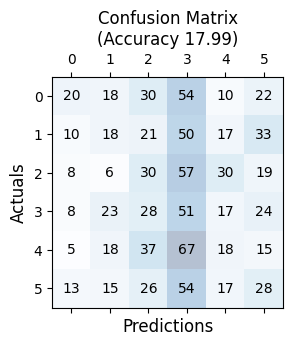

In [29]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

These results are poor. The baseline system is very limited in several aspects (features, time context, generative model, etc.). For instance, the likelihood scores are not normalized. It may happen, that one model  provides slightly higher scores for some reason. The following trick sometimes increases slightly the results:

In [30]:
llhs_norm = (results_dev['llhs'] - results_dev['llhs'].mean(axis=0))
hyp_norm = np.empty(hyp.shape, like=hyp)
for i in range(len(results_dev['fileids'])):
    ix = np.argmax(llhs_norm[i,:])
    hyp_norm[i] = LANG2ID[LANGUAGES[ix]]


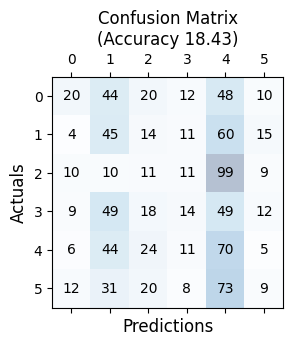

In [31]:
conf_matrix = confusion_matrix(ref, hyp_norm)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp_norm):.2f})', fontsize=12)
plt.show()

This "trick" is probematic. Can you discuss why? Can you think of an altenative way of doing the same kind of normalization?

# Creating Dataset from opensmile features

In [32]:
#For opensmile:
train_data = []
train_labels = []
trainkalaka = Kalaka(CWD, 'train100', transform_id='raw', audio_transform=audio_transform)


start = time.time()
train_data = []
train_labels = []
i=0
for data, label, basename in trainkalaka:
    print(i)
    train_data.append(opensmile_feats(data.reshape(np.shape(data)[0]),sr=16000))
    train_labels.append([label]) 
    if i%100==0:
        print(i)
    i=i+1
        
train_data = np.vstack(train_data)
train_labels = np.concatenate(train_labels)
joblib.dump(dev_data,'train100\\opensmile.pkl')


100%|██████████| 600/600 [00:53<00:00, 11.13it/s]


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


NameError: name 'joblib' is not defined

In [ ]:
#For opensmile:
dev_data = []
dev_labels = []
devkalaka = Kalaka(CWD, 'dev', transform_id='raw', audio_transform=audio_transform)


start = time.time()
train_data = []
train_labels = []
i=0
for data, label, basename in devkalaka:
    print(i)
    dev_data.append(opensmile_feats(data.reshape(np.shape(data)[0]),sr=16000))
    dev_labels.append([label]) 
    if i%100==0:
        print(i)
    i=i+1
        
dev_data = np.vstack(dev_data)
dev_labels = np.concatenate(dev_labels)


In [ ]:
#Let's train a GBDT
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import sklearn as skl
from sklearn.model_selection import ParameterSampler
import numpy as np
import math
from scipy.stats import uniform

def lgbm_param_sampler(n_iters,seed,device):
    param_grid={'num_iterations': 
                range(30, 200),
        'learning_rate':
            uniform(loc=0.001, scale=1-0.001 ),
        'num_leaves':
            range( 5, 100 ),
        'boosting_type':
            ["goss"],
        'min_data_in_leaf':
            range( 2, 50 ),
        'max_bin':
            range( 3, 100 ),
        'device': 
            [device]}
    param_list = list(ParameterSampler(param_grid, n_iter=n_iters, random_state=np.random.RandomState(seed)))
    return param_list

params=lgbm_param_sampler(50,1213,'cpu')
i=0
for k in params:
    lgbm=LGBMClassifier(**k,objective='multiclass',verbose=-1,verbose_eval=-1)
    lgbm.fit(train_data,train_labels)
    y_hat=lgbm.predict(dev_data)
    print('iter :',i,'--- dev accuracy: ',accuracy_score(y_hat,dev_labels)) #???
    #print(confusion_matrix(dev_labels, y_hat))
    i=i+1

In [ ]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['estimated_prob'] =  np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]['data']  # the features
    
    results_dev['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_dev['estimated_prob'][i,:] = np.array([lgbm.predict_proba(data.reshape(1,-1))[0,i] for i in range(len(LANGUAGES))])

    # store the reference. Notice that I only have this for the dev set, not for the eval
    results_dev['ref'][i] = (dev_data[fileid]['label']) #reference

    # Obtain the maximum likelihood languge estimation
    ix = lgbm.predict(data.reshape(1,-1))
    results_dev['hyp'][i] = ix
    
    
print(f'Finished predicting all data in {time.time() - start}')


100%|██████████| 917/917 [00:02<00:00, 306.21it/s]

Finished predicting all data in 2.9981255531311035


## Running the prediction on the evl partition

Once you are happy with your system and the results obtained in the development set, you are ready to generate the predictions on the `'evl'` partition. To do that, you have to follow the same process as for the development partition, but of course, this time you will not be able to obtain performance results because you don't have labels for this partition. 

We start by instantiating the `Kalaka` class for the `'evl'` partition:


In [ ]:
transform_id = 'mfcc'

evlkalaka = Kalaka(
    CWD,'evl',
    transform_id = transform_id, 
    audio_transform = best_parameters['audio_transform'], 
    chunk_transform = None,
    chunk_size = best_parameters['chunk_size'], 
    chunk_hop = best_parameters['chunk_hop']
)

Then, we load the evaluation data:

In [ ]:
start = time.time()
evl_data = {}

for data, label, basename in evlkalaka:
        if basename not in evl_data:
                evl_data[basename] = {'data':[], 'label':label}
        evl_data[basename]['data'].append(data)

for basename in evl_data:
        evl_data[basename]['data'] = np.concatenate(evl_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

And apply the model(s) to the new `'evl'` data:

In [ ]:
start = time.time()

results_evl = {}
results_evl['ref'] =  None
results_evl['hyp'] =  np.empty(len(evl_data),dtype=np.int32)
results_evl['llhs'] = np.empty((len(evl_data), len(LANGUAGES)), dtype=np.float64)
results_evl['fileids'] = list()


# Obtain LLH matrix
for i, fileid in tqdm(enumerate(sorted(evl_data)), total=len(evl_data)):

    data = evl_data[fileid]['data']  # the features
    results_evl['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_evl['llhs'][i,:] = np.array([best_GMM[lang].score(data) for lang in LANGUAGES])

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_evl['llhs'][i,:])
    results_evl['hyp'][i] = LANG2ID[LANGUAGES[ix]]    

print(f'Finished predicting all data in {time.time() - start}')

## Create the predictions file

The predictions file used for submission and scoring is a CSV file containing the predictions of both the `dev` and `evl` partitions.
The file has two fields: fileId and Lang. The fileId is the unique audio file identifier and the Lang field is the language prediction (numeric from 1 to 6). The predictions file name must be as follows:

`T<X>_G<YY>_<SYSTEMID>.csv` 

where `<X>` can be 1 or 2 depending on being a system for track 1 or track 2 evaluation; `<YY>` is the students' group number (use 2 digits) and `<SYSTEMID>` is a identifying string for that submission/system.

In [ ]:
group, system = '00', 'baseline_train100'
with open(f'{os.getcwd()}/T1_G{group}_{system}.csv', 'w') as file:
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    # Save dev results
    for i in range(len(results_dev['fileids'])):
        csv_writer.writerow((results_dev['fileids'][i], results_dev['hyp'][i]))
    # Save evl results
    for i in range(len(results_evl['fileids'])):
        csv_writer.writerow((results_evl['fileids'][i], results_evl['hyp'][i]))

## Submit your prediction
You can submit your prediction in the following Kaggle competition: https://www.kaggle.com/competitions/speech-processing-lab-2/

## What should/can you do next?
**Everything!!** Try to extend and improve the feature extraction. Try to play with the parameters. Try completely different feature extraction modules (look for openSMILE, torchaudio,). Try to increase the model complexity. Try different modeling approaches. Try to understand the impact of the different modifications. Once you are happy with your system, try to train on the full set and check the impact of adding data to your system.


# PART 2 - Using pre-trained embeddings (Track 2)

There exist plenty of resources and pre-trained models that can be extremely useful for our task. For instance, x-vectors are currently the state of the art approach to obtain speech embeddings that characterize very efficiently speaker or language, among others. Particularly, the following x-vector model is available and it has been trained using a large corpus of 107 languages for language identification: https://huggingface.co/speechbrain/lang-id-voxlingua107-ecapa

You can obtain it from the `speechbrain` module, that you need to install now if you are using Google Colab:



In [ ]:
# If you are using Google Colab, you'll have to install the speechbrain module
raise CheckThisCell ## <---- Remove this after completing/checking this cell
!pip install speechbrain

The following code cell imports such model and shows how to obtain an embedding vector:

In [ ]:
import torchaudio
import speechbrain

from speechbrain.pretrained import EncoderClassifier
from torch.nn.utils.rnn import pad_sequence

language_id = EncoderClassifier.from_hparams(source="speechbrain/lang-id-voxlingua107-ecapa", savedir="tmp")

signal = language_id.load_audio(f'{CWD}/train100/audio/0a5c0729.wav')
emb =  language_id.encode_batch(signal)

In fact, the model is trained for language identification of 107 languages and we could use it directly for identification:

In [ ]:
prediction =  language_id.classify_batch(signal)

Invest some time to inspect the model and the outputs. Notice that the six target languages are included among the 107. The output indices are: 

```python
XVEC_LANG_INDEX = (24,13,20,29,75,22) 
```

corresponding respectively to the following languages:

```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

Knowing this, it should be easy to obtain the predicted class among the six possible candidates:

In [ ]:
XVEC_LANG_INDEX = (24,13,20,29,75,22) 

# Obtain the predicted class out of the 6 target ones
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

## Using the x-vector up-stream model for language ID

Let's try first something simple: use the the pre-trained model for idenfication. In this simple test, you don't need to train anyhing simply classify the dev and test sets. To do so, first configure the right transformation for the Kalaka class (one that simply loads the audio without any chunking):

In [ ]:
# Confifure the tranformation
raise CheckThisCell ## <---- Remove this after completeing/checking this cell

transform = { 
                'raw_xvec' :
                {
                    'audio_transform': None, ## <--- You need to modify this here
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }
            }

# Download and feature extract
transform_id = 'raw_xvec'


devkalaka = Kalaka(CWD, 'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

Now you have all the elements to predict langauge using the langID pre-trained model.
In case you have access to a GPU, it may be good using a Pytorch Dataloader to batch the dev samples:

In [ ]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

Since the audios are of different size, we need to pass an auxiliary function to the dataloader that handles this (by adding 0s). This can be done as follows:

In [ ]:
def collate_batch(batch): 
    label_list, audio_list, basename_list, audiolen_list = [], [], [], []

    for (_audio,_label, _basename) in batch:
        label_list.append(_label)
        audio_list.append(_audio)
        basename_list.append(_basename)
        audiolen_list.append(_audio.shape[0])

    label_list = torch.tensor(label_list, dtype=torch.int64)
    audio_list = pad_sequence(audio_list, batch_first=True, padding_value=0)
    max_len = max(audiolen_list)
    audiolen_list = torch.tensor([l/max_len for l in audiolen_list])

    return audio_list.to(device),label_list.to(device), basename_list, audiolen_list.to(device)

batch_size = 10
dataloader = torch.utils.data.DataLoader(
        dataset=devkalaka,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=False  # <-- We want to keep the original order of the dev set
)


Complete the following piece of code to store properly the hypothesis and the reference:

In [ ]:
import time
from tqdm import tqdm
start = time.time()

results_dev = {}
results_dev['ref'] =  []
results_dev['hyp'] =  []
results_dev['fileids'] = [] 

for i, batch in tqdm(enumerate(dataloader), total=1+len(devkalaka)//batch_size):
    data, label, basename, audiolen = batch
    predictions = language_id.classify_batch(data, wav_lens=audiolen)
    
    # Complete the code to store the hypothesis (careful if you use argmax, you will ned to add 1 to the predicted class),
    # the reference and the fileids. In the call to the prediction method, you should pass the audio length information, so that 
    # the padded 0s can be ignored
    raise CheckThisCell ## <---- Remove this after completeing/checking this cell
    
print(f'Finished preocessing all data in {time.time() - start}')

And now let's see how well this model behaves on our dev partition:

In [ ]:
ref, hyp = results_dev['ref'], results_dev['hyp']

conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

That was pretty impressive, right!?! And  easier than Part I of this lab! 

Well, here comes some bad news: you can not use this langid classifier in the challenge. However, you can use the pre-trained x-vector embeddings as a feature extractor to train your language classification system (may be a simple K-means on top of the x-vectors work well). You can also try to change the classification head of the x-vector model and fine-tune with the challenge data. You have plenty of options, but remember, any system that use these pre-trained embeddings (or any similar ones) are only valid for the Track 2 of the Challenge and the prediction file should be  namedlike this: `T2_G<YY>_<SYSTEMID>.csv` 



# What should you deliver at the end of this lab assignment?
You should deliver the following three elements:
- You must submit at least one prediction file to the Kaggle competition in the format previously described: https://www.kaggle.com/competitions/speech-processing-lab-2/
- You must submit (via Fênix) the modified notebook (or code) of your proposed systems(s).
- You must submit a report (via Fênix) of maximum 2 pages describing your system, approaches (may be unsuccesful), lessons learnt, results on the dev partition, etc. You can use the following Overleaf template for the report: https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr

# Contacts and support
You can contact the professors during the classes or the office hours.

Particularly, for this second laboratory assignment, you should contact Prof. Alberto Abad: alberto.abad@tecnico.ulisboa.pt



